In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

!pip install --upgrade seaborn
import seaborn as sns

np.random.seed(42)

plt.rcParams.update({'figure.max_open_warning': 0})
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 250)
pd.set_option('display.max_columns', 250)

     |████████████████████████████████| 285 kB 4.4 MB/s 
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.10.0
    Uninstalling seaborn-0.10.0:
      Successfully uninstalled seaborn-0.10.0
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
from sklearn.model_selection import KFold, cross_val_score
from skopt.space import Real, Integer
from skopt import BayesSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import VarianceThreshold
!pip install --upgrade lightgbm
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
import lightgbm as lgb
import xgboost as xgb

     |████████████████████████████████| 1.8 MB 4.4 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.3.1
    Uninstalling lightgbm-2.3.1:
      Successfully uninstalled lightgbm-2.3.1
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


# 1. General Infos About Data
Loading, describing, getting general infos about data

In [3]:
train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")

train_id = train.Id
test_id = test.Id

print("Train set: ", train.shape)
print("Test set: ", test.shape)

train.info()

Train set:  (1460, 81)
Test set:  (1459, 80)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  Overall

In [4]:
train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

In [5]:
train.describe().round(3)

Id  MSSubClass  LotFrontage     LotArea  OverallQual  OverallCond  \
count  1460.00    1460.000     1201.000    1460.000     1460.000     1460.000   
mean    730.50      56.897       70.050   10516.828        6.099        5.575   
std     421.61      42.301       24.285    9981.265        1.383        1.113   
min       1.00      20.000       21.000    1300.000        1.000        1.000   
25%     365.75      20.000       59.000    7553.500        5.000        5.000   
50%     730.50      50.000       69.000    9478.500        6.000        5.000   
75%    1095.25      70.000       80.000   11601.500        7.000        6.000   
max    1460.00     190.000      313.000  215245.000       10.000        9.000   

       YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  \
count   1460.000      1460.000    1452.000    1460.000    1460.000   1460.000   
mean    1971.268      1984.866     103.685     443.640      46.549    567.240   
std       30.203        20.645     181.066     456.098     161.319    441.867   
min     1872.000      1950.000       0.000       0.000       0.000      0.000   
25%     1954.000      1967.000       0.000       0.000       0.000    223.000   
50%     1973.000      1994.000       0.000     383.500       0.000    477.500   
75%     2000.000      2004.000     166.000     712.250       0.000    808.000   
max     2010.000      2010.000    1600.000    5644.000    1474.000   2336.000   

       TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  \
count     1460.000  1460.000  1460.000      1460.000   1460.000      1460.000   
mean      1057.429  1162.627   346.992         5.845   1515.464         0.425   
std        438.705   386.588   436.528        48.623    525.480         0.519   
min          0.000   334.000     0.000         0.000    334.000         0.000   
25%        795.750   882.000     0.000         0.000   1129.500         0.000   
50%        991.500  1087.000     0.000         0.000   1464.000         0.000   
75%       1298.250  1391.250   728.000         0.000   1776.750         1.000   
max       6110.000  4692.000  2065.000       572.000   5642.000         3.000   

       BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
count      1460.000  1460.000  1460.000      1460.000      1460.000   
mean          0.058     1.565     0.383         2.866         1.047   
std           0.239     0.551     0.503         0.816         0.220   
min           0.000     0.000     0.000         0.000         0.000   
25%           0.000     1.000     0.000         2.000         1.000   
50%           0.000     2.000     0.000         3.000         1.000   
75%           0.000     2.000     1.000         3.000         1.000   
max           2.000     3.000     2.000         8.000         3.000   

       TotRmsAbvGrd  Fireplaces  GarageYrBlt  GarageCars  GarageArea  \
count      1460.000    1460.000     1379.000    1460.000    1460.000   
mean          6.518       0.613     1978.506       1.767     472.980   
std           1.625       0.645       24.690       0.747     213.805   
min           2.000       0.000     1900.000       0.000       0.000   
25%           5.000       0.000     1961.000       1.000     334.500   
50%           6.000       1.000     1980.000       2.000     480.000   
75%           7.000       1.000     2002.000       2.000     576.000   
max          14.000       3.000     2010.000       4.000    1418.000   

       WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
count    1460.000     1460.000       1460.000   1460.000     1460.000   
mean       94.245       46.660         21.954      3.410       15.061   
std       125.339       66.256         61.119     29.317       55.757   
min         0.000        0.000          0.000      0.000        0.000   
25%         0.000        0.000          0.000      0.000        0.000   
50%         0.000       25.000          0.000      0.000        0.000   
75%       168.000     

In [6]:
train.describe(include=["O"])

MSZoning Street Alley LotShape LandContour Utilities LotConfig  \
count      1460   1460    91     1460        1460      1460      1460   
unique        5      2     2        4           4         2         5   
top          RL   Pave  Grvl      Reg         Lvl    AllPub    Inside   
freq       1151   1454    50      925        1311      1459      1052   

       LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  \
count       1460         1460       1460       1460     1460       1460   
unique         3           25          9          8        5          8   
top          Gtl        NAmes       Norm       Norm     1Fam     1Story   
freq        1382          225       1260       1445     1220        726   

       RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType ExterQual  \
count       1460     1460        1460        1460       1452      1460   
unique         6        8          15          16          4         4   
top        Gable  CompShg     VinylSd     VinylSd       None        TA   
freq        1141     1434         515         504        864       906   

       ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  \
count       1460       1460     1423     1423         1422         1423   
unique         5          6        4        4            4            6   
top           TA      PConc       TA       TA           No          Unf   
freq        1282        647      649     1311          953          430   

       BsmtFinType2 Heating HeatingQC CentralAir Electrical KitchenQual  \
count          1422    1460      1460       1460       1459        1460   
unique            6       6         5          2          5           4   
top             Unf    GasA        Ex          Y      SBrkr          TA   
freq           1256    1428       741       1365       1334         735   

       Functional FireplaceQu GarageType GarageFinish GarageQual GarageCond  \
count        1460         770       1379         1379       1379       1379   
unique          7           5          6            3          5          5   
top           Typ          Gd     Attchd          Unf         TA         TA   
freq         1360         380        870          605       1311       1326   

       PavedDrive PoolQC  Fence MiscFeature SaleType SaleCondition  
count        1460      7    281          54     1460          1460  
unique          3      3      4           4        9             6  
top             Y     Gd  MnPrv        Shed       WD        Normal  
freq         1340      3    157          49     1267          1198

In [7]:
df = pd.concat([train, test])
df

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1454  2915         160       RM         21.0     1936   Pave   NaN      Reg   
1455  2916         160       RM         21.0     1894   Pave   NaN      Reg   
1456  2917          20       RL        160.0    20000   Pave   NaN      Reg   
1457  2918          85       RL         62.0    10441   Pave   NaN      Reg   
1458  2919          60       RL         74.0     9627   Pave   NaN      Reg   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0            Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1            Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2            Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3            Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4            Lvl    AllPub       FR2       Gtl      NoRidge       Norm   
...          ...       ...       ...       ...          ...        ...   
1454         Lvl    AllPub    Inside       Gtl      MeadowV       Norm   
1455         Lvl    AllPub    Inside       Gtl      MeadowV       Norm   
1456         Lvl    AllPub    Inside       Gtl      Mitchel       Norm   
1457         Lvl    AllPub    Inside       Gtl      Mitchel       Norm   
1458         Lvl    AllPub    Inside       Mod      Mitchel       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0          Norm     1Fam     2Story            7            5       2003   
1          Norm     1Fam     1Story            6            8       1976   
2          Norm     1Fam     2Story            7            5       2001   
3          Norm     1Fam     2Story            7            5       1915   
4          Norm     1Fam     2Story            8            5       2000   
...         ...      ...        ...          ...          ...        ...   
1454       Norm    Twnhs     2Story            4            7       1970   
1455       Norm   TwnhsE     2Story            4            5       1970   
1456       Norm     1Fam     1Story            5            7       1960   
1457       Norm     1Fam     SFoyer            5            5       1992   
1458       Norm     1Fam     2Story            7            5       1993   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0             2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1             1976     Gable  CompShg     MetalSd     MetalSd       None   
2             2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3             1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4             2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   
...            ...       ...      ...         ...         ...        ...   
1454          1970     Gable  CompShg     CemntBd     CmentBd       None   
1455          1970     Gable  CompShg     CemntBd     CmentBd       None   
1456          1996     Gable  CompShg     VinylSd     VinylSd       None   
1457          1992     Gable  CompShg     HdBoard     Wd Shng       None   
1458          1994     Gable  CompShg     HdBoard     HdBoard    BrkFace   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
0          196.0        Gd        TA      PConc       Gd       TA   
1            0.0        TA        TA     CBlock       Gd       TA   
2          162.0        Gd        TA      PConc       Gd       TA   
3            0.0        TA        TA     BrkTil       TA       Gd   

# 2. Handling Missing Values
Instead of mode or median encoding, I fill missing values with similarities between the observations. It is manual process, takes more time than statistical imputing methods, but we get more insghts about data. Also it creates a chance to correctting some infos like garage features or totalbasement etc

In [8]:
def col_types(df):
    num_cols = df.loc[:, df.dtypes != "object"].columns.tolist()
    cat_cols = df.loc[:, df.dtypes == "object"].columns.tolist()
    ord_cols = []
    for col in num_cols:
        if df[col].value_counts().size < 20:
            ord_cols.append(col)

    num_cols = [x for x in num_cols if x not in ord_cols + ["Id", "SalePrice"]]
    
    return num_cols, cat_cols, ord_cols

In [9]:
def missing(df):
    miss = pd.DataFrame({"no_missing_values": df.isnull().sum(),
                         "missing_value_ratio": (df.isnull().sum() / df.shape[0]).round(4),
                         "missing_in_train": df[df.SalePrice.notnull()].isnull().sum(),
                         "missing_in_test": df[df.SalePrice.isnull()].isnull().sum()})
    return miss[miss.no_missing_values > 0].sort_values("no_missing_values", ascending=False)

missing(df)

no_missing_values  missing_value_ratio  missing_in_train  \
PoolQC                     2909               0.9966              1453   
MiscFeature                2814               0.9640              1406   
Alley                      2721               0.9322              1369   
Fence                      2348               0.8044              1179   
SalePrice                  1459               0.4998                 0   
FireplaceQu                1420               0.4865               690   
LotFrontage                 486               0.1665               259   
GarageCond                  159               0.0545                81   
GarageYrBlt                 159               0.0545                81   
GarageFinish                159               0.0545                81   
GarageQual                  159               0.0545                81   
GarageType                  157               0.0538                81   
BsmtExposure                 82               0.0281                38   
BsmtCond                     82               0.0281                37   
BsmtQual                     81               0.0277                37   
BsmtFinType2                 80               0.0274                38   
BsmtFinType1                 79               0.0271                37   
MasVnrType                   24               0.0082                 8   
MasVnrArea                   23               0.0079                 8   
MSZoning                      4               0.0014                 0   
Functional                    2               0.0007                 0   
BsmtHalfBath                  2               0.0007                 0   
BsmtFullBath                  2               0.0007                 0   
Utilities                     2               0.0007                 0   
KitchenQual                   1               0.0003                 0   
TotalBsmtSF                   1               0.0003                 0   
BsmtUnfSF                     1               0.0003                 0   
GarageCars                    1               0.0003                 0   
GarageArea                    1               0.0003                 0   
BsmtFinSF2                    1               0.0003                 0   
BsmtFinSF1                    1               0.0003                 0   
Exterior2nd                   1               0.0003                 0   
Exterior1st                   1               0.0003                 0   
SaleType                      1               0.0003                 0   
Electrical                    1               0.0003                 1   

              missing_in_test  
PoolQC                   1456  
MiscFeature              1408  
Alley                    1352  
Fence                    1169  
SalePrice                1459  
FireplaceQu               730  
LotFrontage               227  
GarageCond                 78  
GarageYrBlt                78  
GarageFinish               78  
GarageQual                 78  
GarageType                 76  
BsmtExposure               44  
BsmtCond                   45  
BsmtQual                   44  
BsmtFinType2               42  
BsmtFinType1               42  
MasVnrType                 16  
MasVnrArea                 15  
MSZoning                    4  
Functional                  2  
BsmtHalfBath                2  
BsmtFullBath                2  
Utilities                   2  
KitchenQual                 1  
TotalBsmtSF                 1  
BsmtUnfSF                   1  
GarageCars                  1  
GarageArea                  1  
BsmtFinSF2                  1  
BsmtFinSF1                  1  
Exterior2nd                 1  
Exterior1st                 1  
SaleType                    1  
Electrical                  0

In [10]:
df[(df.GarageFinish.isnull()) & (df.GarageType.notnull())]

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
666   2127          60       RM         57.0     8094   Pave  Grvl      Reg   
1116  2577          70       RM         50.0     9060   Pave   NaN      Reg   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
666          Lvl    AllPub    Inside       Gtl      OldTown       Norm   
1116         Lvl    AllPub    Inside       Gtl       IDOTRR       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
666        Norm   2fmCon     2.5Unf            6            8       1910   
1116       Norm     1Fam     2Story            5            6       1923   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
666           1983     Gable  CompShg     Wd Sdng     Wd Sdng       None   
1116          1999     Gable  CompShg     Wd Sdng     Plywood       None   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
666          0.0        TA        TA      PConc       TA       TA   
1116         0.0        TA        TA     BrkTil       Gd       TA   

     BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  \
666            Mn          Rec       196.0          Unf         0.0   
1116           No          ALQ       548.0          Unf         0.0   

      BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  \
666      1046.0       1242.0    GasA        Gd          Y      SBrkr   
1116      311.0        859.0    GasA        Ex          Y      SBrkr   

      1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
666       1242       742             0       1984           0.0           0.0   
1116       942       886             0       1828           0.0           0.0   

      FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  \
666          2         0             5             1          TA   
1116         2         0             3             1          Gd   

      TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt  \
666              8        Typ           0         NaN     Detchd          NaN   
1116             6        Typ           0         NaN     Detchd          NaN   

     GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  \
666           NaN         1.0       360.0        NaN        NaN          Y   
1116          NaN         NaN         NaN        NaN        NaN          Y   

      WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
666           64            0            180          0            0   
1116         174            0            212          0            0   

      PoolArea PoolQC  Fence MiscFeature  MiscVal  MoSold  YrSold SaleType  \
666          0    NaN  MnPrv        Shed     1000       9    2008       WD   
1116         0    NaN  MnPrv         NaN        0       3    2007       WD   

     SaleCondition  SalePrice  
666         Normal        NaN  
1116        Alloca        NaN

In [11]:
df.loc[(df.GarageFinish.isnull()) & (df.GarageType.notnull()), "GarageFinish"] = "Fin"
df.loc[(df.GarageCars.isnull()) & (df.GarageType.notnull()), "GarageCars"] = 1
df.loc[(df.GarageQual.isnull()) & (df.GarageType.notnull()), "GarageQual"] = "TA"
df.loc[(df.GarageCond.isnull()) & (df.GarageType.notnull()), "GarageCond"] = "TA"

In [12]:
df[df.GarageYrBlt == df.YearBuilt].shape[0]

2216

In [13]:
df.loc[(df.GarageYrBlt.isnull()) & (df.GarageType.notnull()), "GarageYrBlt"] = df.loc[(df.GarageYrBlt.isnull()) & (df.GarageType.notnull())].YearBuilt

In [14]:
df[(df.GarageType == "Detchd") & (df.YearBuilt < 1930) & (df.YearRemodAdd < 2000) & (df.YearRemodAdd > 1980) & (df.GarageCars == 1)].GarageArea.median()

234.0

In [15]:
df.loc[(df.GarageArea.isnull()) & (df.GarageType.notnull()), "GarageArea"] = 234

In [16]:
num_cols, cat_cols, ord_cols = col_types(df)

In [17]:
none_cols = ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageCond", "GarageFinish", "GarageQual", 
             "GarageType", "BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType1", "MasVnrType", "BsmtFinType2"]

for col in none_cols: 
    df[col].fillna("None", inplace=True)
    
missing(df)

no_missing_values  missing_value_ratio  missing_in_train  \
SalePrice                  1459               0.4998                 0   
LotFrontage                 486               0.1665               259   
GarageYrBlt                 157               0.0538                81   
MasVnrArea                   23               0.0079                 8   
MSZoning                      4               0.0014                 0   
BsmtFullBath                  2               0.0007                 0   
BsmtHalfBath                  2               0.0007                 0   
Functional                    2               0.0007                 0   
Utilities                     2               0.0007                 0   
Exterior2nd                   1               0.0003                 0   
BsmtFinSF1                    1               0.0003                 0   
BsmtFinSF2                    1               0.0003                 0   
BsmtUnfSF                     1               0.0003                 0   
Exterior1st                   1               0.0003                 0   
Electrical                    1               0.0003                 1   
KitchenQual                   1               0.0003                 0   
SaleType                      1               0.0003                 0   
TotalBsmtSF                   1               0.0003                 0   

              missing_in_test  
SalePrice                1459  
LotFrontage               227  
GarageYrBlt                76  
MasVnrArea                 15  
MSZoning                    4  
BsmtFullBath                2  
BsmtHalfBath                2  
Functional                  2  
Utilities                   2  
Exterior2nd                 1  
BsmtFinSF1                  1  
BsmtFinSF2                  1  
BsmtUnfSF                   1  
Exterior1st                 1  
Electrical                  0  
KitchenQual                 1  
SaleType                    1  
TotalBsmtSF                 1

In [18]:
df.loc[(df.MasVnrArea.isnull()) & (df.MasVnrType == "None"), "MasVnrArea"] = 0

In [19]:
for col in ["BsmtFullBath", "BsmtHalfBath", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "GarageYrBlt"]:
    df[col].fillna(0, inplace = True)
    
df["TotalBsmtSF"].fillna(df["BsmtFinSF1"] + df["BsmtFinSF2"] + df["BsmtUnfSF"], inplace = True)

missing(df)

no_missing_values  missing_value_ratio  missing_in_train  \
SalePrice                 1459               0.4998                 0   
LotFrontage                486               0.1665               259   
MSZoning                     4               0.0014                 0   
Utilities                    2               0.0007                 0   
Functional                   2               0.0007                 0   
Exterior1st                  1               0.0003                 0   
Exterior2nd                  1               0.0003                 0   
Electrical                   1               0.0003                 1   
KitchenQual                  1               0.0003                 0   
SaleType                     1               0.0003                 0   

             missing_in_test  
SalePrice               1459  
LotFrontage              227  
MSZoning                   4  
Utilities                  2  
Functional                 2  
Exterior1st                1  
Exterior2nd                1  
Electrical                 0  
KitchenQual                1  
SaleType                   1

In [20]:
print(df.MSZoning.value_counts())

df[df.MSZoning.isnull()]

RL         2265
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64


Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
455   1916          30      NaN        109.0    21780   Grvl  None      Reg   
756   2217          20      NaN         80.0    14584   Pave  None      Reg   
790   2251          70      NaN          NaN    56600   Pave  None      IR1   
1444  2905          20      NaN        125.0    31250   Pave  None      Reg   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
455          Lvl       NaN    Inside       Gtl       IDOTRR       Norm   
756          Low    AllPub    Inside       Mod       IDOTRR       Norm   
790          Low    AllPub    Inside       Gtl       IDOTRR       Norm   
1444         Lvl    AllPub    Inside       Gtl      Mitchel     Artery   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
455        Norm     1Fam     1Story            2            4       1910   
756        Norm     1Fam     1Story            1            5       1952   
790        Norm     1Fam     2.5Unf            5            1       1900   
1444       Norm     1Fam     1Story            1            3       1951   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
455           1950     Gable  CompShg     Wd Sdng     Wd Sdng       None   
756           1952     Gable  CompShg     AsbShng     VinylSd       None   
790           1950       Hip  CompShg     Wd Sdng     Wd Sdng       None   
1444          1951     Gable  CompShg      CBlock     VinylSd       None   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
455          0.0        Fa        Fa     CBlock     None     None   
756          0.0        Fa        Po       Slab     None     None   
790          0.0        TA        TA     BrkTil       TA       TA   
1444         0.0        TA        Fa     CBlock     None     None   

     BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  \
455          None         None         0.0         None         0.0   
756          None         None         0.0         None         0.0   
790            No          Unf         0.0          Unf         0.0   
1444         None         None         0.0         None         0.0   

      BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  \
455         0.0          0.0    GasA        TA          N      FuseA   
756         0.0          0.0    Wall        Po          N      FuseA   
790       686.0        686.0    GasA        Ex          Y      SBrkr   
1444        0.0          0.0    GasA        TA          Y      FuseA   

      1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
455        810         0             0        810           0.0           0.0   
756        733         0             0        733           0.0           0.0   
790       1150       686             0       1836           0.0           0.0   
1444      1600         0             0       1600           0.0           0.0   

      FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  \
455          1         0             1             1          TA   
756          1         0             2             1          Fa   
790          2         0             4             1          TA   
1444         1         1             3             1          TA   

      TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt  \
455              4       Min1           0        None     Detchd       1975.0   
756              4        NaN           0        None     Attchd       1952.0   
790              7       Maj1           0        None     Detchd       1900.0   
1444             6        Mod           0        None     Attchd       1951.0   

     GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  \
455           Unf         1.0       280.0         TA         TA          N   
756           Unf         2.0       487.0         Fa         Po          N   
790           Unf         1.0

In [21]:
df.groupby("Neighborhood").MSZoning.value_counts()

Neighborhood  MSZoning
Blmngtn       RL           25
              RM            3
Blueste       RM           10
BrDale        RM           30
BrkSide       RM           65
              RL           43
ClearCr       RL           44
CollgCr       RL          253
              RM           14
Crawfor       RL           91
              RM           10
              RH            2
Edwards       RL          180
              RM           12
              RH            2
Gilbert       RL          165
IDOTRR        RM           68
              C (all)      22
MeadowV       RM           37
Mitchel       RL          104
              RM            9
NAmes         RL          436
              RH            7
NPkVill       RL           23
NWAmes        RL          131
NoRidge       RL           71
NridgHt       RL          165
              RM            1
OldTown       RM          198
              RL           39
              C (all)       2
SWISU         RL           38
              RH 

In [22]:
df.loc[(df.MSZoning.isnull()) & (df.Neighborhood == "IDOTRR"), "MSZoning"] = "C (all)"
df.loc[(df.MSZoning.isnull()) & (df.Neighborhood == "Mitchel"), "MSZoning"] = "RL"

In [23]:
df.KitchenQual.value_counts()

TA    1492
Gd    1151
Ex     205
Fa      70
Name: KitchenQual, dtype: int64

In [24]:
print(df.groupby(["OverallQual", "KitchenAbvGr"]).KitchenQual.value_counts())
df.loc[(df.KitchenQual.isnull()) & (df.OverallQual == 5 ) & (df.KitchenAbvGr == 1), "KitchenQual"] = "TA"

OverallQual  KitchenAbvGr  KitchenQual
1            1             Fa               3
                           TA               1
2            1             TA               9
                           Fa               3
                           Gd               1
3            1             TA              23
                           Fa               7
                           Gd               3
             2             TA               7
4            1             TA             166
                           Gd              21
                           Fa              17
             2             TA              15
                           Fa               6
             3             TA               1
5            1             TA             597
                           Gd             122
                           Fa              20
                           Ex              15
             2             TA              64
                           Gd            

In [25]:
print(df.SaleType.value_counts())

df[df.SaleType.isnull()]

WD       2525
New       239
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
Name: SaleType, dtype: int64


Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1029  2490          20       RL         85.0    13770   Pave  None      Reg   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
1029         Lvl    AllPub    Corner       Gtl       Sawyer      Feedr   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
1029       Norm     1Fam     1Story            5            6       1958   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
1029          1998     Gable  CompShg     Plywood     Plywood    BrkFace   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
1029       340.0        TA        TA     CBlock       TA       TA   

     BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  \
1029           Mn          Rec       190.0          BLQ       873.0   

      BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  \
1029       95.0       1158.0    GasA        TA          Y      SBrkr   

      1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
1029      1176         0             0       1176           1.0           0.0   

      FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  \
1029         1         0             3             1          TA   

      TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt  \
1029             6        Typ           2          Gd     Attchd       1958.0   

     GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  \
1029          Unf         1.0       303.0         TA         TA          Y   

      WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
1029           0            0              0          0            0   

      PoolArea PoolQC Fence MiscFeature  MiscVal  MoSold  YrSold SaleType  \
1029         0   None  None        None        0      10    2007      NaN   

     SaleCondition  SalePrice  
1029        Normal        NaN

In [26]:
print(df.groupby(["Neighborhood", "SaleCondition"]).SaleType.value_counts())
df.loc[(df.SaleType.isnull()) & (df.Neighborhood == "Sawyer" ) & (df.SaleCondition == "Normal"), "SaleType"] = "WD"

Neighborhood  SaleCondition  SaleType
Blmngtn       Normal         WD           19
              Partial        New           9
Blueste       Normal         WD            9
                             COD           1
BrDale        Abnorml        COD           2
                             WD            1
              Family         WD            1
              Normal         WD           25
                             COD           1
BrkSide       Abnorml        WD            6
                             ConLD         1
                             ConLI         1
              Family         ConLw         1
                             WD            1
              Normal         WD           95
                             COD           1
                             CWD           1
                             ConLw         1
ClearCr       Abnorml        WD            4
                             COD           1
              Normal         WD           35
                 

In [27]:
print(df.Electrical.value_counts())

df[df.Electrical.isnull()]

SBrkr    2671
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64


Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1379  1380          80       RL         73.0     9735   Pave  None      Reg   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
1379         Lvl    AllPub    Inside       Gtl       Timber       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
1379       Norm     1Fam       SLvl            5            5       2006   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
1379          2007     Gable  CompShg     VinylSd     VinylSd       None   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
1379         0.0        TA        TA      PConc       Gd       TA   

     BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  \
1379           No          Unf         0.0          Unf         0.0   

      BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  \
1379      384.0        384.0    GasA        Gd          Y        NaN   

      1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
1379       754       640             0       1394           0.0           0.0   

      FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  \
1379         2         1             3             1          Gd   

      TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt  \
1379             7        Typ           0        None    BuiltIn       2007.0   

     GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  \
1379          Fin         2.0       400.0         TA         TA          Y   

      WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
1379         100            0              0          0            0   

      PoolArea PoolQC Fence MiscFeature  MiscVal  MoSold  YrSold SaleType  \
1379         0   None  None        None        0       5    2008       WD   

     SaleCondition  SalePrice  
1379        Normal   167500.0

In [28]:
df[(df.YearBuilt > 2005)].Electrical.value_counts()

SBrkr    323
Name: Electrical, dtype: int64

In [29]:
df.Electrical.fillna("SBrkr", inplace=True)

In [30]:
print(df.Exterior1st.value_counts())

df[df.Exterior1st.isnull()]

VinylSd    1025
MetalSd     450
HdBoard     442
Wd Sdng     411
Plywood     221
CemntBd     126
BrkFace      87
WdShing      56
AsbShng      44
Stucco       43
BrkComm       6
CBlock        2
AsphShn       2
Stone         2
ImStucc       1
Name: Exterior1st, dtype: int64


Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
691  2152          30       RL         85.0    19550   Pave  None      Reg   

    LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
691         Lvl    AllPub    Inside       Gtl      Edwards       Norm   

    Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
691       Norm     1Fam     1Story            5            7       1940   

     YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
691          2007      Flat  Tar&Grv         NaN         NaN       None   

     MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
691         0.0        TA        TA      PConc       TA       TA           Gd   

    BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
691          ALQ      1035.0          Unf         0.0      545.0       1580.0   

    Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
691    GasA        Ex          Y      SBrkr      1518         0             0   

     GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
691       1518           1.0           0.0         1         0             2   

     KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces  \
691             1          Fa             5        Typ           2   

    FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea  \
691          Gd       None          0.0         None         0.0         0.0   

    GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  \
691       None       None          Y           0           39              0   

     3SsnPorch  ScreenPorch  PoolArea PoolQC Fence MiscFeature  MiscVal  \
691          0            0         0   None  None        None        0   

     MoSold  YrSold SaleType SaleCondition  SalePrice  
691       1    2008       WD        Normal        NaN

In [31]:
print(df[(df.RoofMatl == "Tar&Grv")].Exterior1st.value_counts())
df.Exterior1st.fillna("Plywood", inplace=True)

Plywood    13
Wd Sdng     4
WdShing     2
VinylSd     1
BrkComm     1
HdBoard     1
Name: Exterior1st, dtype: int64


In [32]:
print(df[(df.RoofMatl == "Tar&Grv")].Exterior2nd.value_counts())
df.Exterior2nd.fillna("Plywood", inplace=True)

Plywood    12
Wd Sdng     4
Wd Shng     2
Brk Cmn     1
HdBoard     1
CBlock      1
VinylSd     1
Name: Exterior2nd, dtype: int64


In [33]:
print(df.Functional.value_counts())

df[df.Functional.isnull()]

Typ     2717
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
Name: Functional, dtype: int64


Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
756   2217          20  C (all)         80.0    14584   Pave  None      Reg   
1013  2474          50       RM         60.0    10320   Pave  Grvl      Reg   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
756          Low    AllPub    Inside       Mod       IDOTRR       Norm   
1013         Lvl    AllPub    Corner       Gtl       IDOTRR     Artery   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
756        Norm     1Fam     1Story            1            5       1952   
1013       Norm     1Fam     1.5Fin            4            1       1910   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
756           1952     Gable  CompShg     AsbShng     VinylSd       None   
1013          1950     Gable  CompShg     Wd Sdng     Wd Sdng       None   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
756          0.0        Fa        Po       Slab     None     None   
1013         0.0        Fa        Fa     CBlock       TA       Fa   

     BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  \
756          None         None         0.0         None         0.0   
1013           No          Unf         0.0          Unf         0.0   

      BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  \
756         0.0          0.0    Wall        Po          N      FuseA   
1013      771.0        771.0    GasA        Fa          Y      SBrkr   

      1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
756        733         0             0        733           0.0           0.0   
1013       866       504           114       1484           0.0           0.0   

      FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  \
756          1         0             2             1          Fa   
1013         2         0             3             1          TA   

      TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt  \
756              4        NaN           0        None     Attchd       1952.0   
1013             6        NaN           0        None     Detchd       1910.0   

     GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  \
756           Unf         2.0       487.0         Fa         Po          N   
1013          Unf         1.0       264.0         TA         Fa          N   

      WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
756            0            0              0          0            0   
1013          14          211              0          0           84   

      PoolArea PoolQC Fence MiscFeature  MiscVal  MoSold  YrSold SaleType  \
756          0   None  None        None        0       2    2008       WD   
1013         0   None  None        None        0       9    2007      COD   

     SaleCondition  SalePrice  
756        Abnorml        NaN  
1013       Abnorml        NaN

In [34]:
df[(df.Neighborhood == "IDOTRR") &  (df.OverallQual < 5) & (df.YearRemodAdd < 1960) & (df.ExterQual == "Fa")].Functional.value_counts()

Typ     4
Mod     1
Min1    1
Name: Functional, dtype: int64

In [35]:
df.Functional.fillna("Mod", inplace = True)

In [36]:
df["LotFrontage"] = df["LotFrontage"].fillna(df.groupby(["Neighborhood", "LotShape", "LotConfig"])["LotFrontage"].transform("median"))
df["LotFrontage"] = df["LotFrontage"].fillna(df.groupby(["Neighborhood", "LotShape"])["LotFrontage"].transform("median"))
df["LotFrontage"] = df["LotFrontage"].fillna(df.groupby("Neighborhood")["LotFrontage"].transform("median"))

In [37]:
df.Utilities.fillna(df.Utilities.mode()[0], inplace=True)

missing(df)

no_missing_values  missing_value_ratio  missing_in_train  \
SalePrice               1459               0.4998                 0   

           missing_in_test  
SalePrice             1459

In [38]:
df["MSSubClass"] = df["MSSubClass"].astype("str")

In [39]:
df.loc[(df.GarageYrBlt == 2207), "GarageYrBlt"] = 2007

df.loc[(df.Exterior2nd == "CmentBd"), "Exterior2nd"] = "CemntBd"
df.loc[(df.Exterior2nd == "Wd Shng"), "Exterior2nd"] = "WdShing"
df.loc[(df.Exterior2nd == "Brk Cmn"), "Exterior2nd"] = "BrkComm"

# 3. Comprehensive Eda & Feature Engineering


"bar_box" --> includes countplot for train data, countplot for test data and boxplot for target to each category. it helps us to understand distribution of categories and distribution of target over categories

"plot_scatter" --> includes scatter plot for target and feature. it shows the correlation coefficient between them and coloring for correlation's degree. it help us to understand relationship between continuous numerical features and target.

"feature_distribution" --> includes kdeplot, boxplot and probplot for continuous numerical features.

Defining these functions helps us because machine learning is an iterative process. You need to try different things over and over.

In [40]:
dff = df.copy()

In [41]:
num_cols, cat_cols, ord_cols = col_types(dff)

for col in dff.columns:
    print("For column: ", col + "\n")
    print(dff[col].value_counts(), "\n")

For column:  Id

2047    1
1088    1
1084    1
1082    1
1080    1
       ..
2532    1
483     1
2530    1
481     1
2049    1
Name: Id, Length: 2919, dtype: int64 

For column:  MSSubClass

20     1079
60      575
50      287
120     182
30      139
70      128
160     128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64 

For column:  MSZoning

RL         2266
RM          460
FV          139
C (all)      28
RH           26
Name: MSZoning, dtype: int64 

For column:  LotFrontage

60.00     299
70.00     166
80.00     158
50.00     121
75.00     112
65.00      93
85.00      79
74.00      73
72.00      71
64.00      58
21.00      54
62.00      54
68.00      54
24.00      51
63.00      51
78.00      50
90.00      50
81.00      47
88.00      40
73.00      38
51.00      36
52.00      35
82.00      34
79.00      34
53.00      33
43.00      31
66.00      29
100.00     28
55.00      28
59.00      27
92.0

In [42]:
def bar_box(df, col, target = "SalePrice"):
    
    sns.set_style("darkgrid")
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex = True)
    
    order = sorted(df[col].unique())
    
    sns.countplot(data = df[df[target].notnull()], x = col, ax = axes[0], order = order)    
    sns.countplot(data = df[df[target].isnull()], x = col, ax = axes[1], order = order)    
    sns.boxplot(data = df, x = col, ax = axes[2], y = target, order = order)
    
    fig.suptitle("For Feature:  " + col)
    axes[0].set_title("in Training Set ")
    axes[1].set_title("in Test Set ")
    axes[2].set_title(col + " --- " + target)
    
    for ax in fig.axes:
        plt.sca(ax)
        plt.xticks(rotation=90)

In [43]:
def plot_scatter(df, col, target = "SalePrice"):
    sns.set_style("darkgrid")
    
    corr = df[[col, target]].corr()[col][1]    
    c = ["red"] if corr >= 0.7 else (["brown"] if corr >= 0.3 else\
                                    (["lightcoral"] if corr >= 0 else\
                                    (["blue"] if corr <= -0.7 else\
                                    (["royalblue"] if corr <= -0.3 else ["lightskyblue"]))))    

    fig, ax = plt.subplots(figsize = (5, 5))
    
    sns.scatterplot(x = col, y = target, data = df, c = c, ax = ax)        
    ax.set_title("Correlation between " + col + " and " + target + " is: " + str(corr.round(4)))

In [44]:
def feature_distribution(df, col, target = "SalePrice", test = True):
    sns.set_style("darkgrid")
    if test == True:
        fig, axes = plt.subplots(1, 5, figsize=(25, 5))

        sns.kdeplot(data = df[df[target].notnull()], x = col, fill=True, label = "Train", ax = axes[0], color = "orangered")
        sns.kdeplot(data = df[df[target].isnull()], x = col, fill=True, label = "Test", ax = axes[0], color = "royalblue")
        axes[0].set_title("Distribution")
        axes[0].legend(loc = "best")
        
        sns.boxplot(data = df[df[target].notnull()], y = col, ax = axes[1], color = "orangered")
        sns.boxplot(data = df[df[target].isnull()], y = col, ax = axes[2], color = "royalblue")
        axes[2].set_ylim(axes[1].get_ylim())        
        axes[1].set_title("Boxplot For Train Data")
        axes[2].set_title("Boxplot For Test Data")
        

        stats.probplot(df[df[target].notnull()][col], plot = axes[3])
        stats.probplot(df[df[target].isnull()][col], plot = axes[4])
        axes[4].set_ylim(axes[3].get_ylim())        
        axes[3].set_title("Probability Plot For Train data")
        axes[4].set_title("Probability Plot For Test data")
        
        fig.suptitle("For Feature:  " + col)
    else:
        fig, axes = plt.subplots(1, 3, figsize = (18, 6))
        
        sns.kdeplot(data = df, x = col, fill = True, ax = axes[0], color = "orangered")
        sns.boxplot(data = df, y = col, ax = axes[1], color = "orangered")
        stats.probplot(df[col], plot = axes[2])
        
        axes[0].set_title("Distribution")
        axes[1].set_title("Boxplot")
        axes[2].set_title("Probability Plot")
        fig.suptitle("For Feature:  " + col)

# 3.1 For Categorical Features

Converting some features to ordinal, extracting infos from features, combining bins that have same characteristics

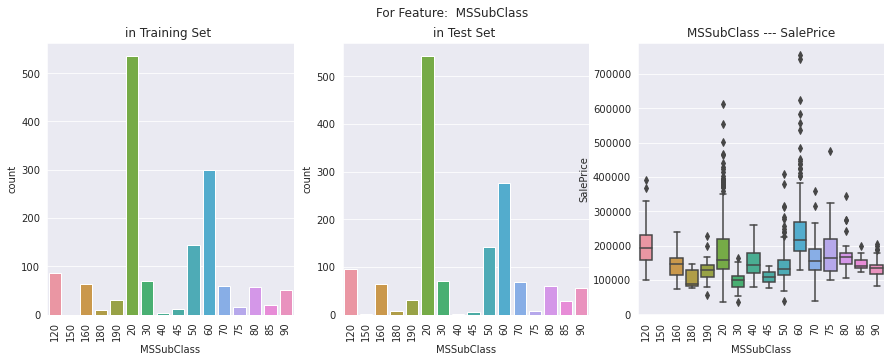

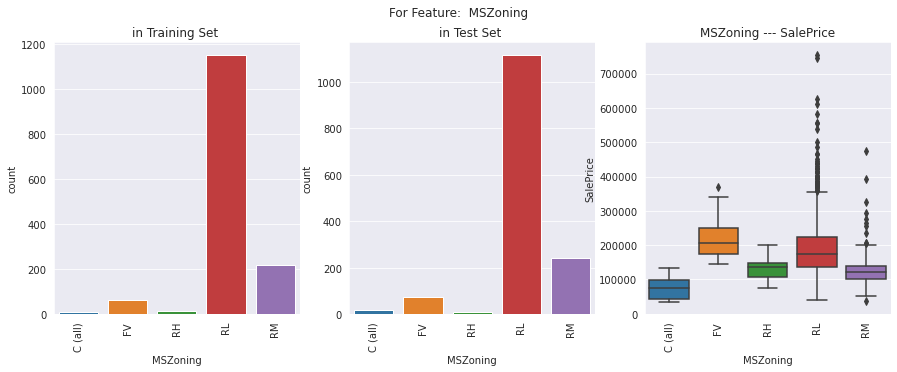

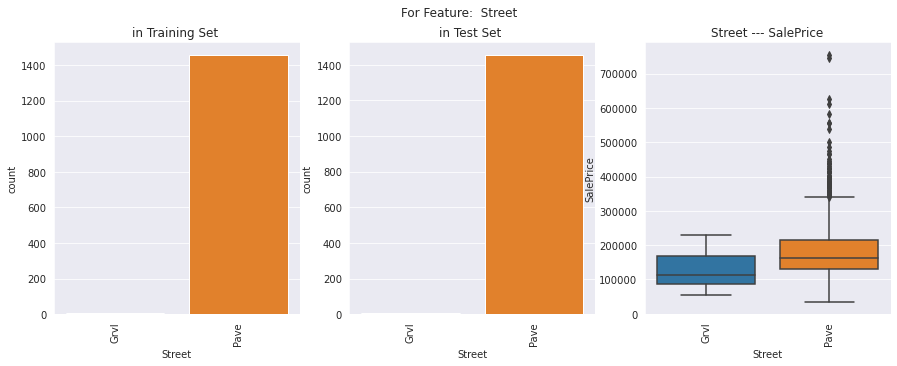

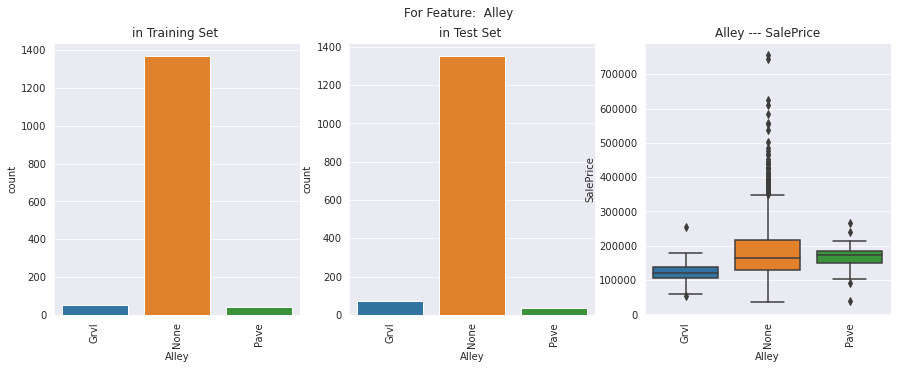

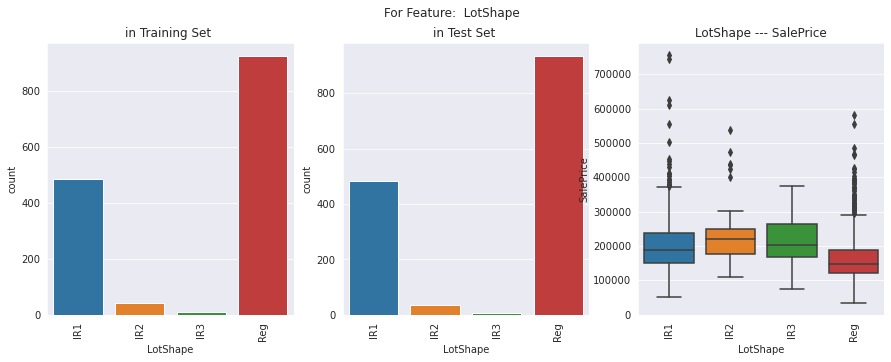

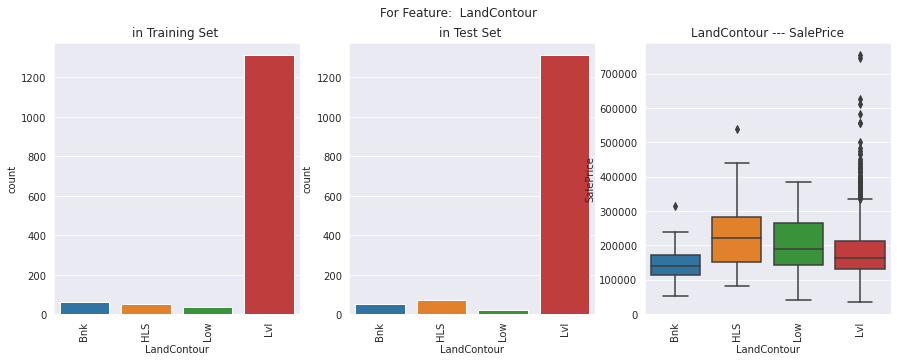

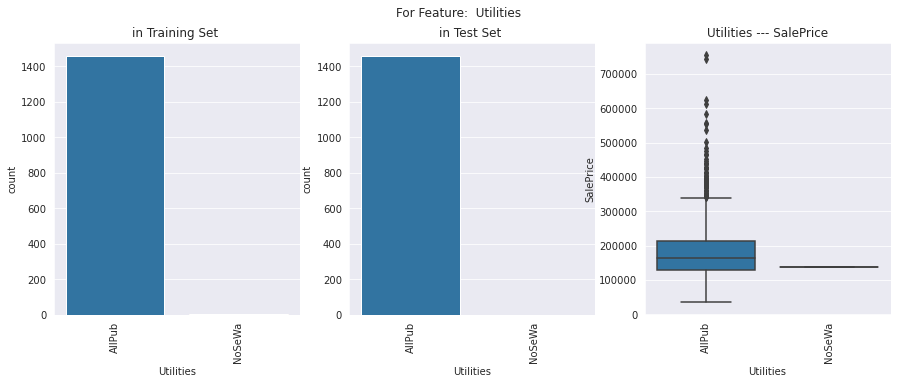

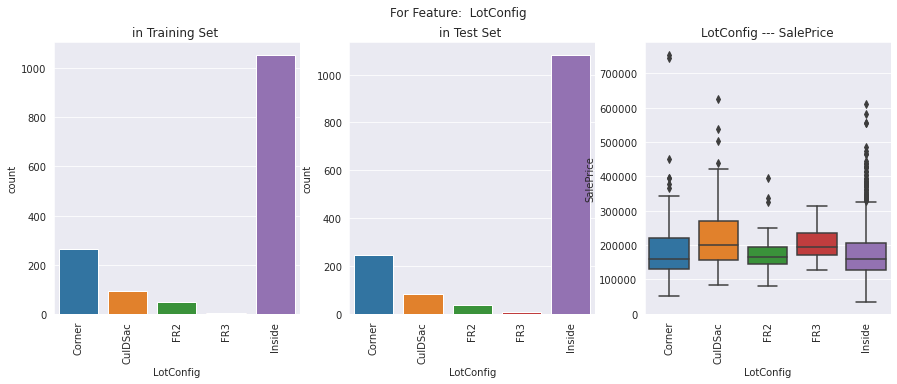

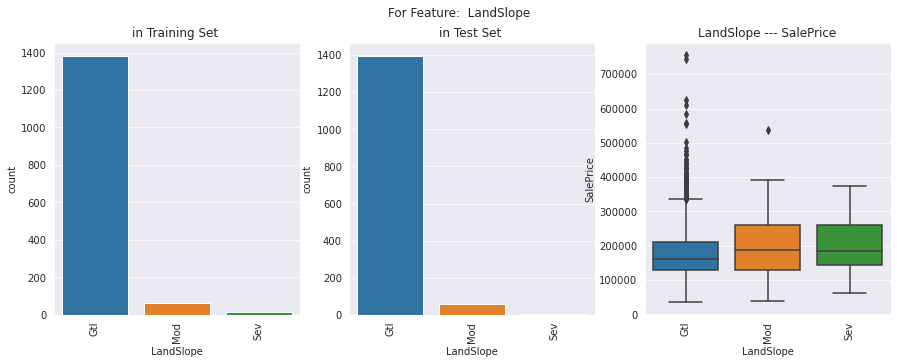

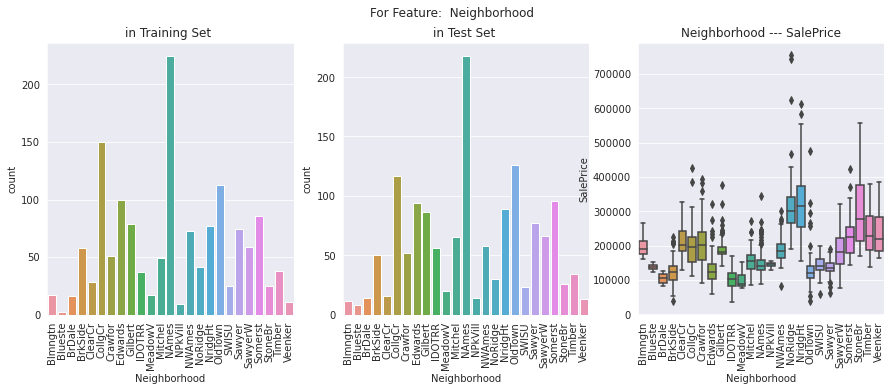

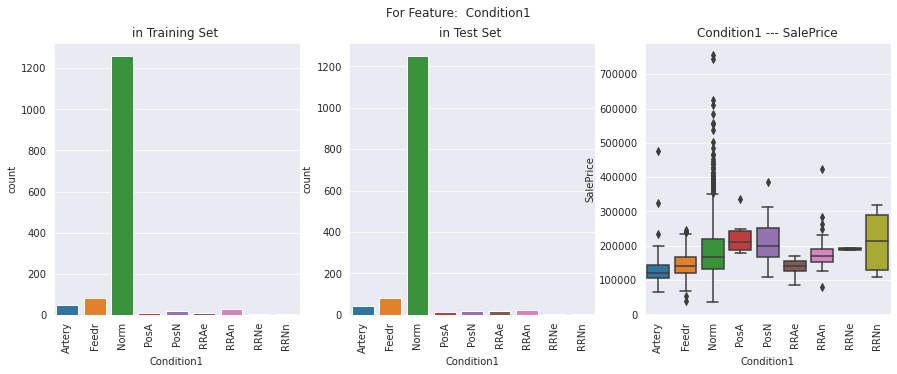

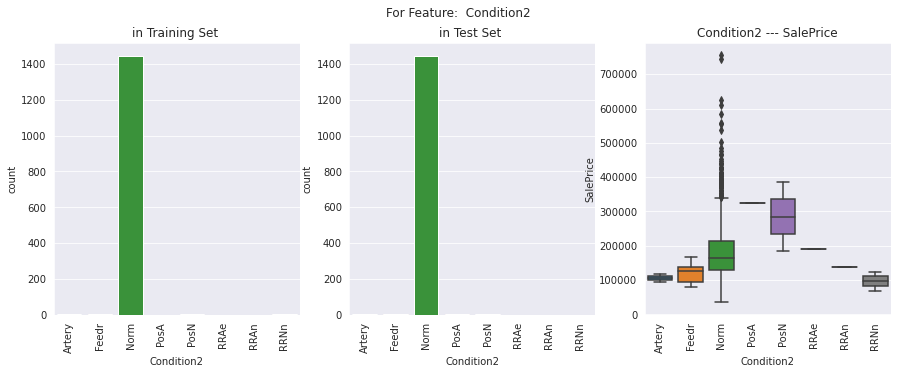

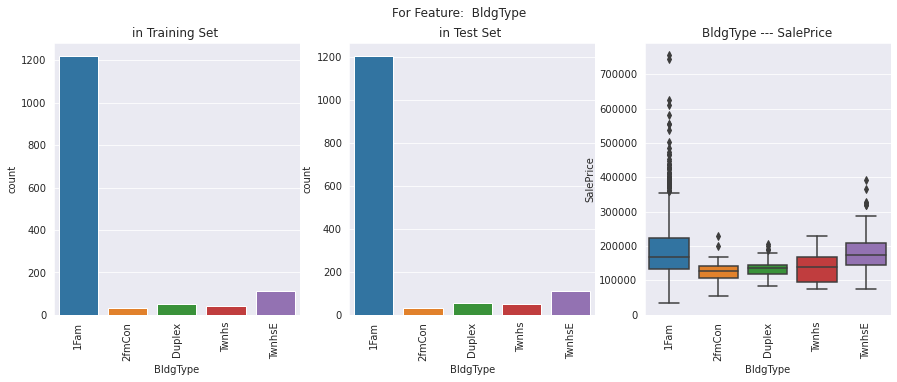

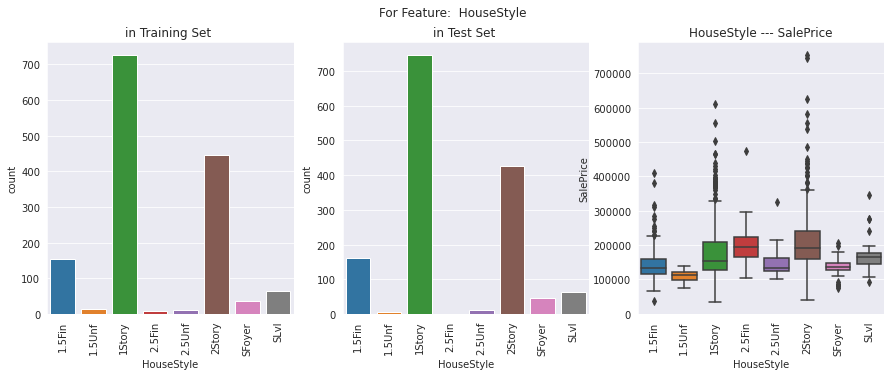

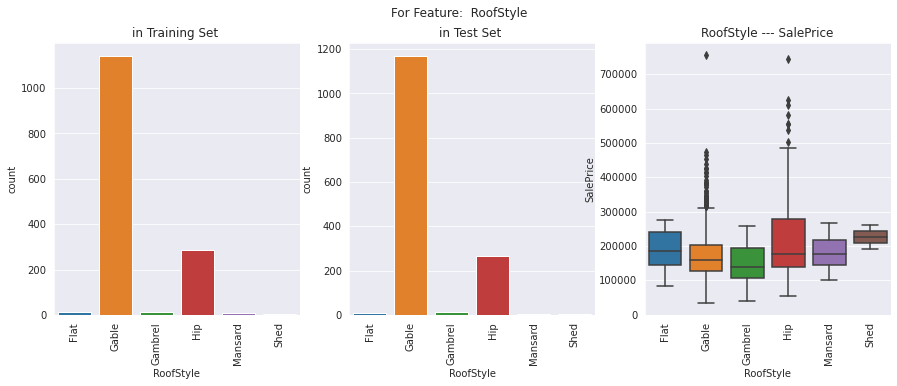

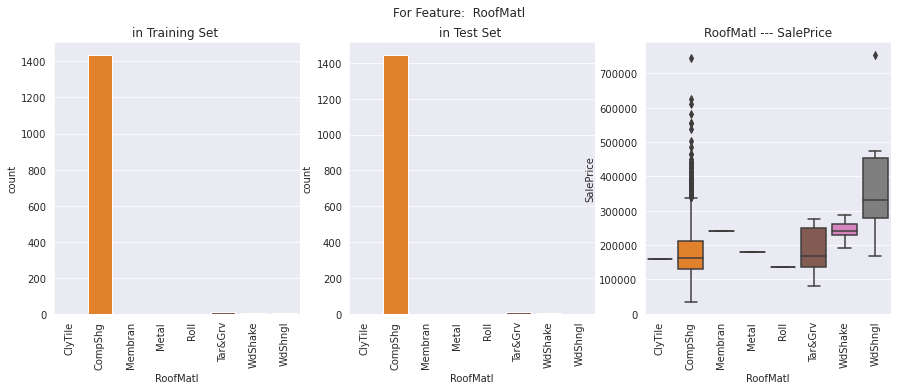

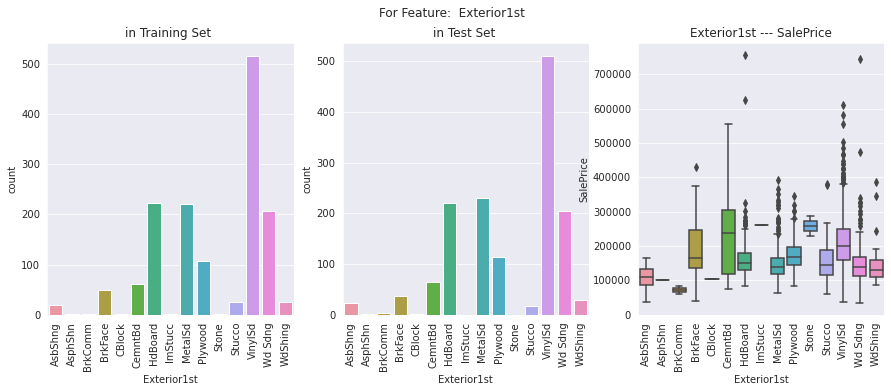

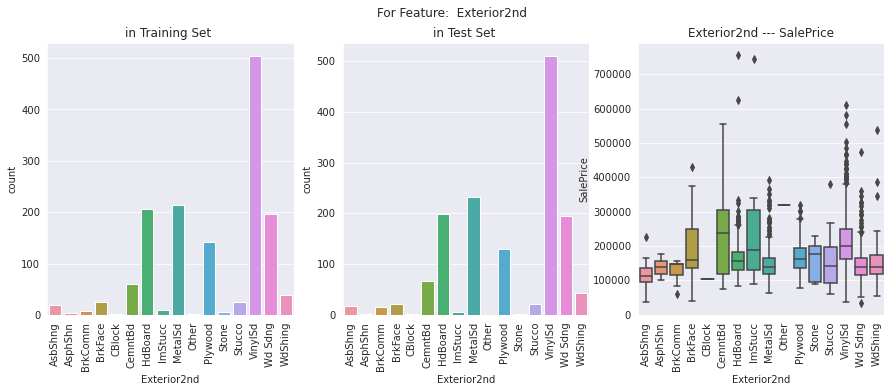

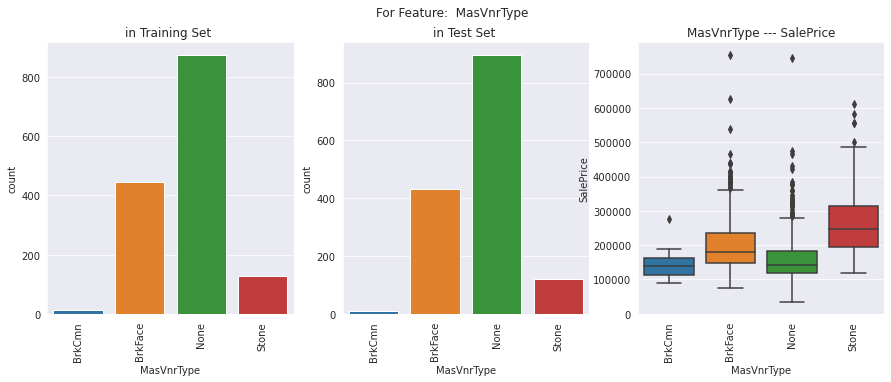

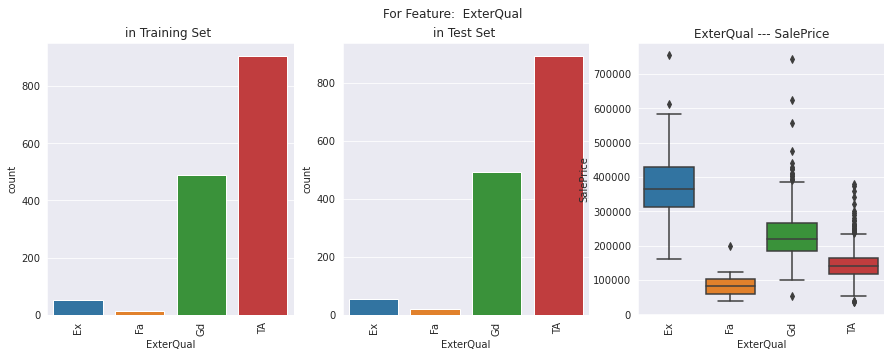

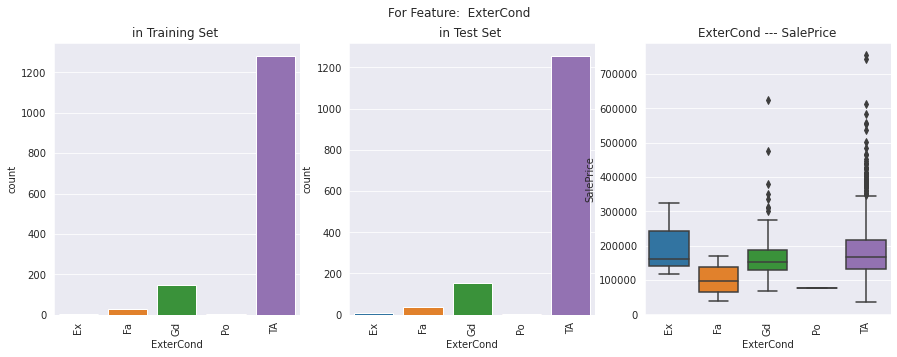

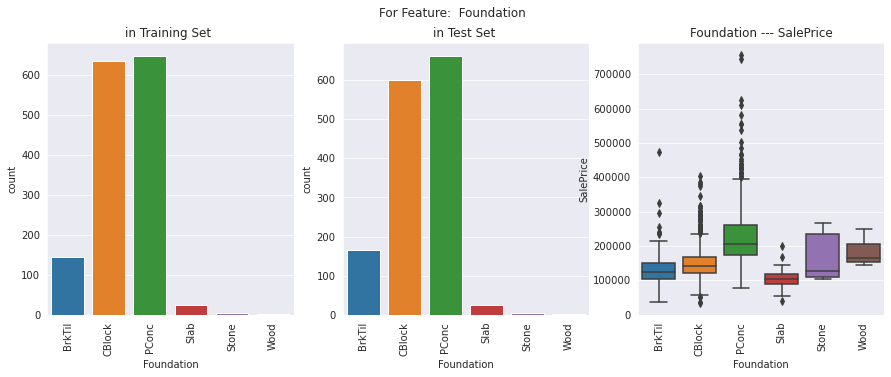

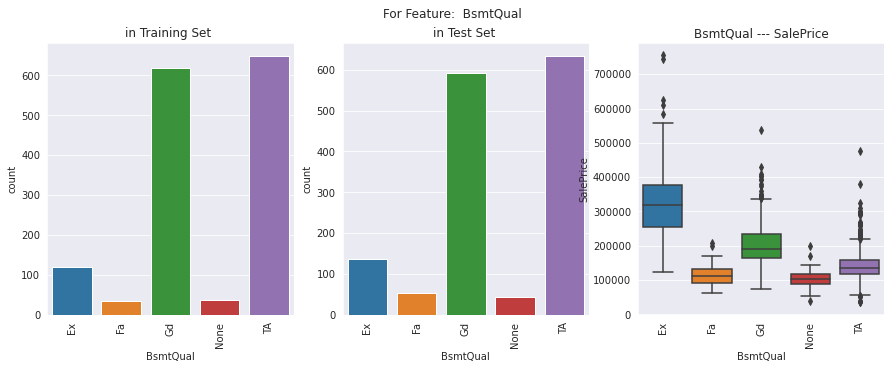

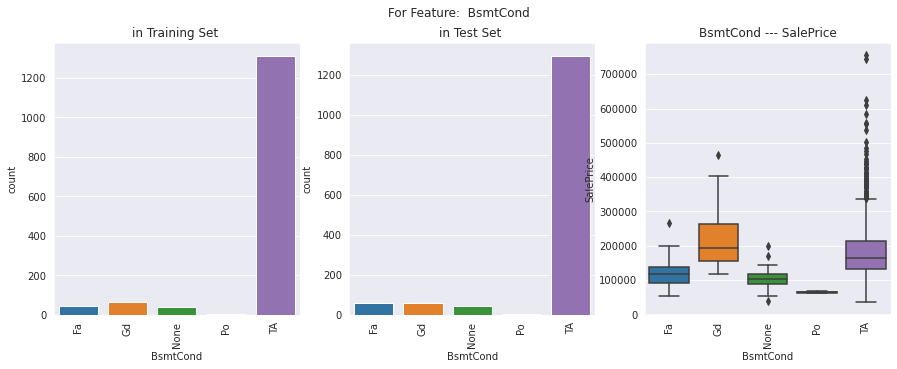

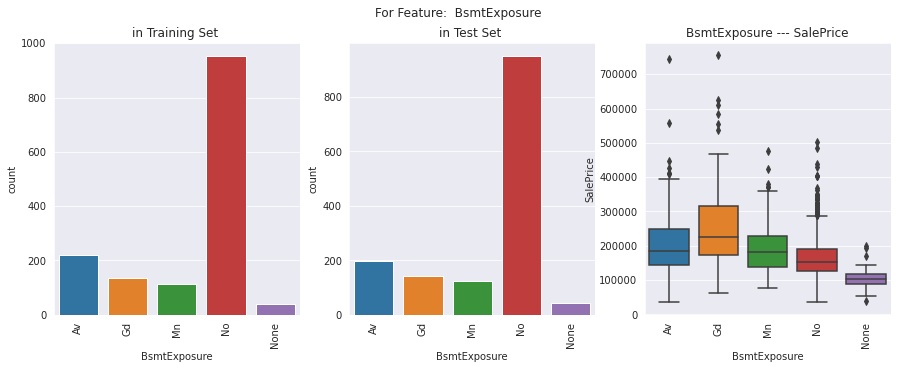

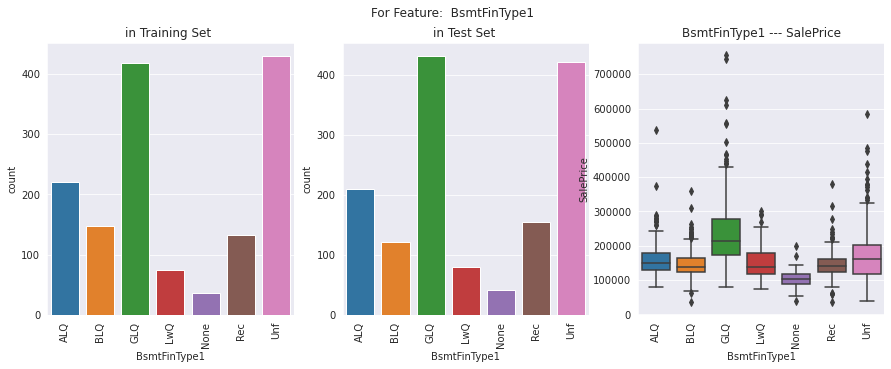

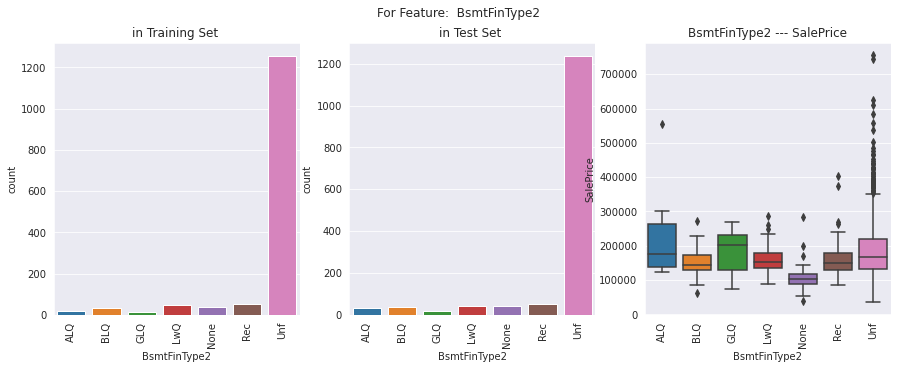

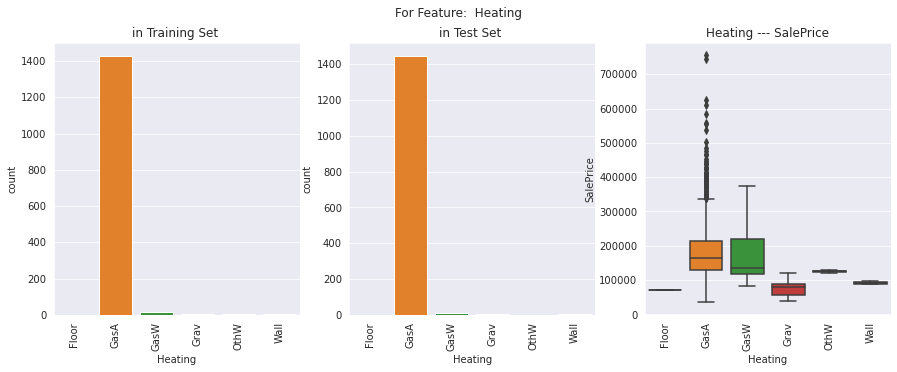

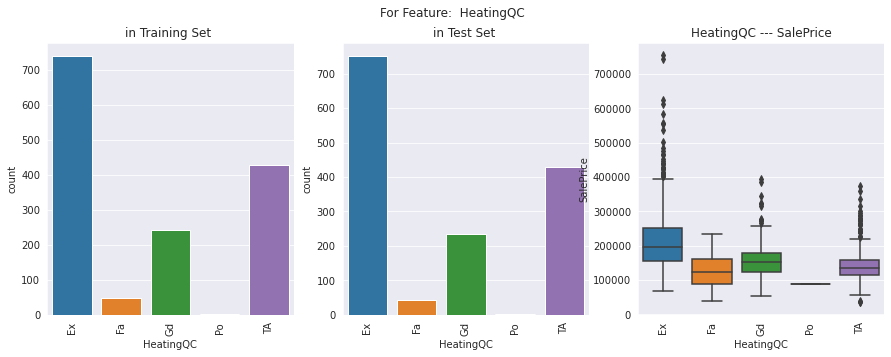

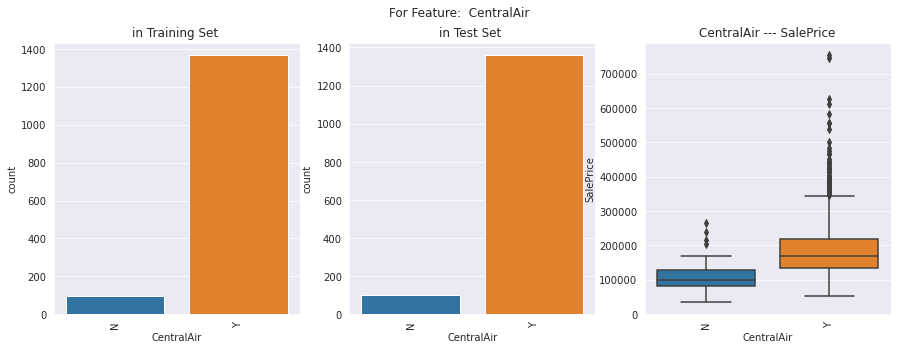

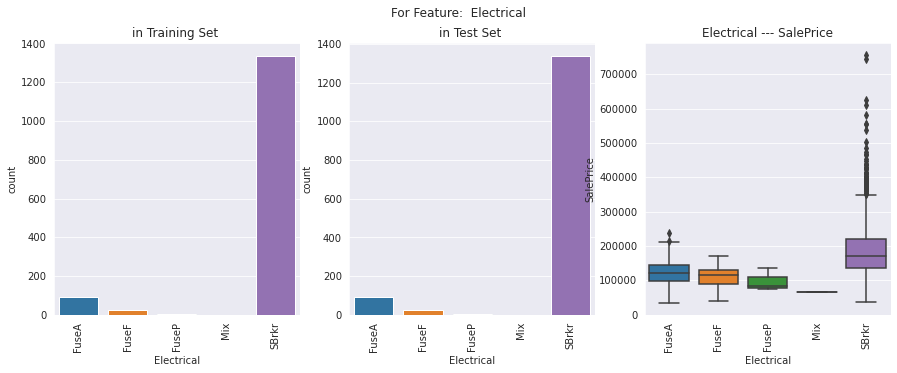

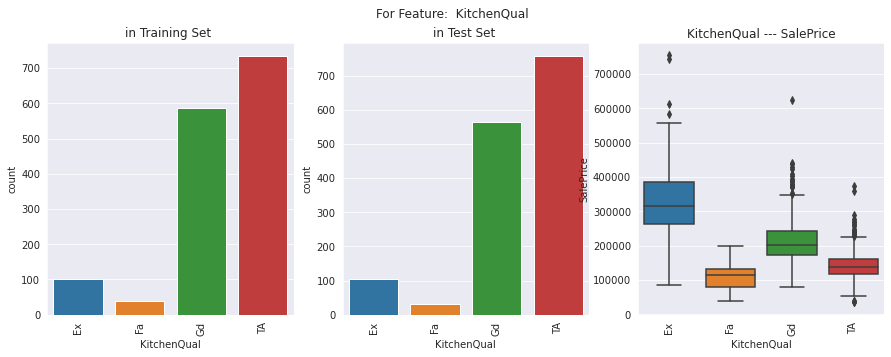

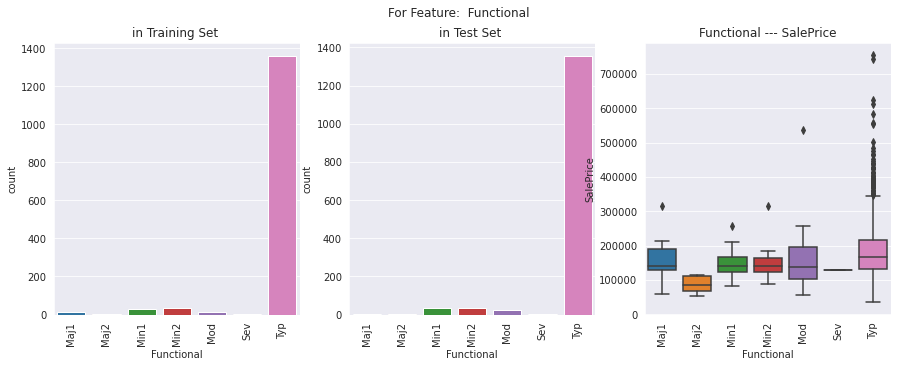

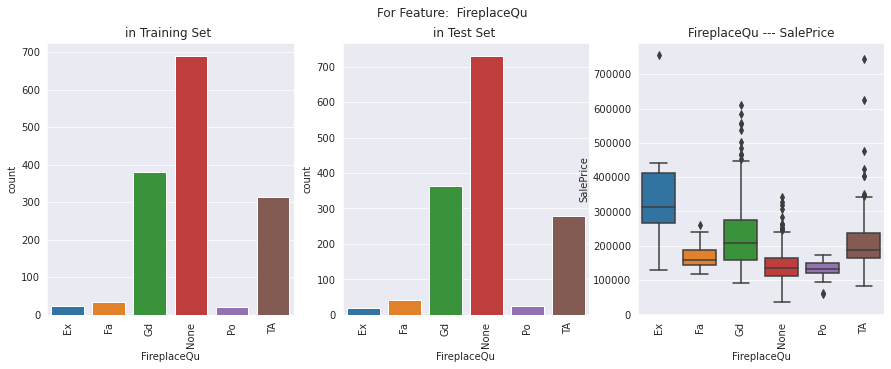

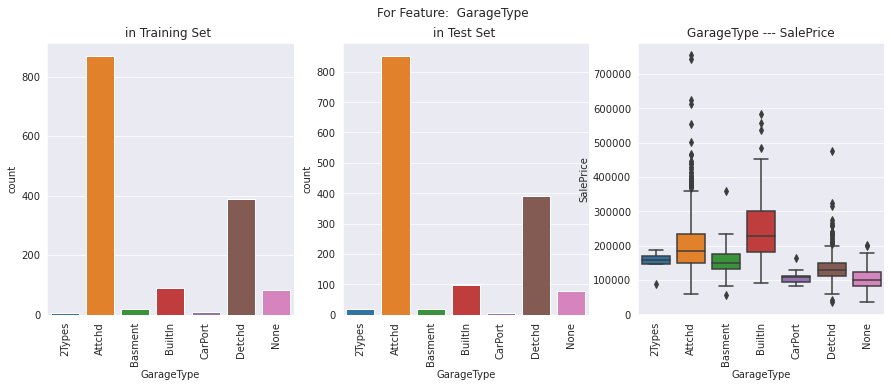

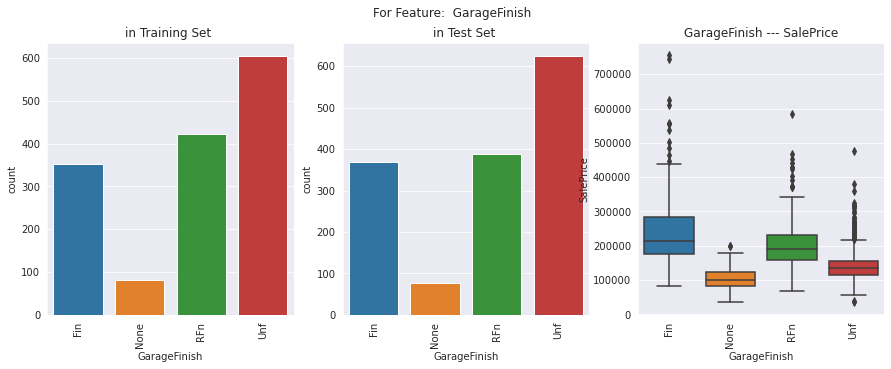

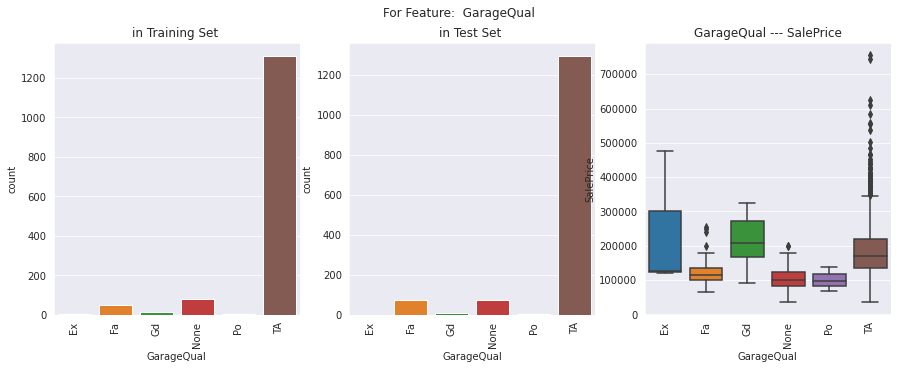

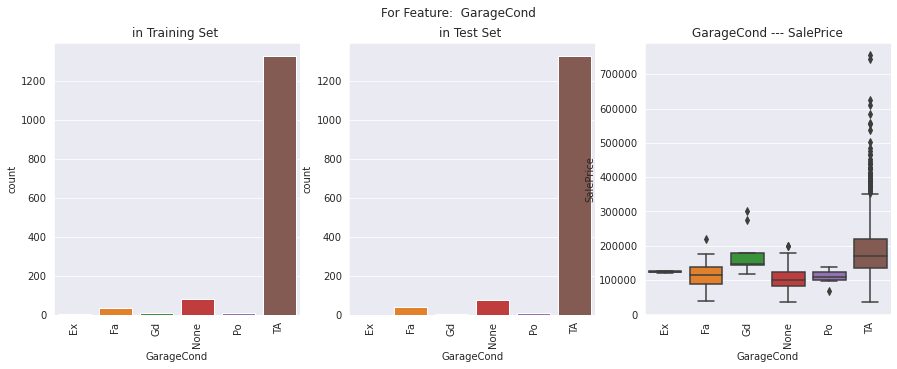

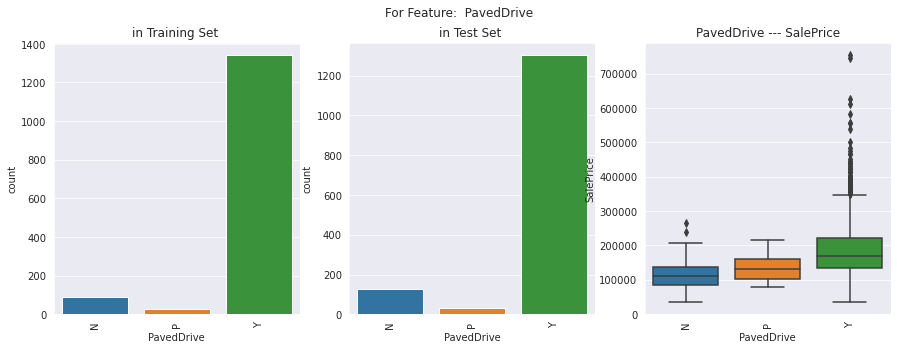

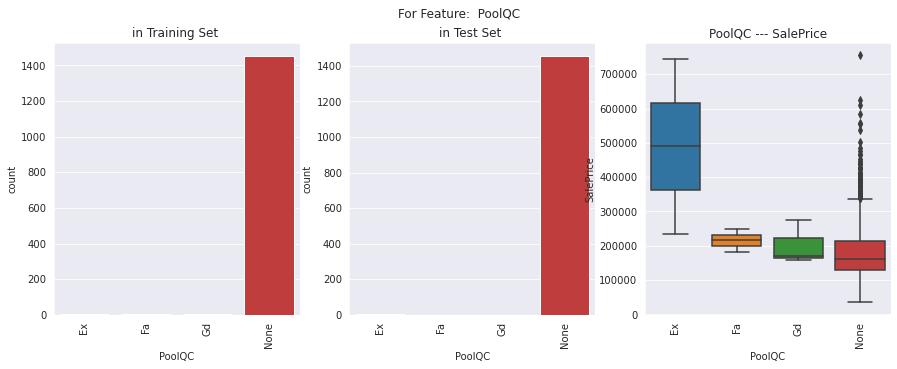

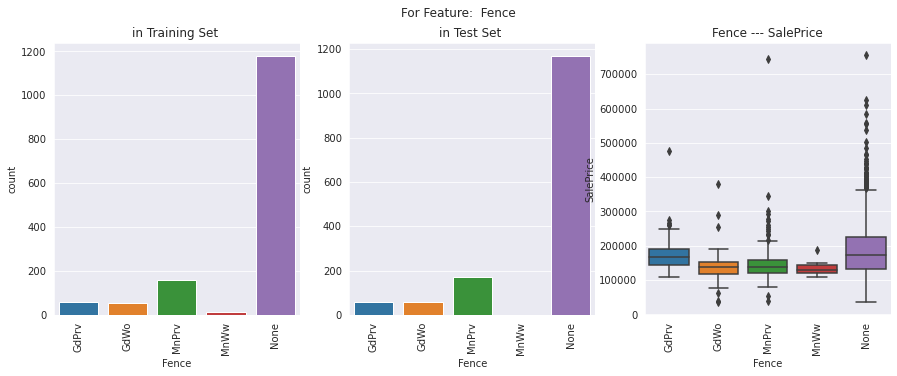

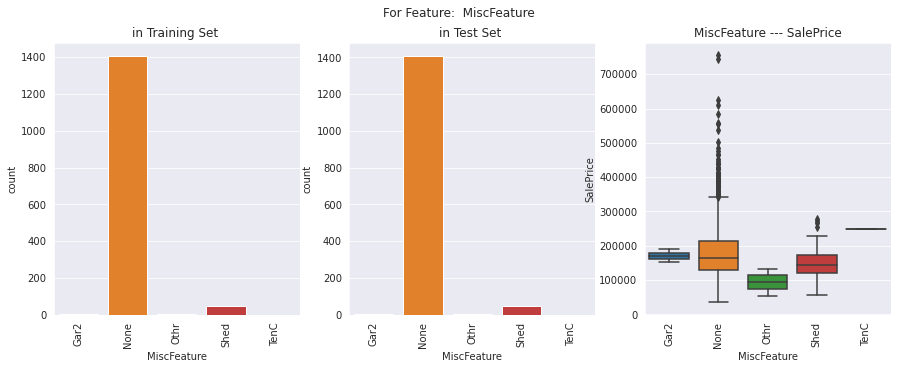

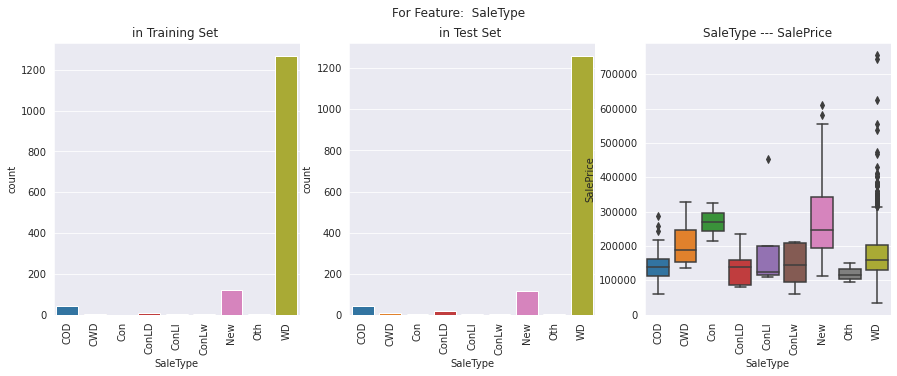

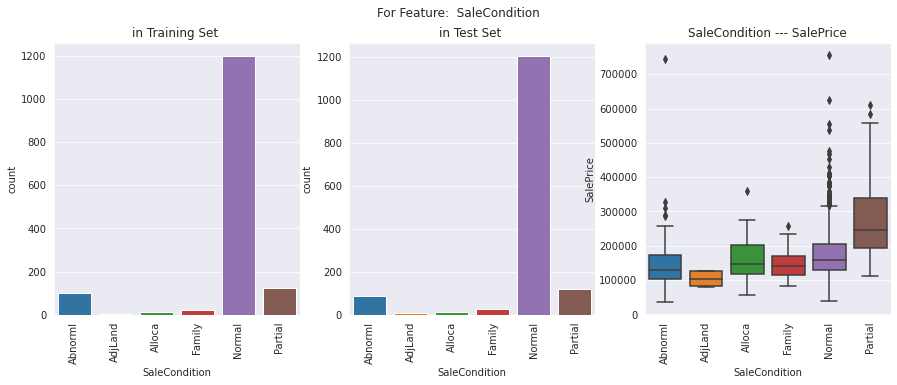

In [45]:
for col in cat_cols:
    bar_box(dff, col)

In [46]:
dff[cat_cols]

MSSubClass MSZoning Street Alley LotShape LandContour Utilities  \
0            60       RL   Pave  None      Reg         Lvl    AllPub   
1            20       RL   Pave  None      Reg         Lvl    AllPub   
2            60       RL   Pave  None      IR1         Lvl    AllPub   
3            70       RL   Pave  None      IR1         Lvl    AllPub   
4            60       RL   Pave  None      IR1         Lvl    AllPub   
...         ...      ...    ...   ...      ...         ...       ...   
1454        160       RM   Pave  None      Reg         Lvl    AllPub   
1455        160       RM   Pave  None      Reg         Lvl    AllPub   
1456         20       RL   Pave  None      Reg         Lvl    AllPub   
1457         85       RL   Pave  None      Reg         Lvl    AllPub   
1458         60       RL   Pave  None      Reg         Lvl    AllPub   

     LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType  \
0       Inside       Gtl      CollgCr       Norm       Norm     1Fam   
1          FR2       Gtl      Veenker      Feedr       Norm     1Fam   
2       Inside       Gtl      CollgCr       Norm       Norm     1Fam   
3       Corner       Gtl      Crawfor       Norm       Norm     1Fam   
4          FR2       Gtl      NoRidge       Norm       Norm     1Fam   
...        ...       ...          ...        ...        ...      ...   
1454    Inside       Gtl      MeadowV       Norm       Norm    Twnhs   
1455    Inside       Gtl      MeadowV       Norm       Norm   TwnhsE   
1456    Inside       Gtl      Mitchel       Norm       Norm     1Fam   
1457    Inside       Gtl      Mitchel       Norm       Norm     1Fam   
1458    Inside       Mod      Mitchel       Norm       Norm     1Fam   

     HouseStyle RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0        2Story     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1        1Story     Gable  CompShg     MetalSd     MetalSd       None   
2        2Story     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3        2Story     Gable  CompShg     Wd Sdng     WdShing       None   
4        2Story     Gable  CompShg     VinylSd     VinylSd    BrkFace   
...         ...       ...      ...         ...         ...        ...   
1454     2Story     Gable  CompShg     CemntBd     CemntBd       None   
1455     2Story     Gable  CompShg     CemntBd     CemntBd       None   
1456     1Story     Gable  CompShg     VinylSd     VinylSd       None   
1457     SFoyer     Gable  CompShg     HdBoard     WdShing       None   
1458     2Story     Gable  CompShg     HdBoard     HdBoard    BrkFace   

     ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0           Gd        TA      PConc       Gd       TA           No   
1           TA        TA     CBlock       Gd       TA           Gd   
2           Gd        TA      PConc       Gd       TA           Mn   
3           TA        TA     BrkTil       TA       Gd           No   
4           Gd        TA      PConc       Gd       TA           Av   
...        ...       ...        ...      ...      ...          ...   
1454        TA        TA     CBlock       TA       TA           No   
1455        TA        TA     CBlock       TA       TA           No   
1456        TA        TA     CBlock       TA       TA           No   
1457        TA        TA      PConc       Gd       TA           Av   
1458        TA        TA      PConc       Gd       TA           Av   

     BsmtFinType1 BsmtFinType2 Heating HeatingQC CentralAir Electrical  \
0             GLQ          Unf    GasA        Ex          Y      SBrkr   
1             ALQ          Unf    GasA        Ex          Y      SBrkr   
2             GLQ          Unf    GasA        Ex          Y      SBrkr   
3             ALQ          Unf    GasA        Gd          Y      SBrkr   
4             GLQ          Unf    GasA        Ex          Y      SBrkr   
...           ...          ...     ...       ...        ...        ...   
1454          Unf          Unf    GasA 

In [47]:
dff["Older1945"] = dff["MSSubClass"].apply(lambda x: 1 if x in ["30", "70"] else 0)

dff["Newer1946"] = dff["MSSubClass"].apply(lambda x: 1 if x in ["20", "60", "120", "160"] else 0)

dff["AllStyles"] = dff["MSSubClass"].apply(lambda x: 1 if x in ["20", "90", "190"] else 0)

dff["AllAges"] = dff["MSSubClass"].apply(lambda x: 1 if x in ["40", "45", "50", "75", "90", "150", "190"] else 0)

dff["Pud"] = dff["MSSubClass"].apply(lambda x: 1 if x in ["120", "150", "160", "180"] else 0)

dff["Split"] = dff["MSSubClass"].apply(lambda x: 1 if x in ["80", "85""180"] else 0)

dff["MSSubClass"] = dff["MSSubClass"].apply(lambda x: "180" if x == "150" else x)

In [48]:
# dff["Density"] = dff["MSZoning"].apply(lambda x: 1 if x in ["RL", "RP"] else (2 if x in ["RM", "RH"] else 0))

dff["MSZoning"] = dff["MSZoning"].apply(lambda x: "R" if x.startswith("R") else x)

These are just an example of using external data on feature engineering. If you can use external data on feature engineering you should always try it.

In [49]:
dff["North"] = dff["Neighborhood"].apply(lambda x: 1 if x in ["Blmngtn", "BrDale", "ClearCr", "Gilbert",  "Names", "NoRidge", 
                                                              "NPkVill", "NWAmes", "NoRidge", "NridgHt", "Sawyer", "Somerst", 
                                                              "StoneBr", "Veenker", "NridgHt"] else 0)

dff["South"] = dff["Neighborhood"].apply(lambda x: 1 if x in ["Blueste", "Edwards", "Mitchel", "MeadowV", 
                                                              "SWISU", "IDOTRR", "Timber"] else 0)

dff["Downtown"] = dff["Neighborhood"].apply(lambda x: 1 if x in ["BrkSide", "Crawfor", "OldTown", "CollgCr"] else 0)

dff["East"] = dff["Neighborhood"].apply(lambda x: 1 if x in ["IDOTRR", "Mitchel"] else 0)

dff["West"] = dff["Neighborhood"].apply(lambda x: 1 if x in ["Edwards", "NWAmes", "SWISU", "Sawyer", "SawyerW"] else 0)

In [50]:
dff.loc[(dff["Condition1"] == "Feedr") | (dff["Condition2"] == "Feedr"), "StreetDegree"] = 1
dff.loc[(dff["Condition1"] == "Artery") | (dff["Condition2"] == "Artery"), "StreetDegree"] = 2
dff["StreetDegree"].fillna(0, inplace = True)

dff.loc[(dff["Condition1"].isin(["RRNn", "RRNe"])) | (dff["Condition2"].isin(["RRNn", "RRNe"])), "RailroadDegree"] = 1
dff.loc[(dff["Condition1"].isin(["RRAn", "RRAe"])) | (dff["Condition2"].isin(["RRAn", "RRAe"])), "RailroadDegree"] = 2
dff["RailroadDegree"].fillna(0, inplace = True)

dff.loc[(dff["Condition1"] == "PosN") | (dff["Condition2"] == "PosN"), "OffsiteFeature"] = 1
dff.loc[(dff["Condition1"] == "PosA") | (dff["Condition2"] == "PosA"), "OffsiteFeature"] = 2
dff["OffsiteFeature"].fillna(0, inplace = True)

dff["Norm1"] = dff["Condition1"].apply(lambda x: 1 if x == "Norm" else 0)
dff["Norm2"] = dff["Condition2"].apply(lambda x: 1 if x == "Norm" else 0)
dff["Norm"] = dff["Norm1"] + dff["Norm2"]
dff.drop(["Norm1", "Norm2"], axis = 1, inplace = True)

In [51]:
lotshape = {"IR3": 1, "IR2": 2, "IR1": 3, "Reg": 4}
landcontour = {"Low":1, "HLS": 2, "Bnk":3, "Lvl": 4}
utilities = {"ELO": 1, "NoSeWa": 2, "NoSewr": 3, "AllPub": 4}
landslope = {"Sev": 1, "Mod": 2, "Gtl": 3}

general = {"None": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}

bsmtexposure = {"None": 0, "No": 0, "Mn": 1, "Av": 2, "Gd": 3}
bsmtfintype = {"None": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
electrical = {"Mix": 1, "FuseP": 2, "FuseF": 3, "FuseA": 4, "SBrkr": 5}
functional = {"Typ": 1, "Min1": 2, "Min2": 3, "Mod": 4, "Maj1": 5, "Maj2": 6, "Sev": 7, "Sal": 8}
garagefinish = {"None": 0, "Unf": 1, "RFn": 2, "Fin": 3}
fence = {"None": 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4}

dff.replace({"LotShape": lotshape, "LandContour": landcontour, "Utilities": utilities, "LandSlope": landslope, 
             "BsmtExposure": bsmtexposure, "BsmtFinType1": bsmtfintype, "BsmtFinType2":bsmtfintype, "Electrical": electrical, 
             "Functional": functional, "GarageFinish": garagefinish, "Fence": fence}, 
             inplace = True)

for col in ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "HeatingQC", "KitchenQual", 
            "FireplaceQu", "GarageQual", "GarageCond", "PoolQC"]:
    dff[col] = dff[col].replace(general)

For categorical features, some categories have less observations. We get a lot of dummy variables if we use one-hot encoding and that causes increase on data and maybe some infos get lost. To prevent this, combine categories that have same characteristics.

In [52]:
dff["BldgType"] = dff["BldgType"].apply(lambda x: "2Fam" if x in ["2fmCon", "Duplex"] else x)

dff["SaleType"] = dff["SaleType"].apply(lambda x: "WD" if x.endswith("WD") else x)
dff["SaleType"] = dff["SaleType"].apply(lambda x: "Contract" if x.startswith("Con") else x)
dff["SaleType"] = dff["SaleType"].apply(lambda x: "Oth" if x == "COD" else x)

dff["SaleCondition"] = dff["SaleCondition"].apply(lambda x: "Abnormal_Adjland" if x in ["Abnorml", "AdjLand"] else x)
dff["SaleCondition"] = dff["SaleCondition"].apply(lambda x: "Alloca_Family" if x in ["Alloca", "Family"] else x)
dff["SaleCondition"] = dff["SaleCondition"].apply(lambda x: "Other" if x in ["Abnormal_Adjland", "Alloca_Family"] else x)

dff["GarageType"] = dff["GarageType"].apply(lambda x: "Carport_None" if x in ["CarPort", "None"] else x)
dff["GarageType"] = dff["GarageType"].apply(lambda x: "Basement_2Types" if x in ["Basment", "2Types"] else x)

dff["LotConfig"] = dff["LotConfig"].apply(lambda x: "CulDSac_FR3" if x in ["CulDSac", "FR3"] else x)

dff["RoofStyle"] = dff["RoofStyle"].apply(lambda x: "Other" if x not in ["Gable"] else x)
dff["RoofMatl"] = dff["RoofMatl"].apply(lambda x: "Other" if x != "CompShg" else x)
dff["MasVnrType"] = dff["MasVnrType"].apply(lambda x: "None_BrkCmn" if x in ["None", "BrkCmn"] else x)

dff["Foundation"] = dff["Foundation"].apply(lambda x: "BrkTil_Stone" if x in ["BrkTil", "Stone"] else x)
dff["Foundation"] = dff["Foundation"].apply(lambda x: "BrkTil_Stone_Slab" if x in ["BrkTil_Stone", "Slab"] else x)
dff["Foundation"] = dff["Foundation"].apply(lambda x: "PConc_Wood" if x in ["PConc", "Wood"] else x)

dff["Heating"] = dff["Heating"].apply(lambda x: "Other" if x != "GasA" else x)

# 3.2 For Numerical Features
Creating features with using feature interactions, creating binary features, new features with using ordinal ones

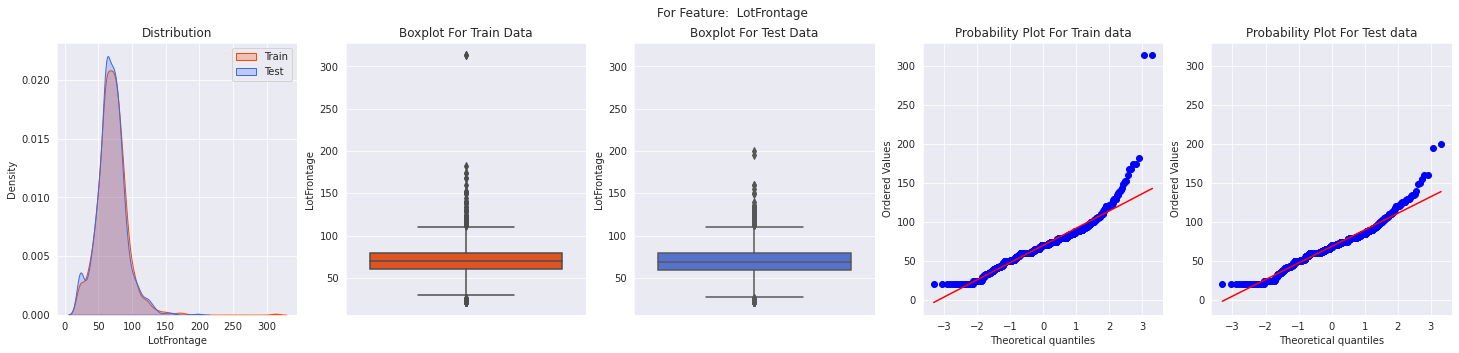

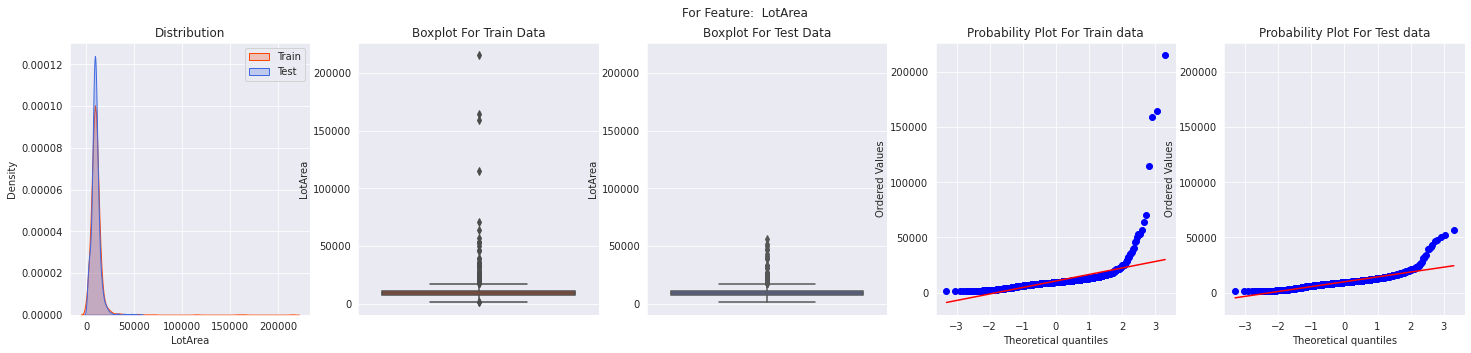

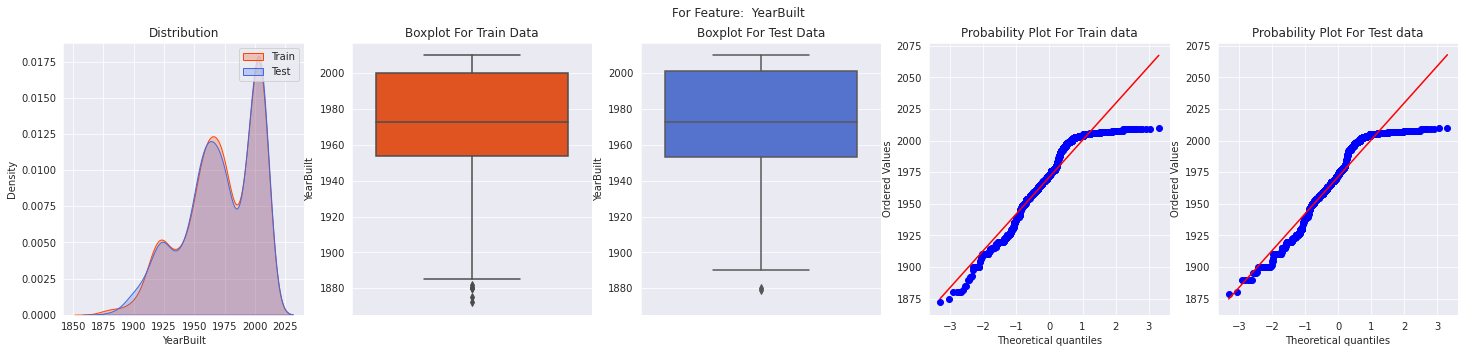

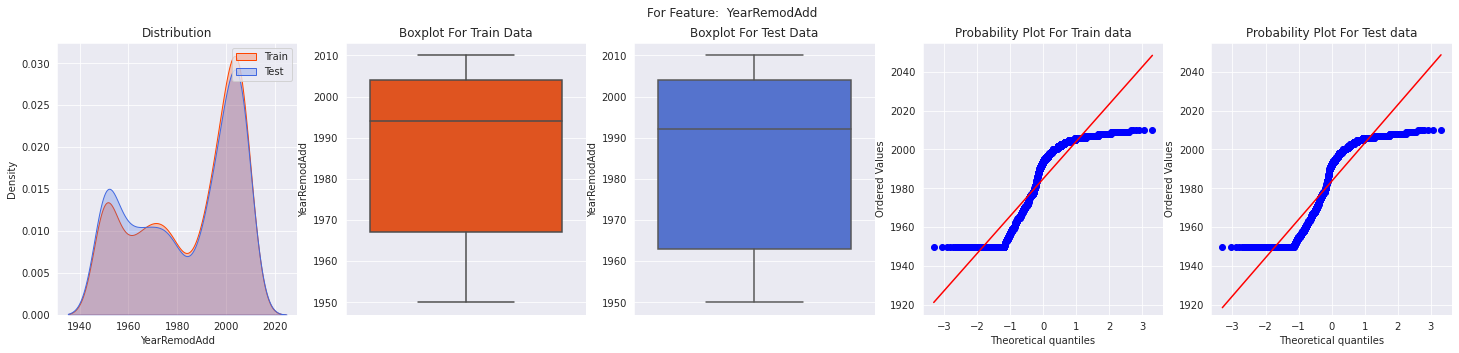

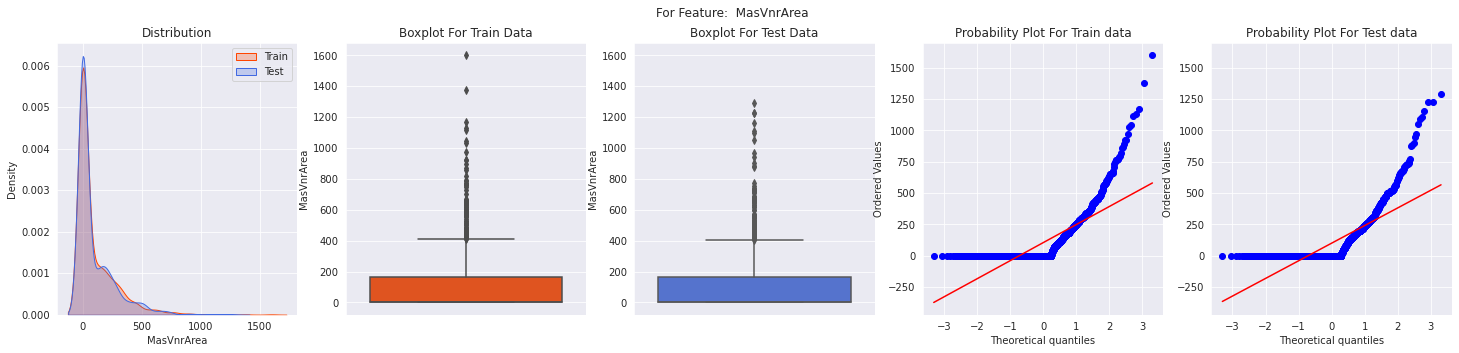

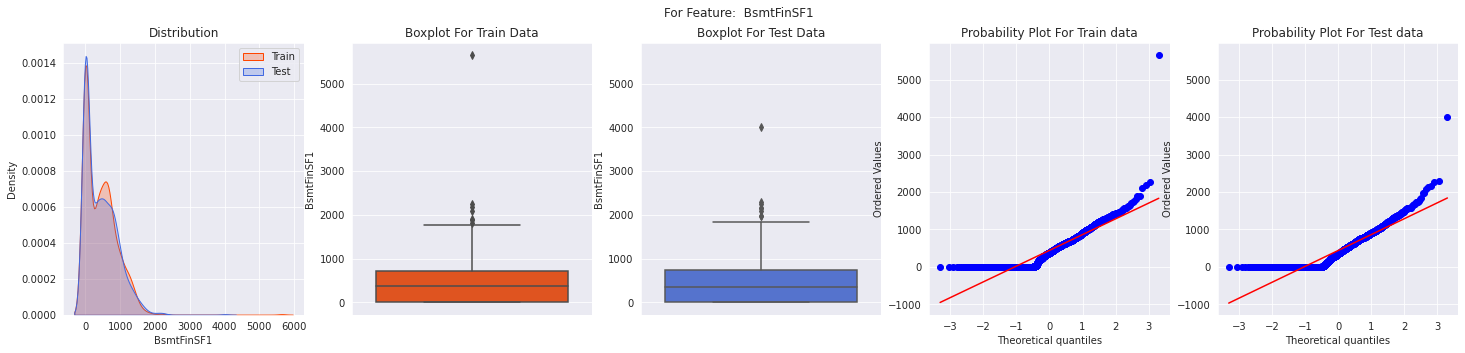

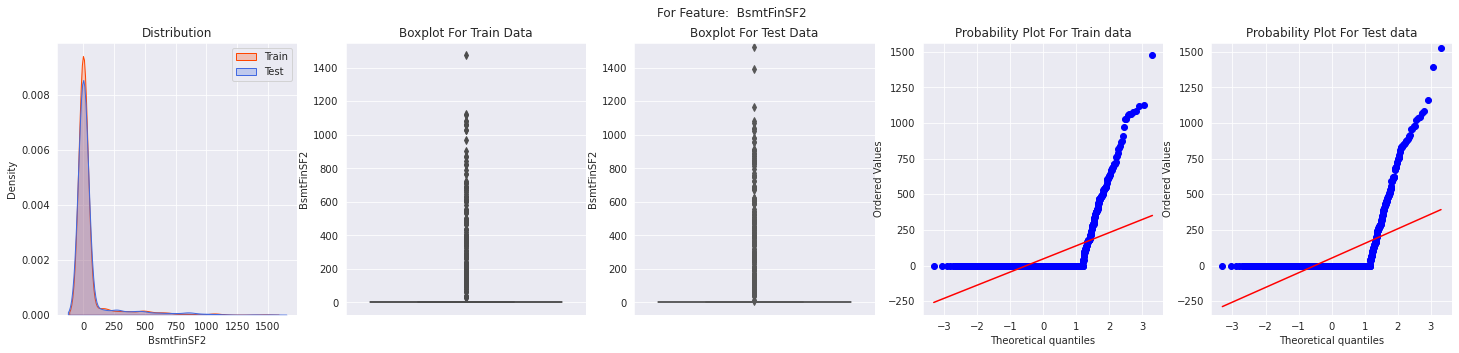

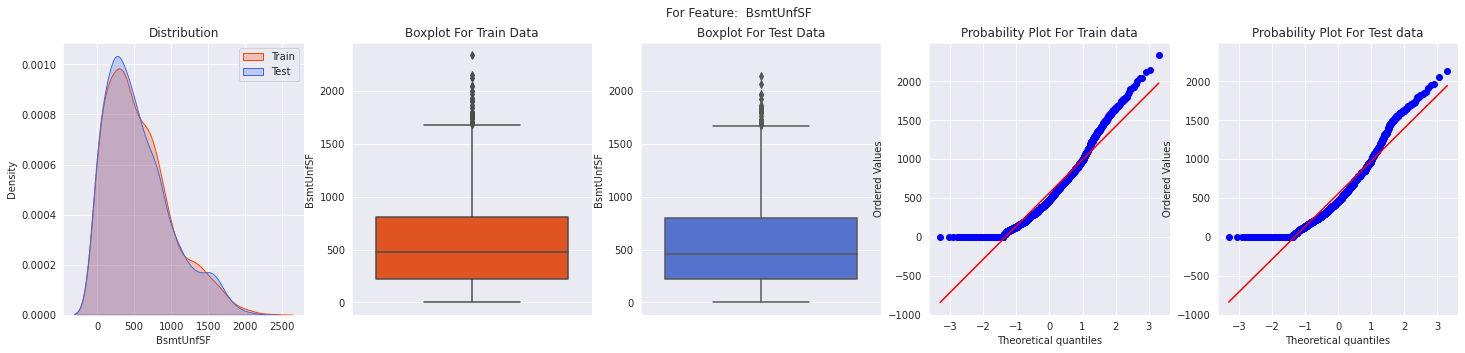

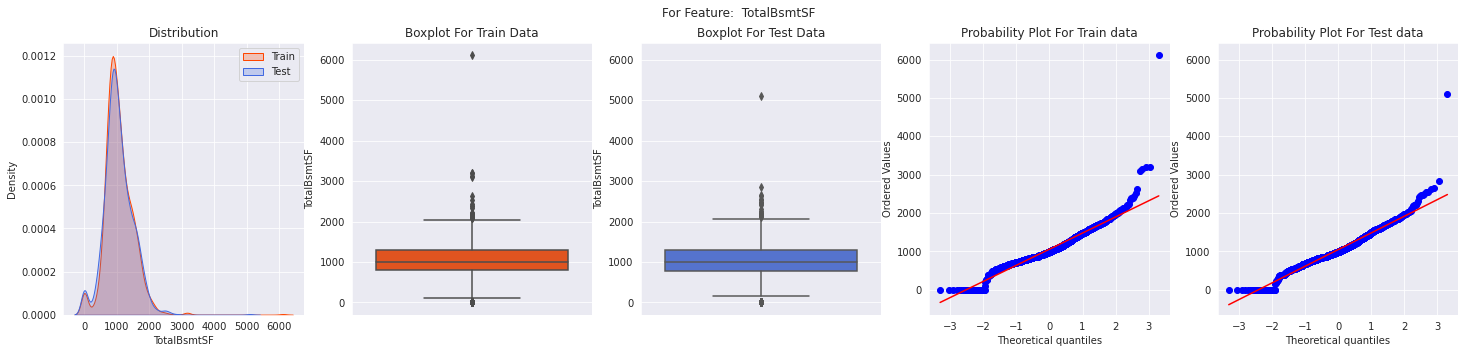

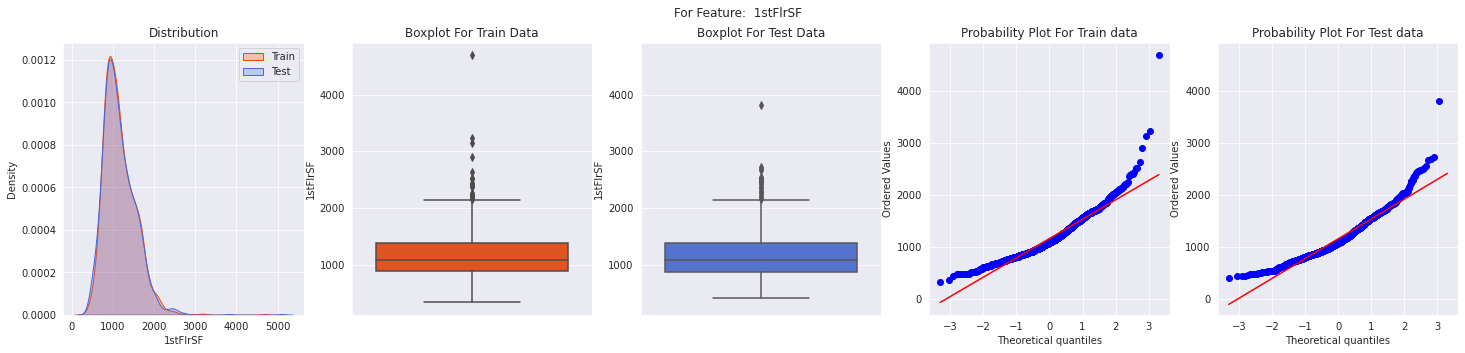

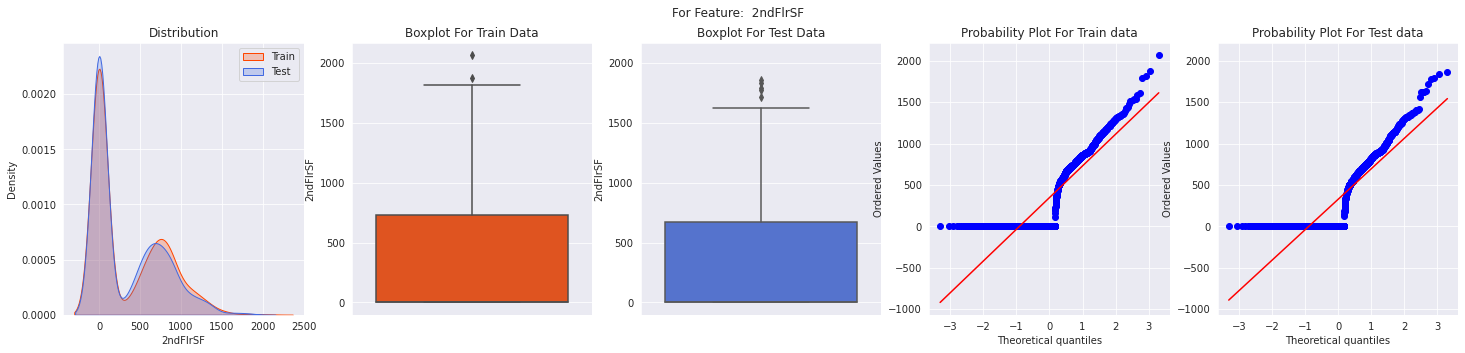

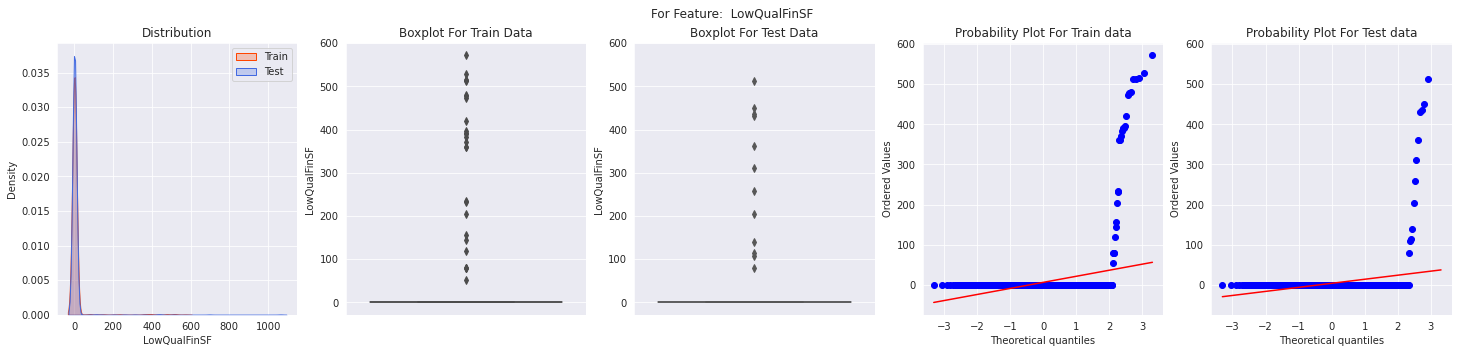

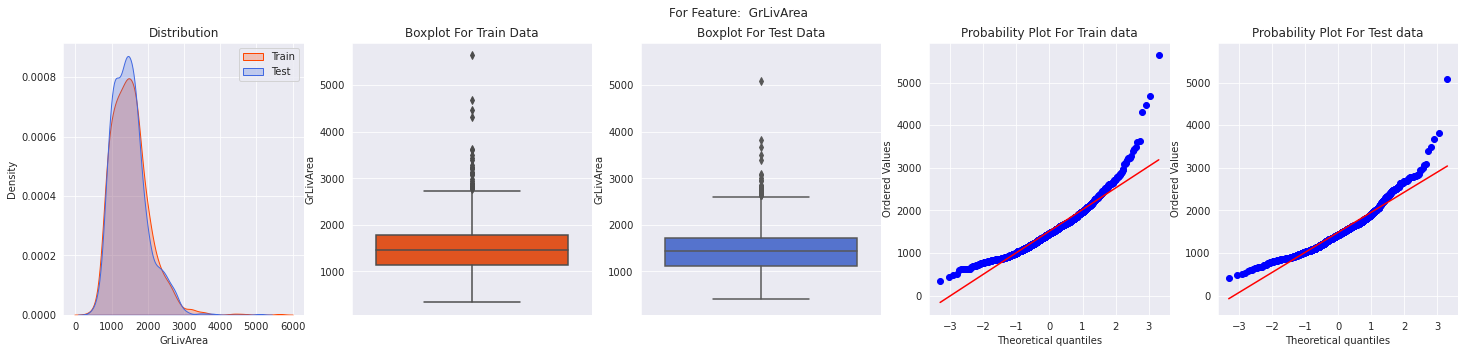

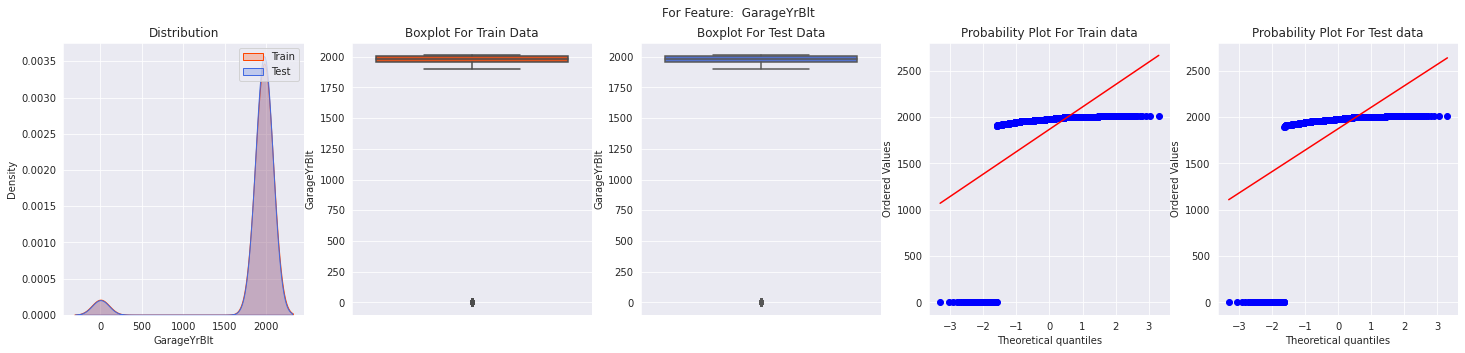

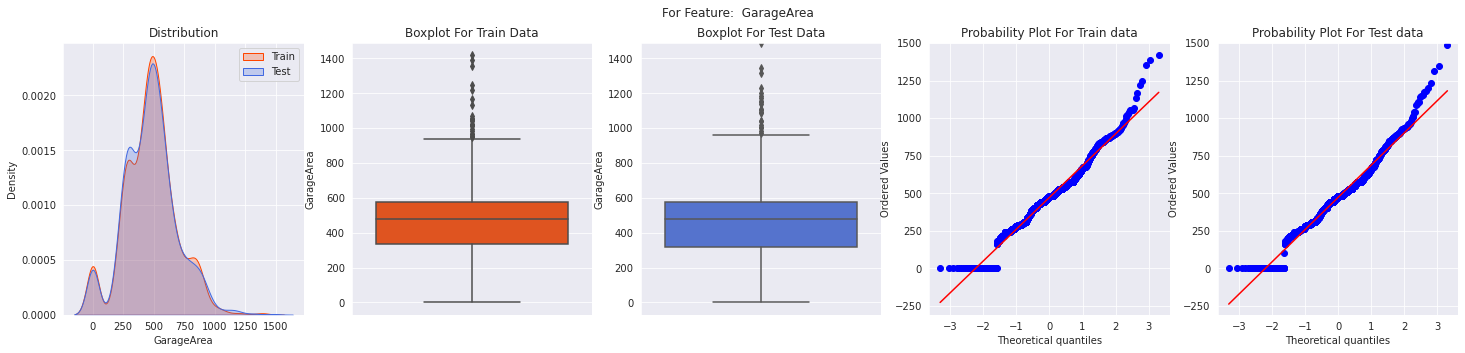

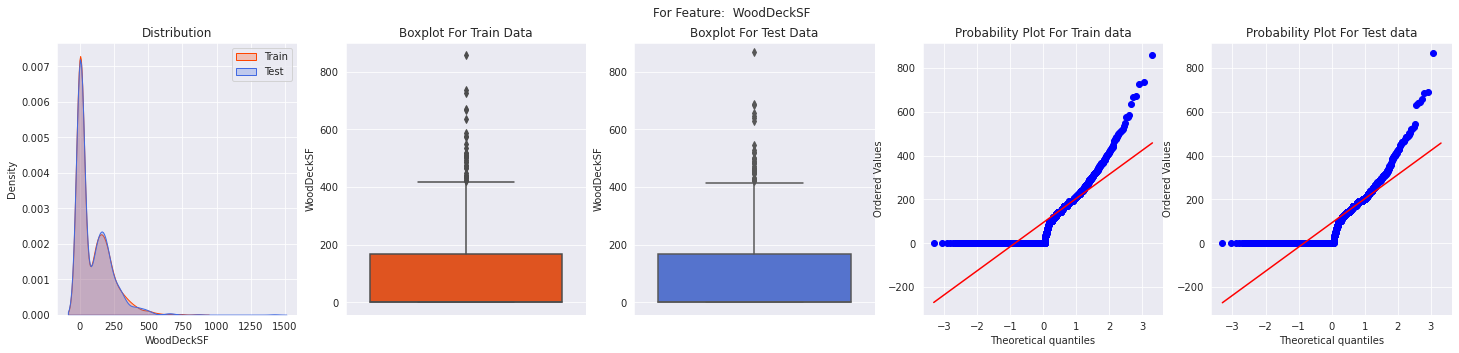

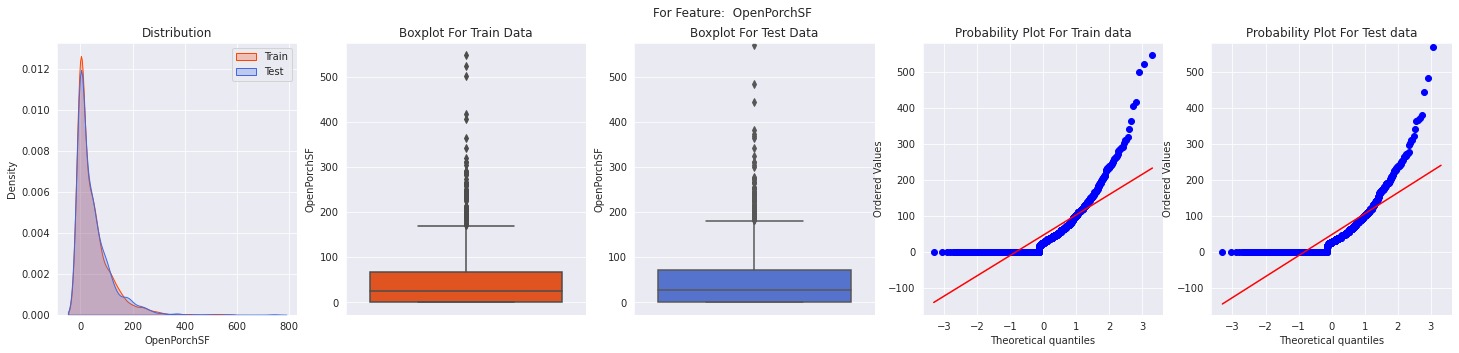

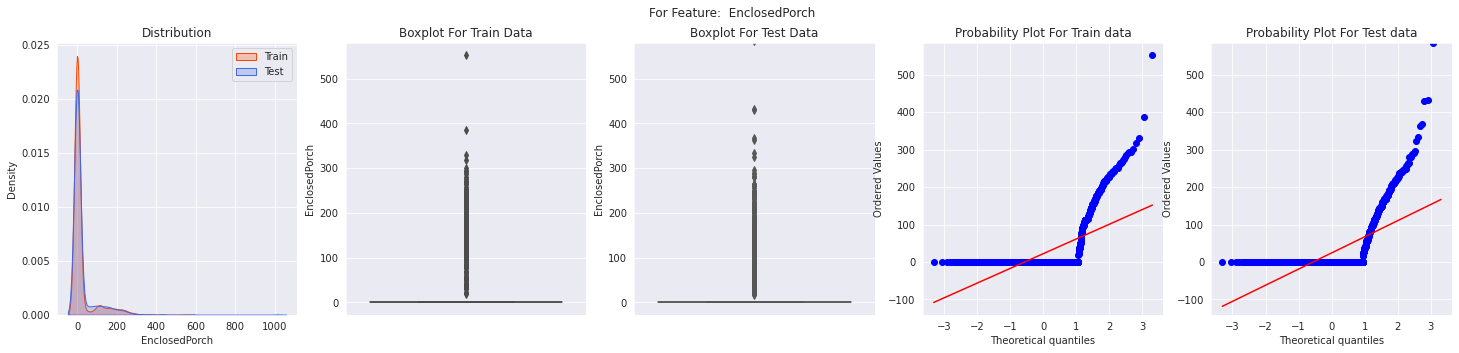

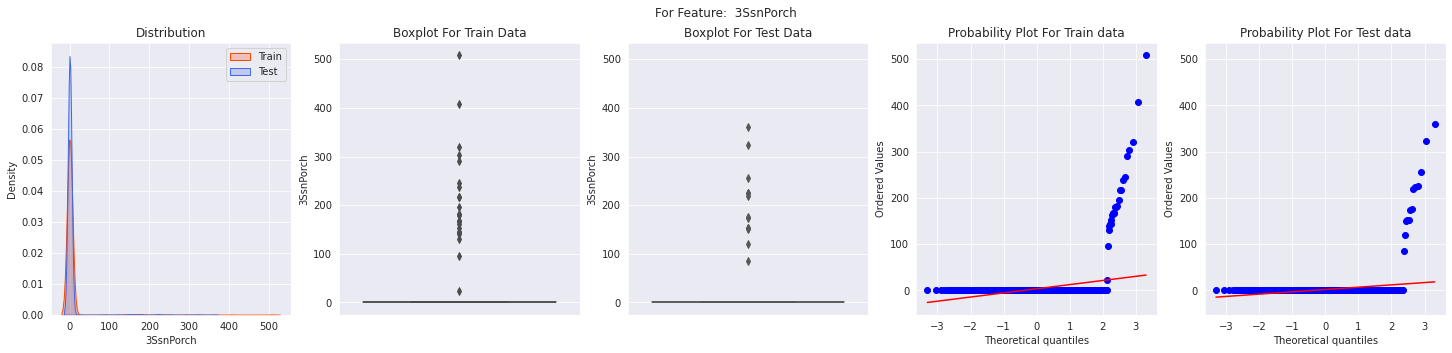

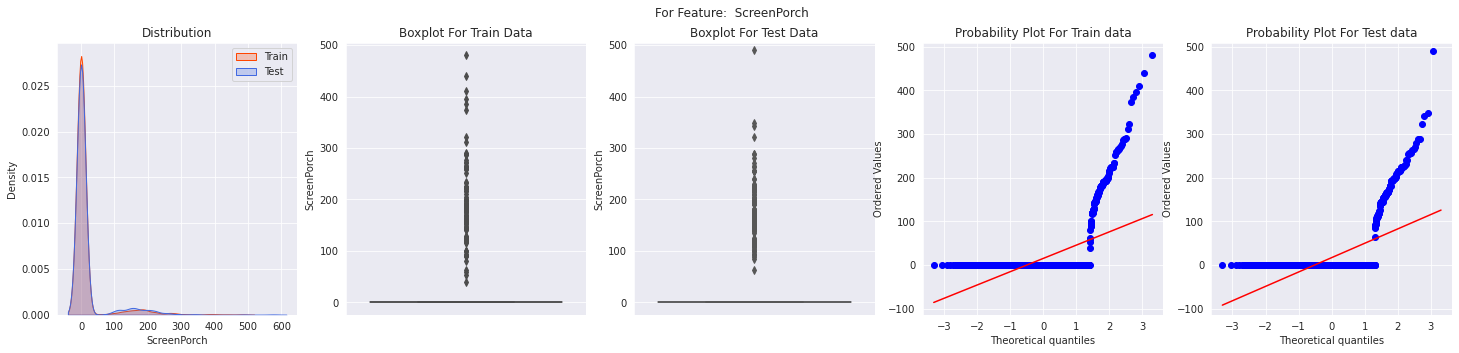

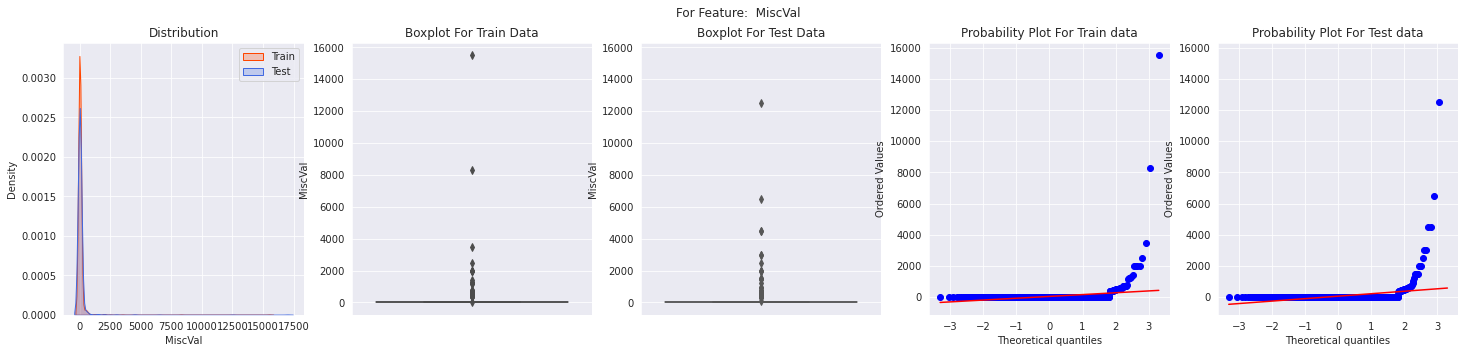

In [53]:
for col in num_cols:
    feature_distribution(dff, col)

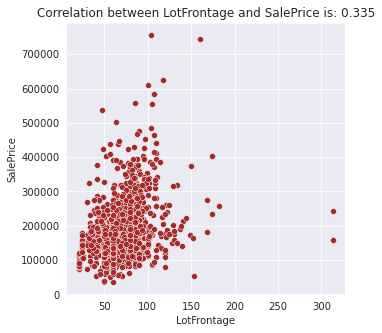

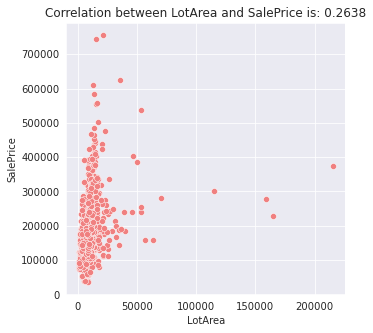

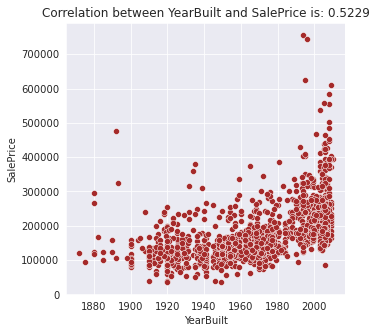

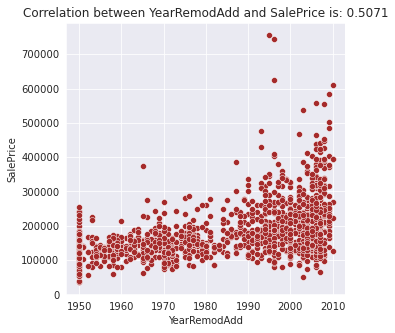

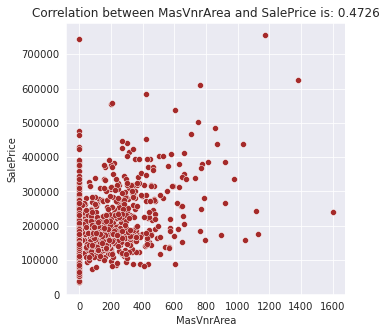

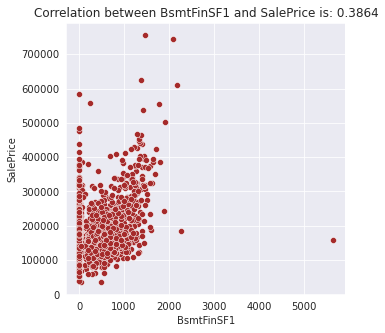

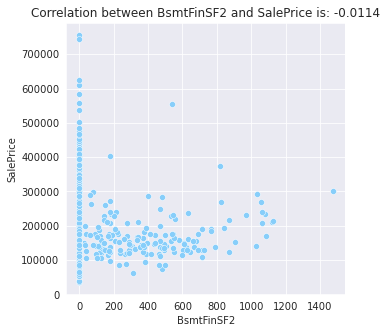

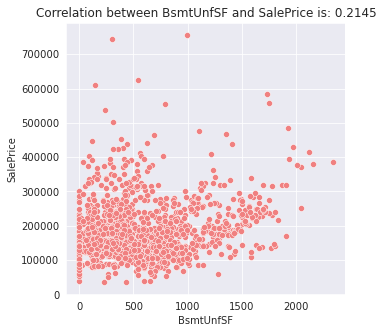

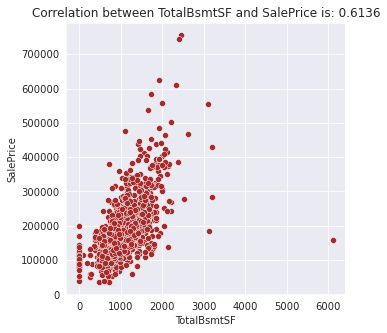

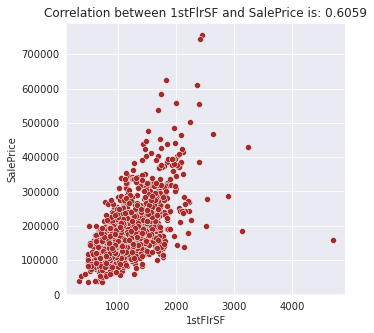

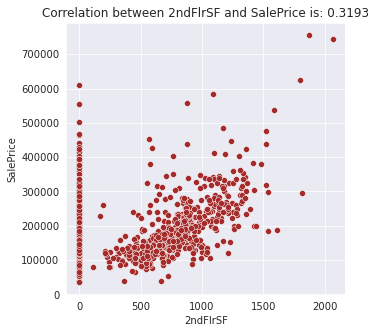

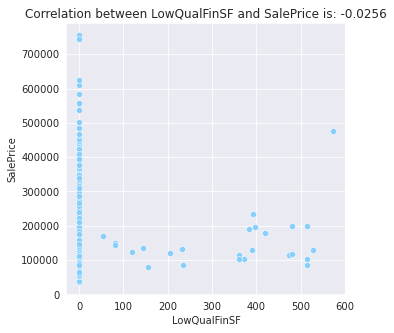

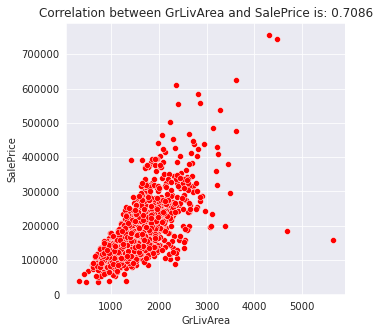

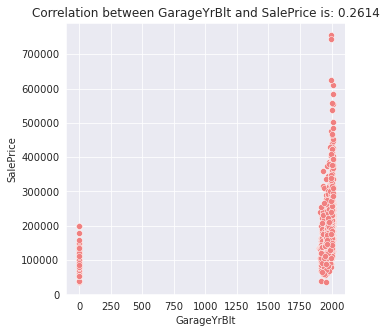

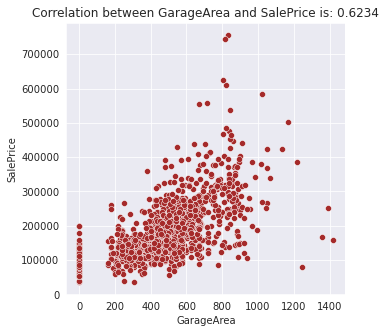

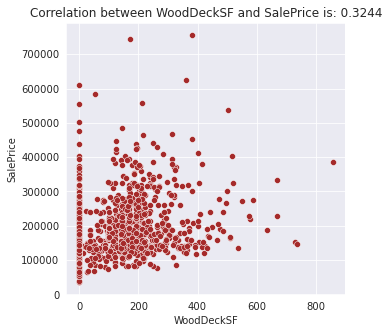

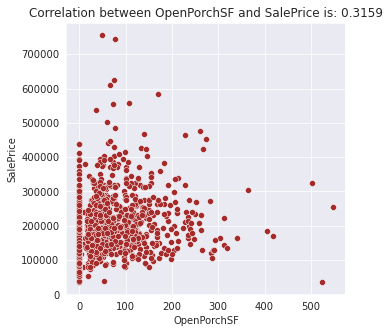

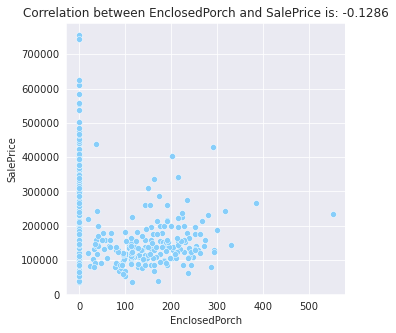

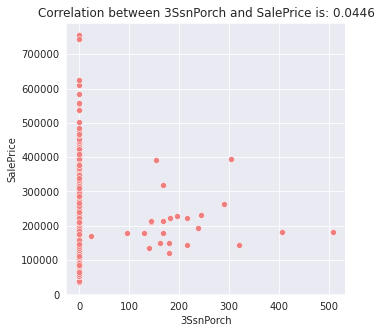

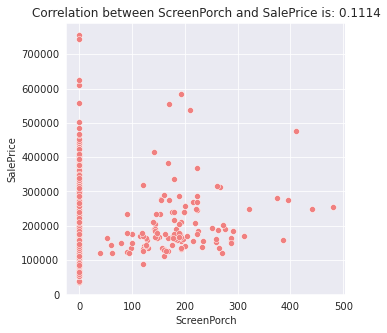

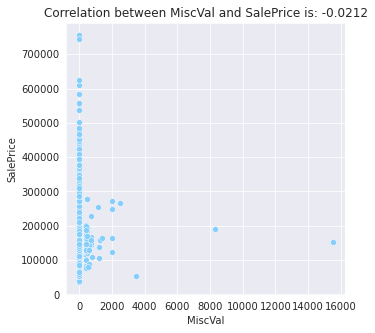

In [54]:
for col in num_cols:
    plot_scatter(dff, col)

In [55]:
dff[num_cols]

LotFrontage  LotArea  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  \
0            65.0     8450       2003          2003       196.0       706.0   
1            80.0     9600       1976          1976         0.0       978.0   
2            68.0    11250       2001          2002       162.0       486.0   
3            60.0     9550       1915          1970         0.0       216.0   
4            84.0    14260       2000          2000       350.0       655.0   
...           ...      ...        ...           ...         ...         ...   
1454         21.0     1936       1970          1970         0.0         0.0   
1455         21.0     1894       1970          1970         0.0       252.0   
1456        160.0    20000       1960          1996         0.0      1224.0   
1457         62.0    10441       1992          1992         0.0       337.0   
1458         74.0     9627       1993          1994        94.0       758.0   

      BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0            0.0      150.0        856.0       856       854             0   
1            0.0      284.0       1262.0      1262         0             0   
2            0.0      434.0        920.0       920       866             0   
3            0.0      540.0        756.0       961       756             0   
4            0.0      490.0       1145.0      1145      1053             0   
...          ...        ...          ...       ...       ...           ...   
1454         0.0      546.0        546.0       546       546             0   
1455         0.0      294.0        546.0       546       546             0   
1456         0.0        0.0       1224.0      1224         0             0   
1457         0.0      575.0        912.0       970         0             0   
1458         0.0      238.0        996.0       996      1004             0   

      GrLivArea  GarageYrBlt  GarageArea  WoodDeckSF  OpenPorchSF  \
0          1710       2003.0       548.0           0           61   
1          1262       1976.0       460.0         298            0   
2          1786       2001.0       608.0           0           42   
3          1717       1998.0       642.0           0           35   
4          2198       2000.0       836.0         192           84   
...         ...          ...         ...         ...          ...   
1454       1092          0.0         0.0           0            0   
1455       1092       1970.0       286.0           0           24   
1456       1224       1960.0       576.0         474            0   
1457        970          0.0         0.0          80           32   
1458       2000       1993.0       650.0         190           48   

      EnclosedPorch  3SsnPorch  ScreenPorch  MiscVal  
0                 0          0            0        0  
1                 0          0            0        0  
2                 0          0            0        0  
3               272          0            0        0  
4                 0          0            0        0  
...             ...        ...          ...      ...  
1454              0          0            0        0  
1455              0          0            0        0  
1456              0          0            0        0  
1457              0          0            0      700  
1458              0          0            0        0  

[2919 rows x 21 columns]

In [56]:
dff["FrontageRatio"] = (dff["LotFrontage"] / dff["LotArea"])
dff["HQFloor"] = dff["1stFlrSF"] + dff["2ndFlrSF"]
dff["FloorAreaRatio"] = dff["GrLivArea"] / dff["LotArea"]

dff["TotalArea"] = dff["TotalBsmtSF"] + dff["GrLivArea"]
dff["TotalPorch"] = dff["WoodDeckSF"] + dff["OpenPorchSF"] + dff["EnclosedPorch"] + dff["3SsnPorch"] + dff["ScreenPorch"]

dff["WeightedBsmtFinSF1"] = dff["BsmtFinSF1"] * dff["BsmtFinType1"]
dff["WeightedBsmtFinSF2"] = dff["BsmtFinSF2"] * dff["BsmtFinType2"]
dff["WeightedTotalBasement"] =  dff["WeightedBsmtFinSF1"] + dff["BsmtFinSF2"] * dff["BsmtFinType2"] +  dff["BsmtUnfSF"]

dff["TotalFullBath"] = dff["BsmtFullBath"] + dff["FullBath"]
dff["TotalHalfBath"] = dff["BsmtHalfBath"] + dff["HalfBath"]

dff["TotalBsmtBath"] = dff["BsmtFullBath"] + 0.5 * dff["BsmtHalfBath"]
dff["TotalBath"] = dff["TotalFullBath"] + 0.5 * (dff["BsmtHalfBath"] + dff["HalfBath"]) + dff["BsmtFullBath"] + 0.5 * dff["BsmtHalfBath"]

dff["HasPool"] = dff["PoolArea"].apply(lambda x: 0 if x == 0 else 1)
dff["Has2ndFlr"] = dff["2ndFlrSF"].apply(lambda x: 0 if x == 0 else 1)
dff["HasBsmt"] = dff["TotalBsmtSF"].apply(lambda x: 0 if x == 0 else 1)
dff["HasFireplace"] = dff["Fireplaces"].apply(lambda x: 0 if x == 0 else 1)
dff["HasGarage"] = dff["GarageArea"].apply(lambda x: 0 if x == 0 else 1)
dff["HasLowQual"] = dff["LowQualFinSF"].apply(lambda x: 0 if x == 0 else 1)
dff["HasPorch"] = dff["TotalPorch"].apply(lambda x: 0 if x == 0 else 1)
dff["HasMiscVal"] = dff["MiscVal"].apply(lambda x: 0 if x == 0 else 1)
dff["HasWoodDeck"] = dff["WoodDeckSF"].apply(lambda x: 0 if x == 0 else 1)
dff["HasOpenPorch"] = dff["OpenPorchSF"].apply(lambda x: 0 if x == 0 else 1)
dff["HasEnclosedPorch"] = dff["EnclosedPorch"].apply(lambda x: 0 if x == 0 else 1)
dff["Has3SsnPorch"] = dff["3SsnPorch"].apply(lambda x: 0 if x == 0 else 1)
dff["HasScreenPorch"] = dff["ScreenPorch"].apply(lambda x: 0 if x == 0 else 1)

dff["TotalPorchType"] = dff["HasWoodDeck"] + dff["HasOpenPorch"] + dff["HasEnclosedPorch"] + dff["Has3SsnPorch"] + dff["HasScreenPorch"]
dff["TotalPorchType"] = dff["TotalPorchType"].apply(lambda x: 3 if x >=3 else x)

In [57]:
dff["RestorationAge"] = dff["YearRemodAdd"] - dff["YearBuilt"]
dff["RestorationAge"] = dff["RestorationAge"].apply(lambda x: 0 if x < 0 else x)
dff["HasRestoration"] = dff["RestorationAge"].apply(lambda x: 0 if x == 0 else 1)

dff["YearAfterRestoration"] = dff["YrSold"] - dff["YearRemodAdd"]
dff["YearAfterRestoration"] = dff["YearAfterRestoration"].apply(lambda x: 0 if x < 0 else x)

dff["BuildAge"] = dff["YrSold"] - dff["YearBuilt"]
dff["BuildAge"] = dff["BuildAge"].apply(lambda x: 0 if x < 0 else x)
dff["IsNewHouse"] = dff["BuildAge"].apply(lambda x: 1 if x == 0 else 0)

def year_map(year):
    # 1: GildedAge, 2: ProgressiveEra, 3: WorldWar1, 4: RoaringTwenties, 5: GreatDepression, 
    # 6: WorlWar2, 7: Post-warEra, 8: CivilRightsEra, 9: ReaganEra, 10: Post-ColdWarEra, 11: ModernEra
    year = 1 if year <= 1895 else\
    (2 if year <= 1916 else\
     (3 if year <= 1919 else\
      (4 if year <= 1929 else\
       (5 if year <= 1941 else\
        (6 if year <= 1945 else\
         (7 if year <= 1964 else\
          (8 if year <= 1980 else\
           (9 if year <= 1991 else\
            (10 if year < 2008 else 11))))))))) 
    
    return year

dff["YearBuilt_bins"] = dff["YearBuilt"].apply(lambda year: year_map(year))
dff["YearRemodAdd_bins"] = dff["YearRemodAdd"].apply(lambda year: year_map(year))
dff["GarageYrBlt_bins"] = dff["GarageYrBlt"].apply(lambda year: year_map(year))

dff["YrSold"] = dff["YrSold"].astype(str)
dff["MoSold"] = dff["MoSold"].astype(str)
dff["Season"] = dff["MoSold"].apply(lambda x: "Winter" if x in ["12", "1", "2"] else\
                                   ("Spring" if x in ["3", "4", "5"] else\
                                   ("Summer" if x in ["6", "7", "8"] else "Fall")))

In [58]:
dff["OverallValue"] = dff["OverallQual"] * dff["OverallCond"]
dff["ExterValue"] = dff["ExterQual"] * dff["ExterCond"]
dff["BsmtValue"] = ((dff["BsmtQual"] + dff["BsmtFinType1"] + dff["BsmtFinType2"]) * dff["BsmtCond"]) / 2
dff["KitchenValue"] = dff["KitchenAbvGr"] * dff["KitchenQual"]
dff["FireplaceValue"] = dff["Fireplaces"] * dff["FireplaceQu"]
dff["GarageValue"] = dff["GarageQual"] * dff["GarageCond"]

dff["TotalValue"] = dff["OverallValue"] + dff["ExterValue"] + dff["BsmtValue"] + dff["KitchenValue"] + dff["FireplaceValue"] + dff["GarageValue"] +\
dff["HeatingQC"] + dff["Utilities"] + dff["Electrical"] - dff["Functional"]  + dff["PoolQC"]

dff["TotalQual"] = dff["OverallQual"] + dff["ExterQual"] + dff["BsmtQual"] + dff["KitchenQual"] + dff["FireplaceQu"] + dff["GarageQual"] +\
dff["HeatingQC"] + dff["PoolQC"]

dff["TotalCond"] = dff["OverallCond"] + dff["ExterCond"] + dff["BsmtCond"] + dff["GarageCond"]
dff["TotalQualCond"] = dff["TotalQual"] + dff["TotalCond"]

In [59]:
dff["BsmtSFxValue"] = dff["TotalBsmtSF"] * dff["BsmtValue"]
dff["BsmtSFxQual"] = dff["TotalBsmtSF"] * dff["BsmtQual"]

dff["TotalAreaXOverallValue"] = dff["TotalArea"] * dff["OverallValue"]
dff["TotalAreaXOverallQual"] = dff["TotalArea"] * dff["OverallQual"]

dff["GarageAreaXGarageValue"] = dff["GarageArea"] * dff["GarageValue"]
dff["GarageAreaXGarageQual"] = dff["GarageArea"] * dff["GarageQual"]

In [60]:
dff2 = dff.copy()
num_cols2, cat_cols2, ord_cols2 = col_types(dff2)

# 3.3 For Ordinal Features
Combining bins, it will help us to get stronger correlations. It is useful espeically for linear models.

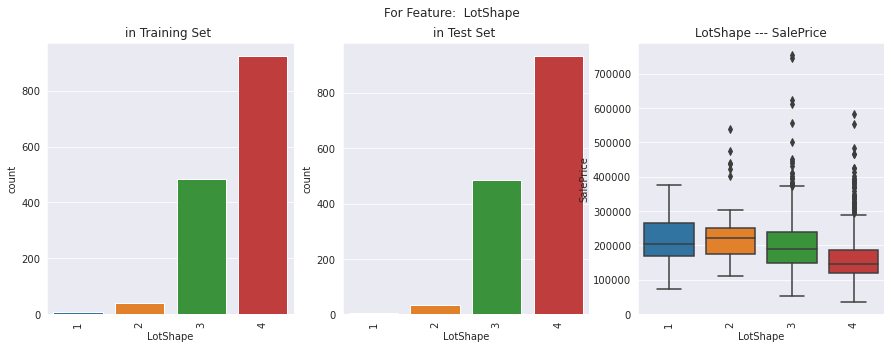

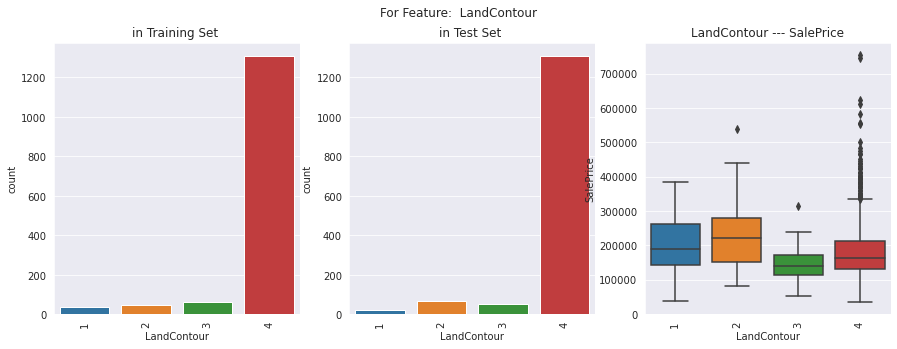

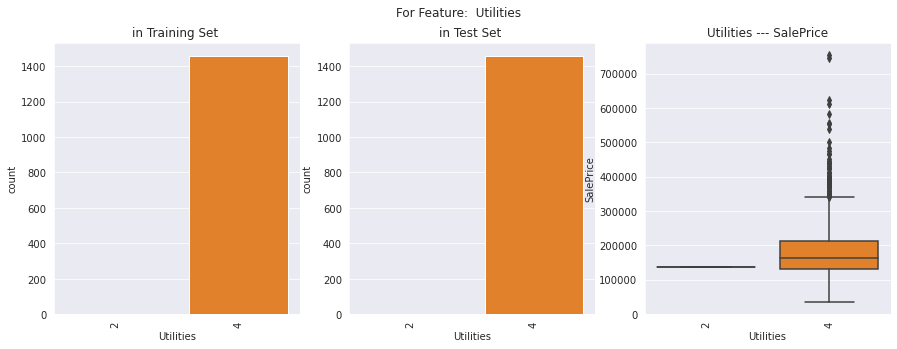

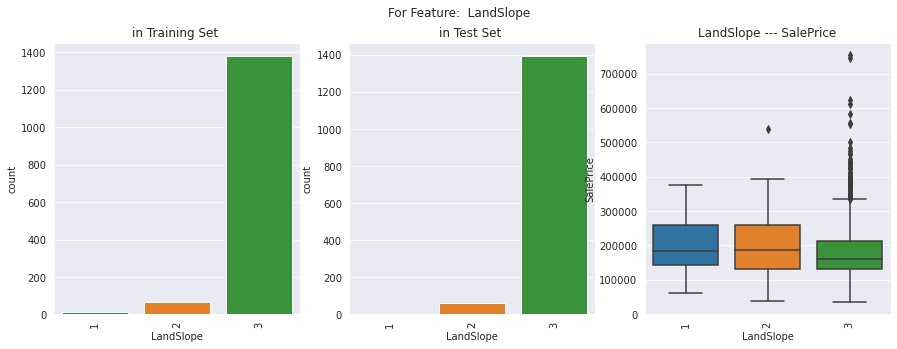

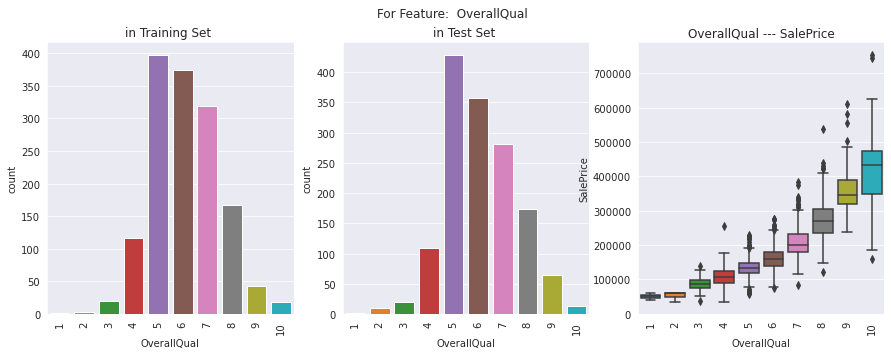

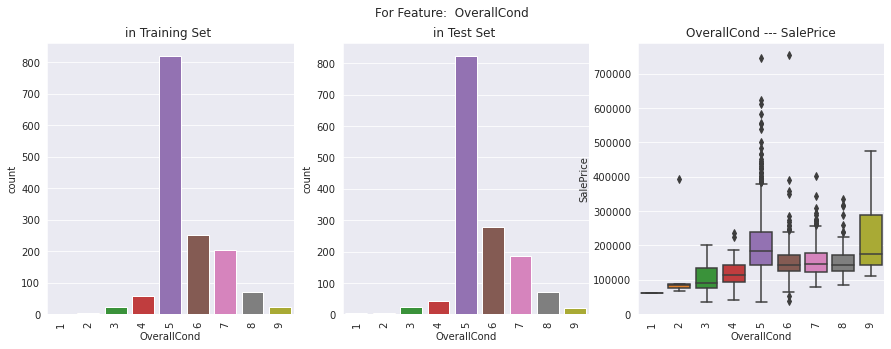

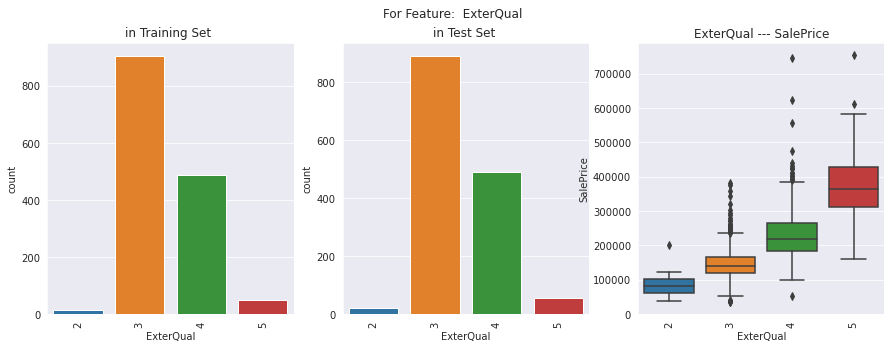

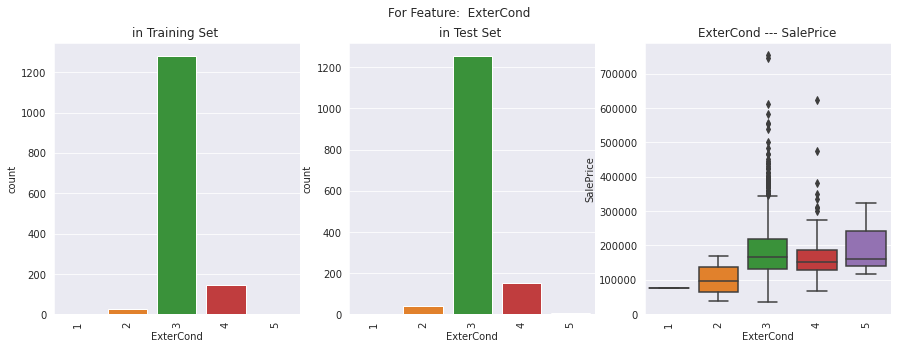

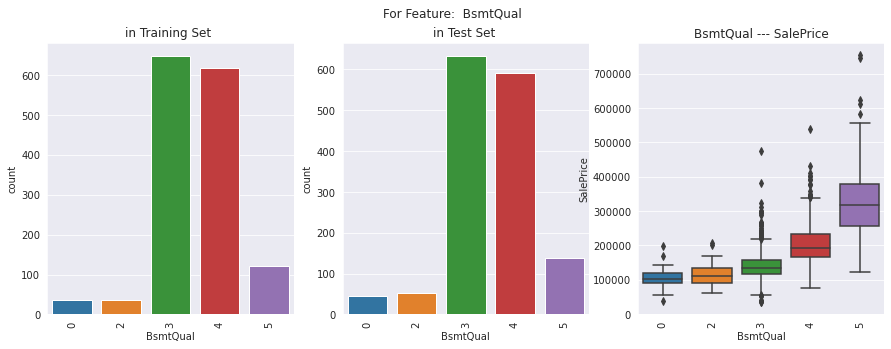

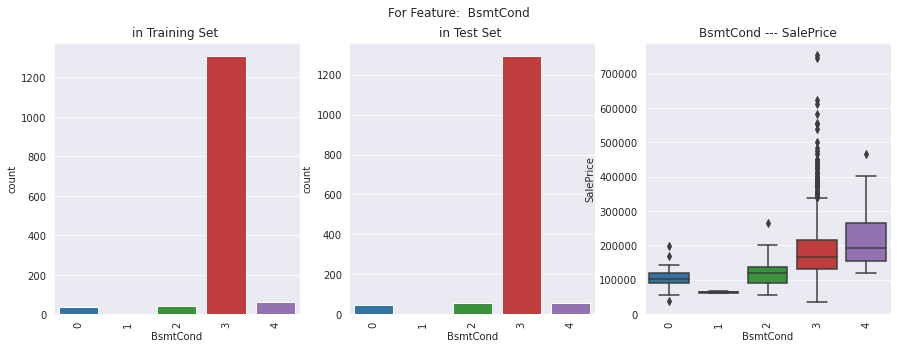

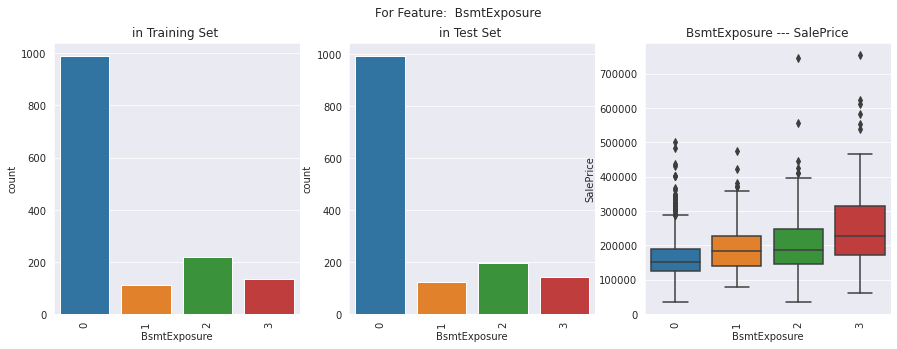

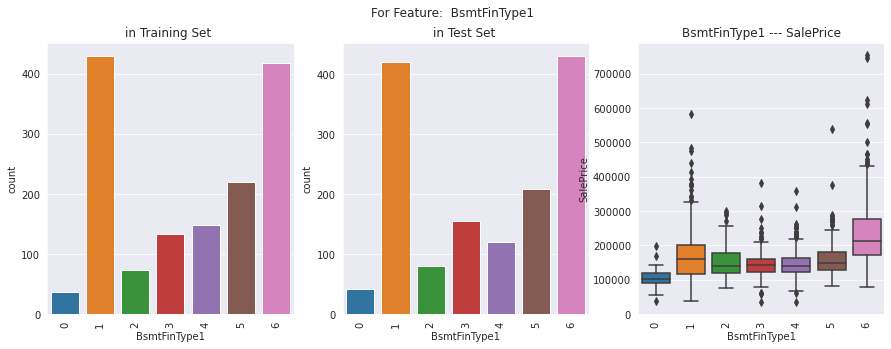

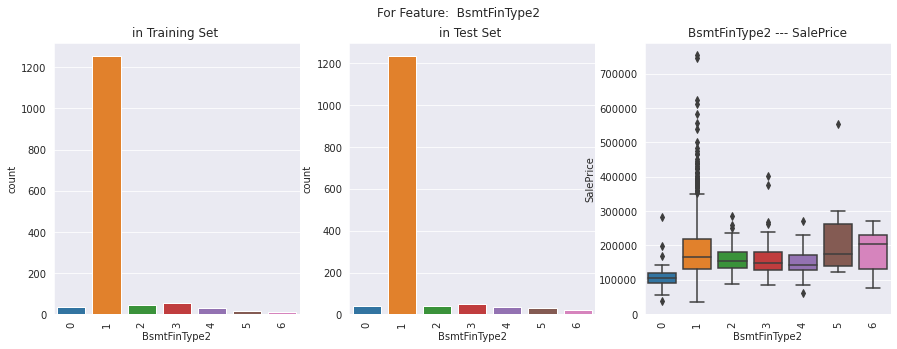

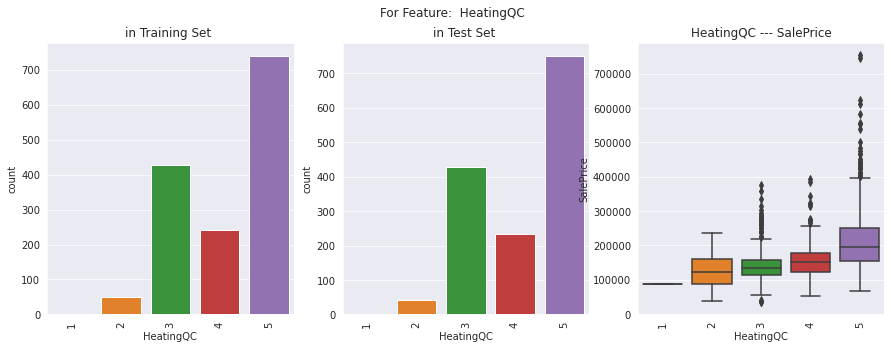

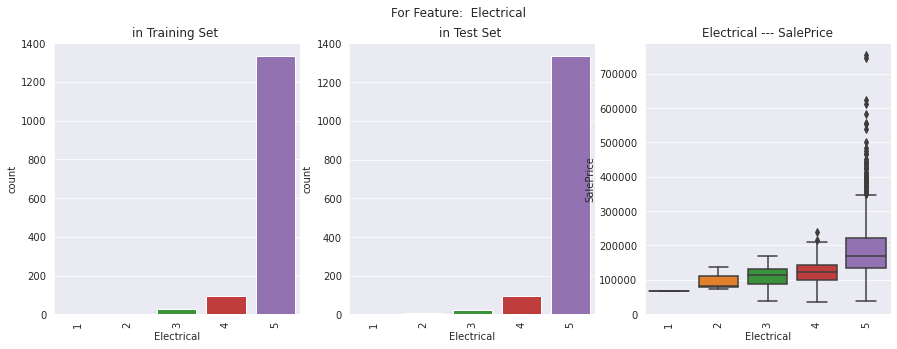

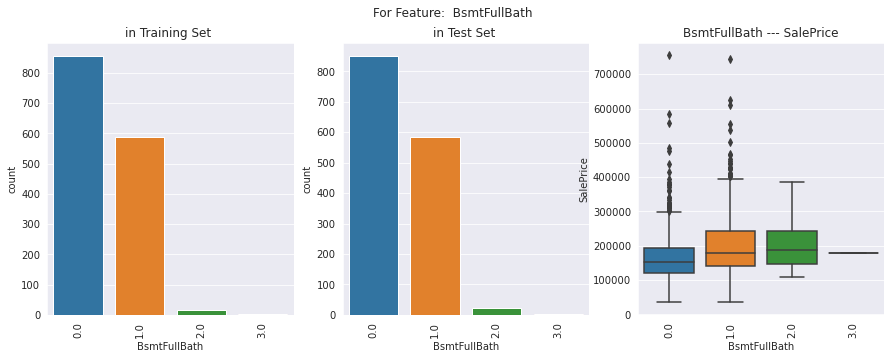

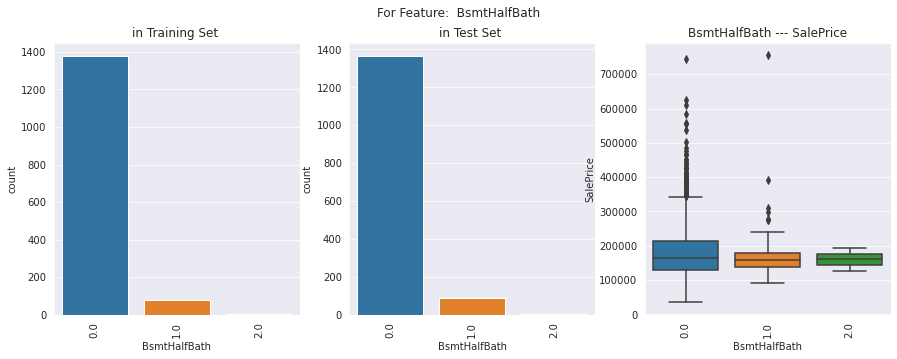

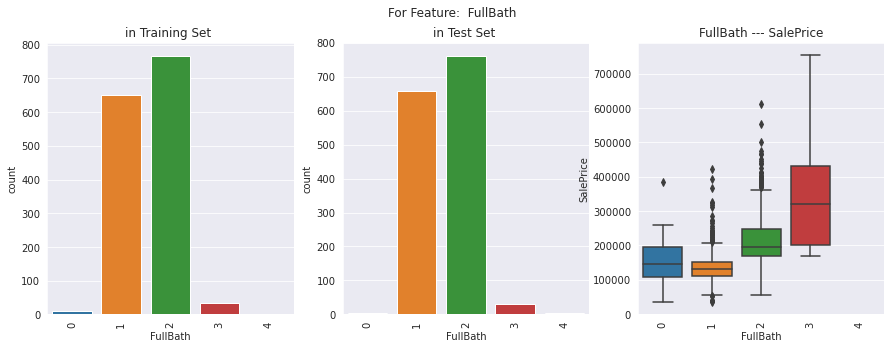

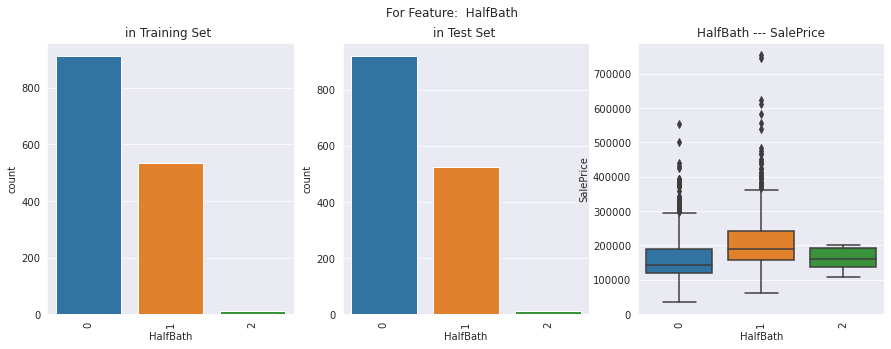

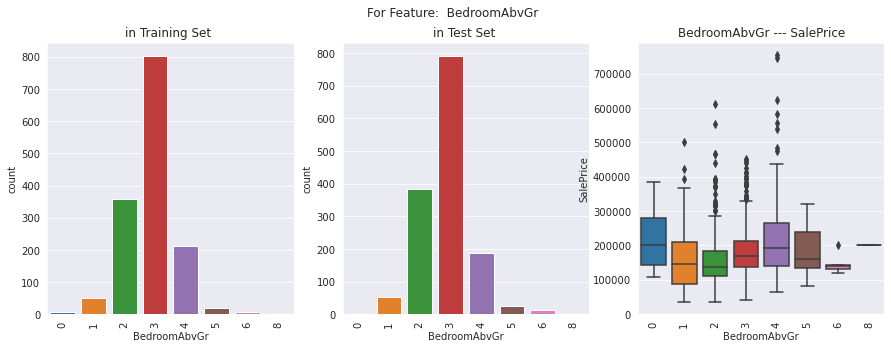

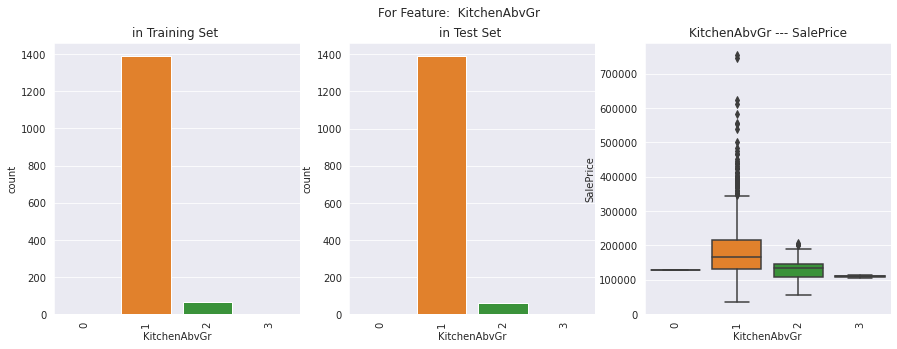

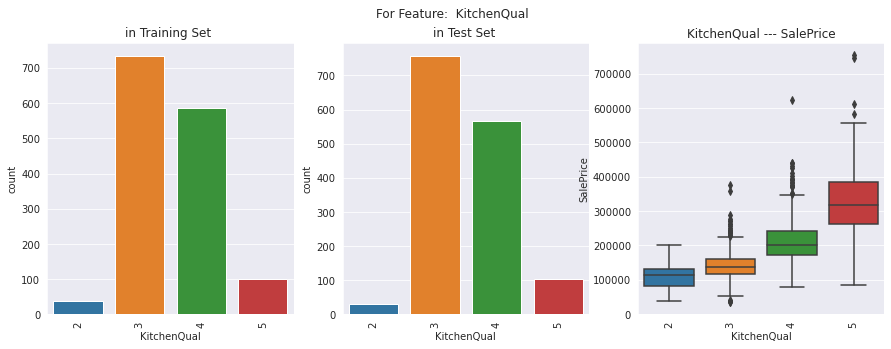

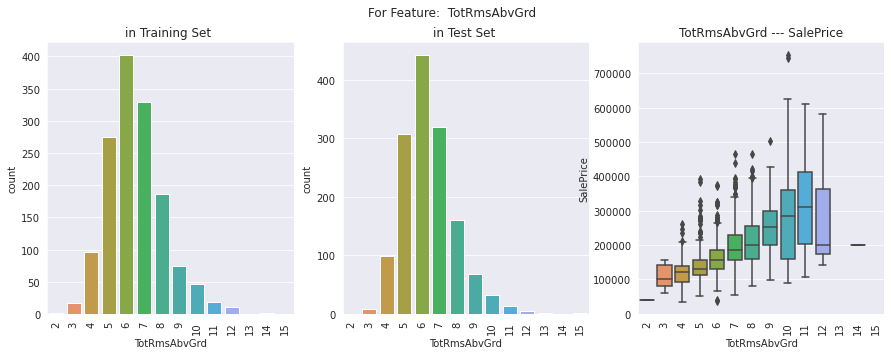

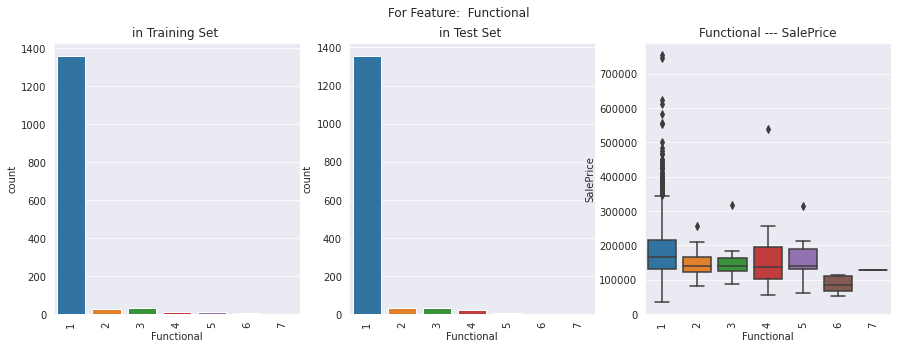

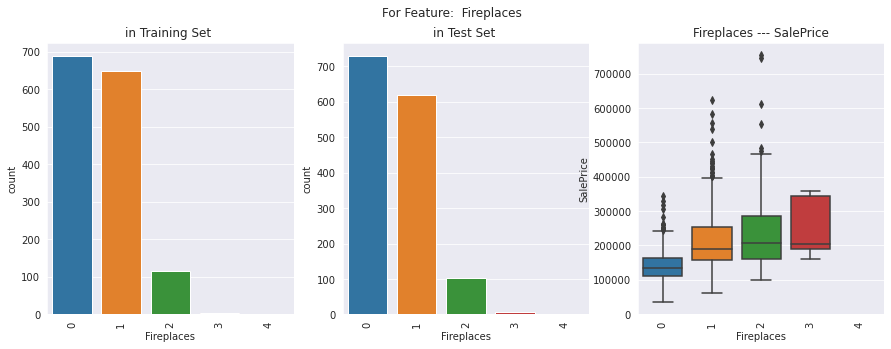

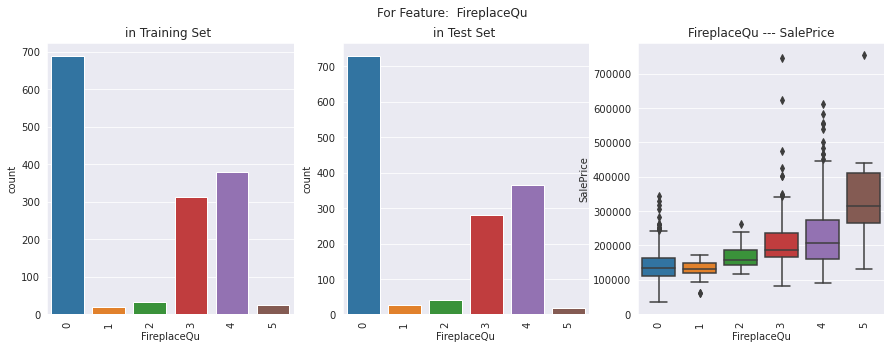

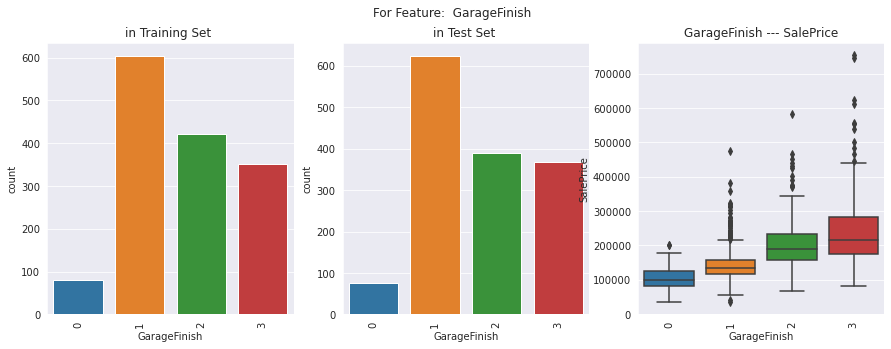

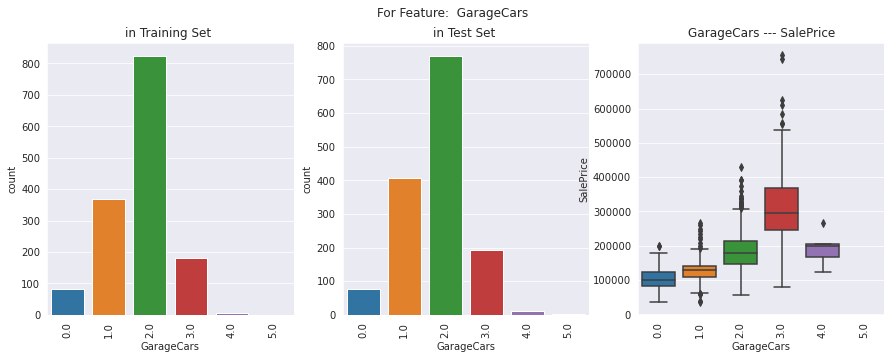

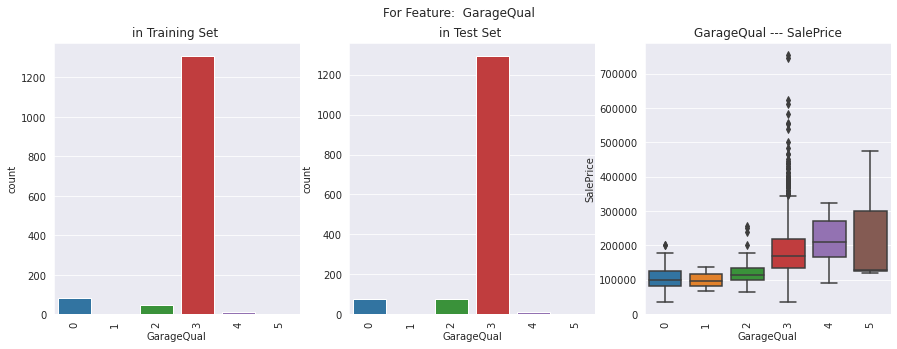

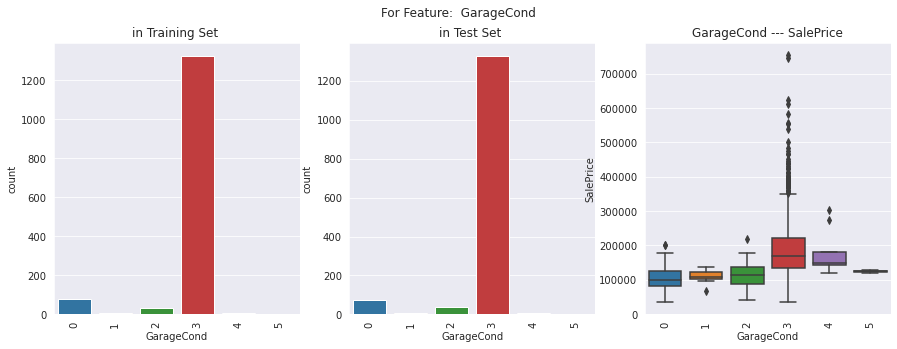

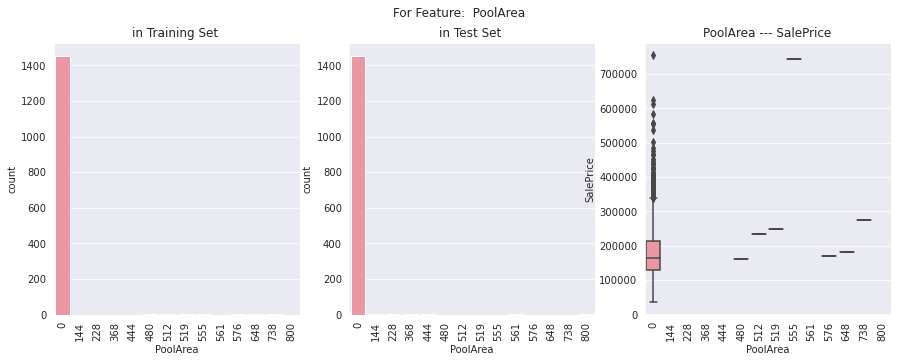

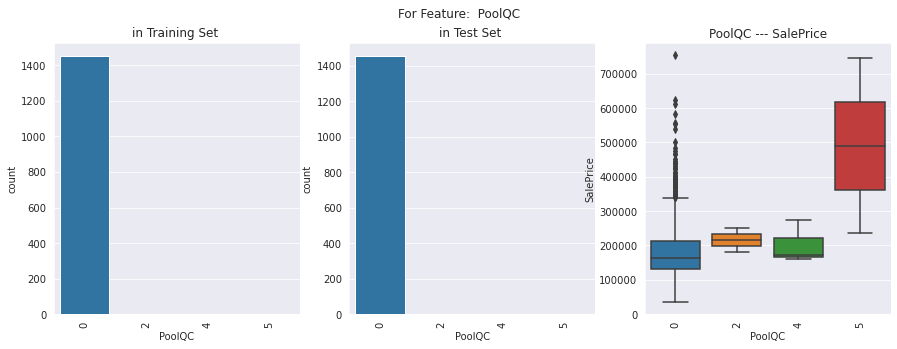

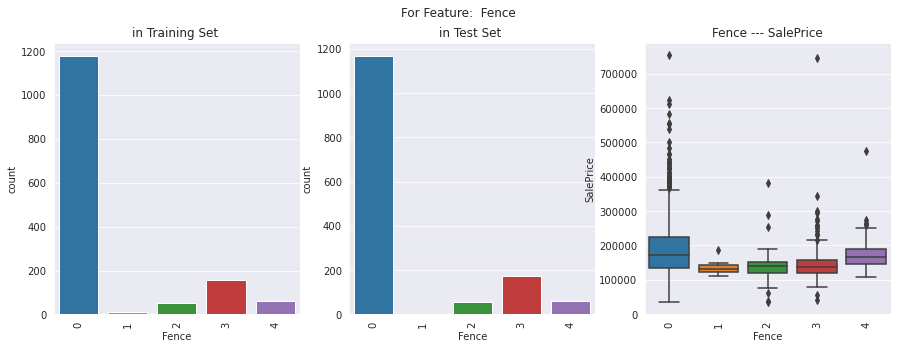

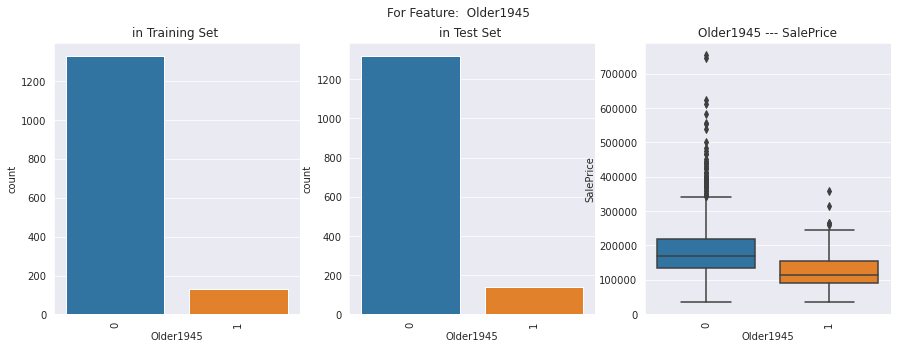

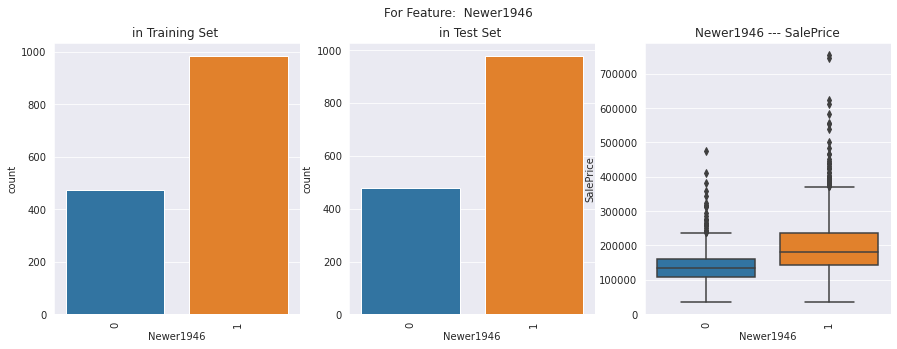

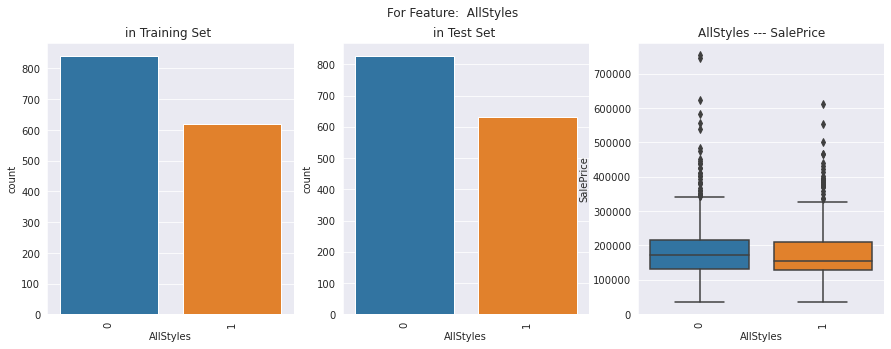

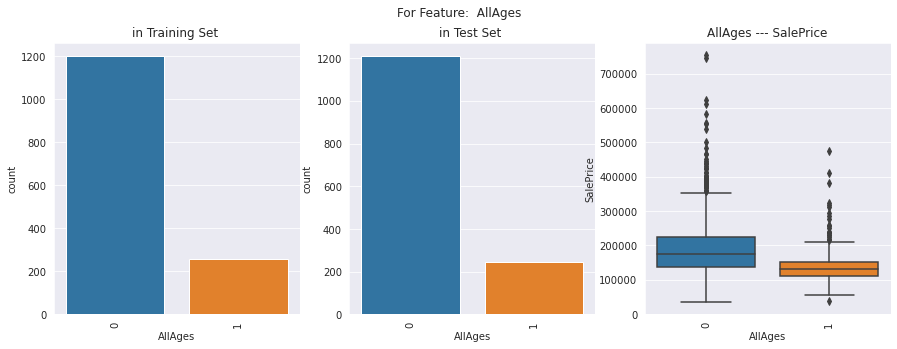

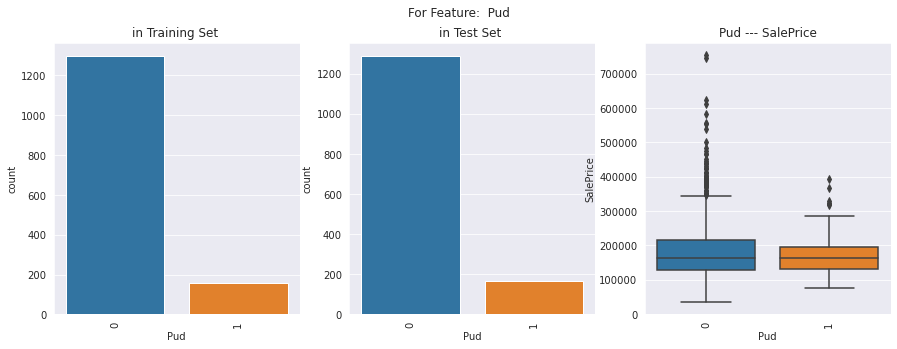

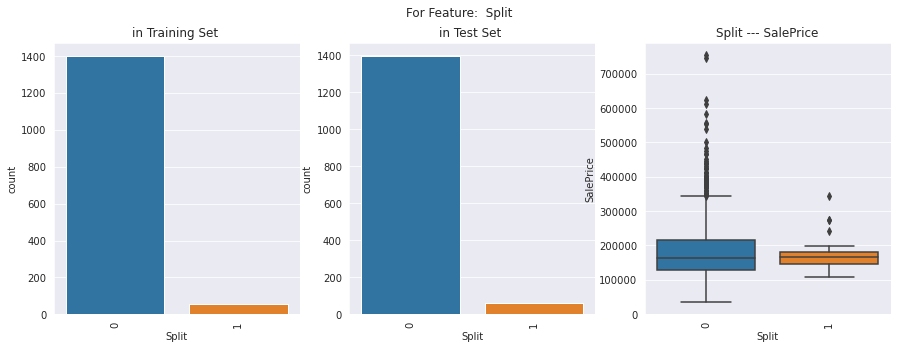

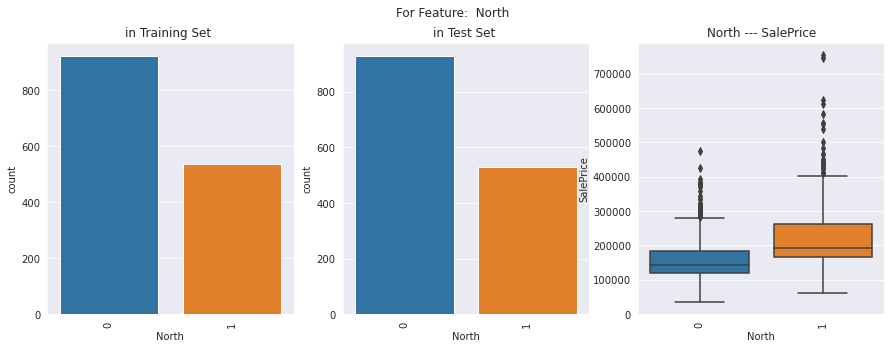

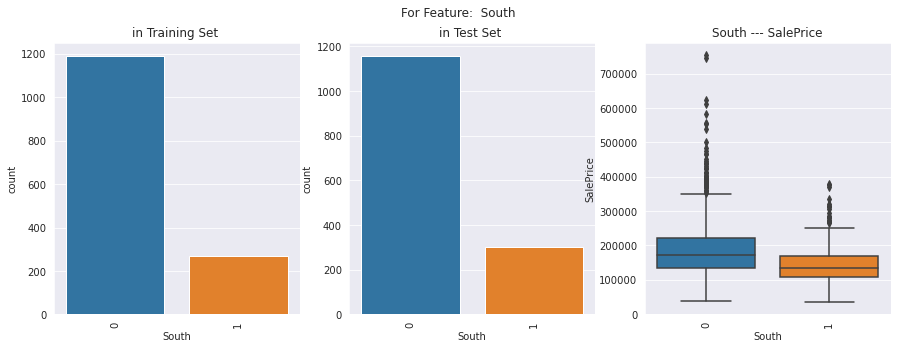

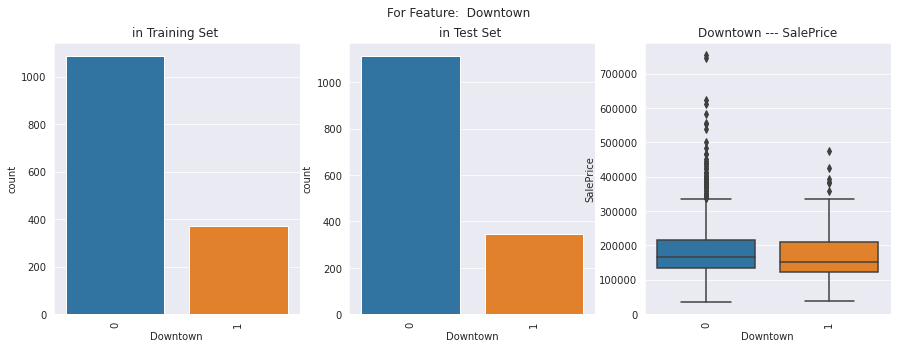

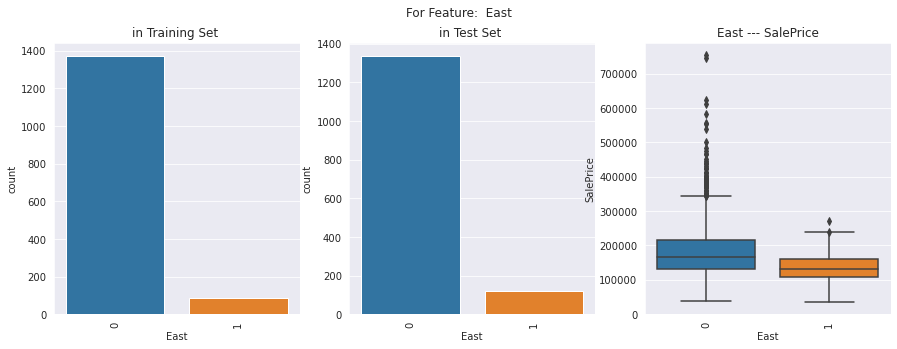

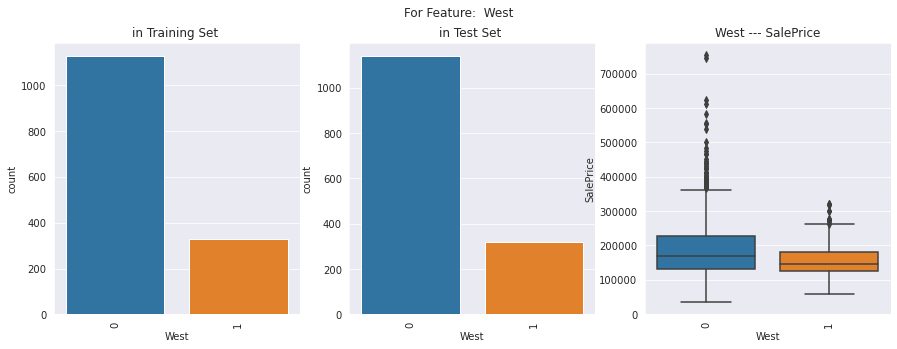

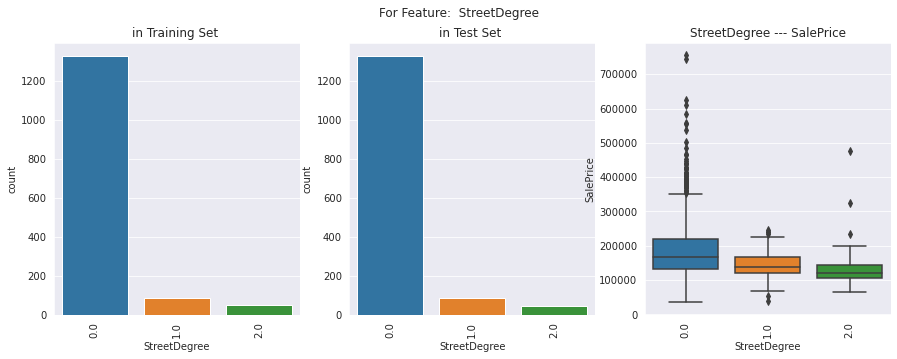

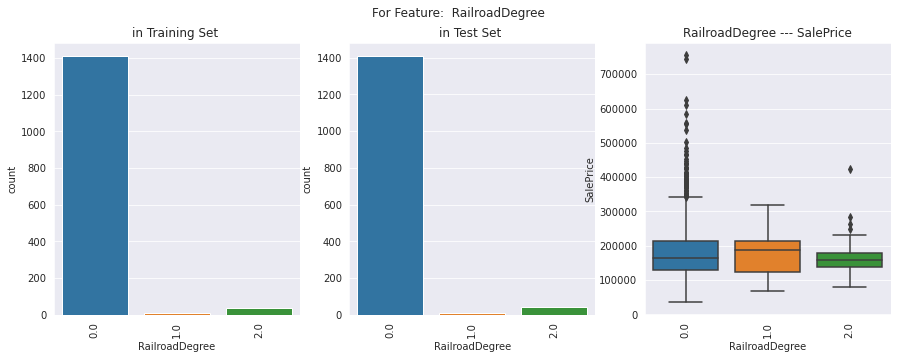

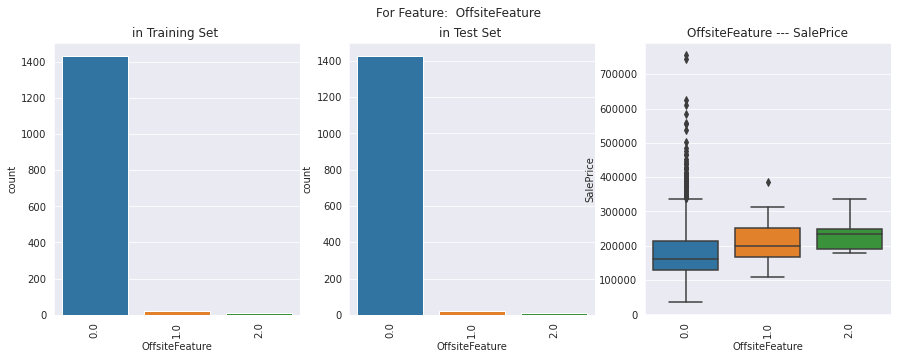

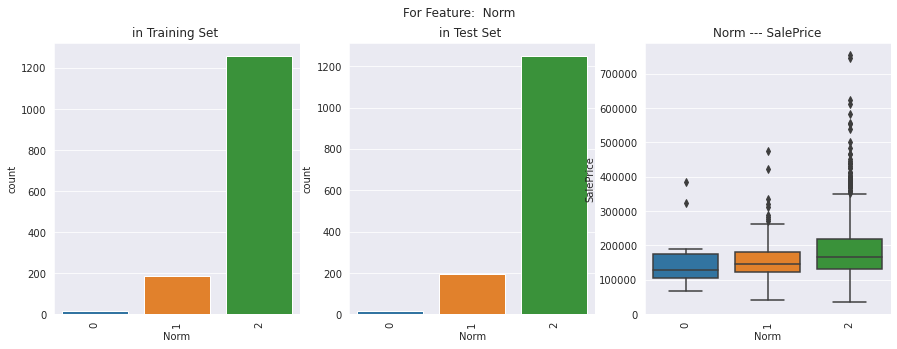

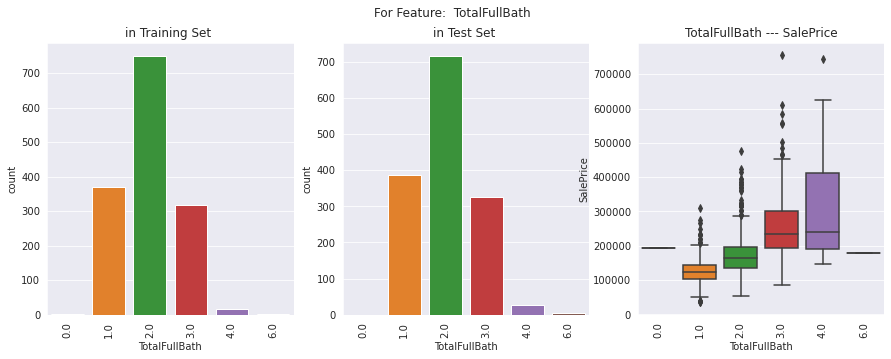

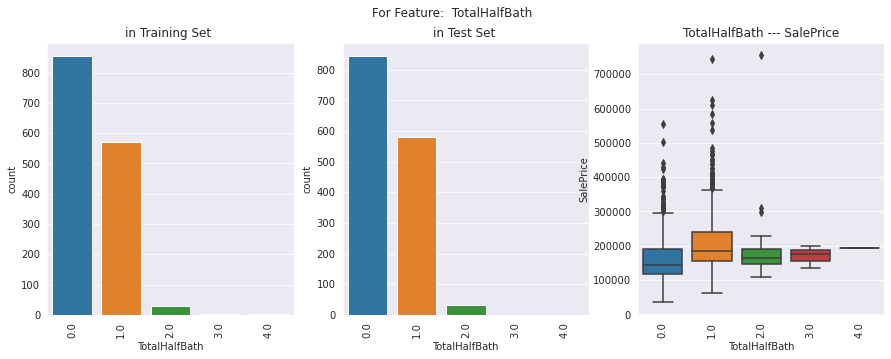

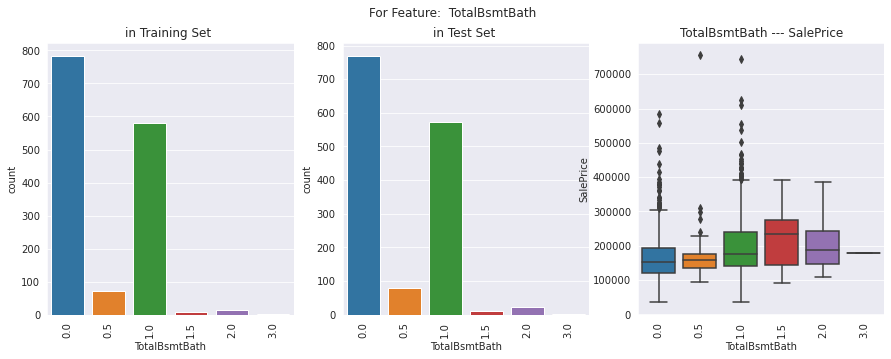

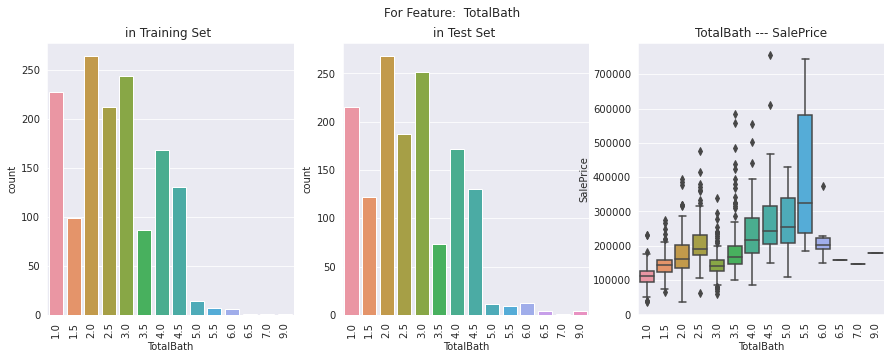

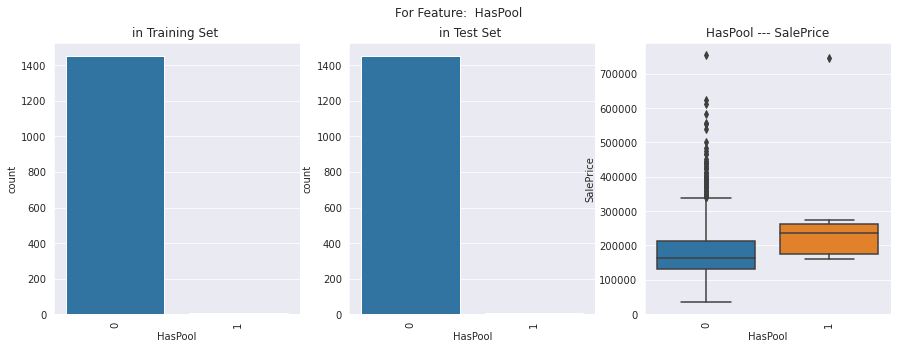

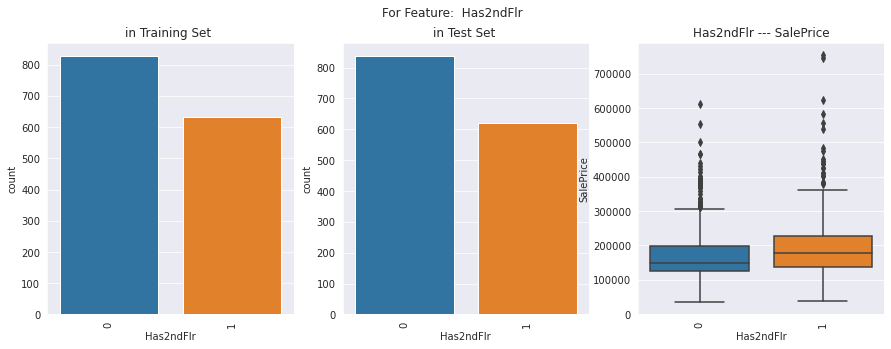

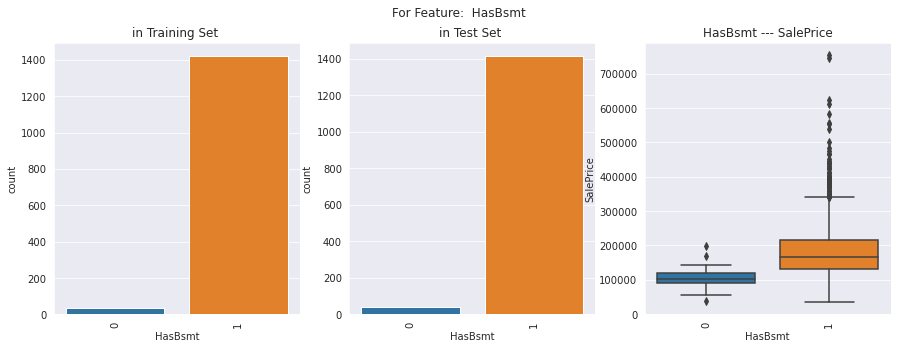

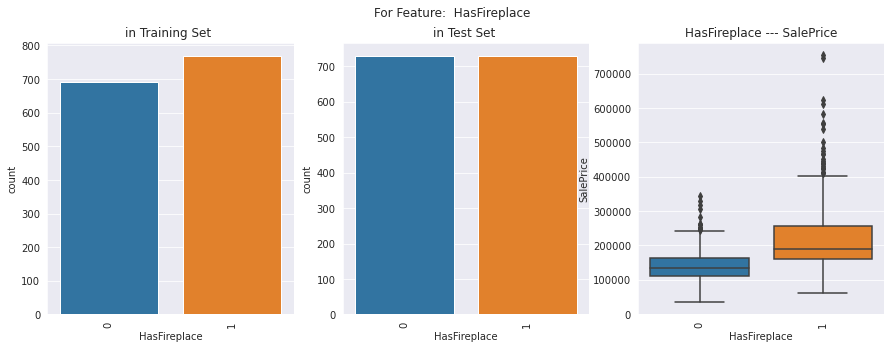

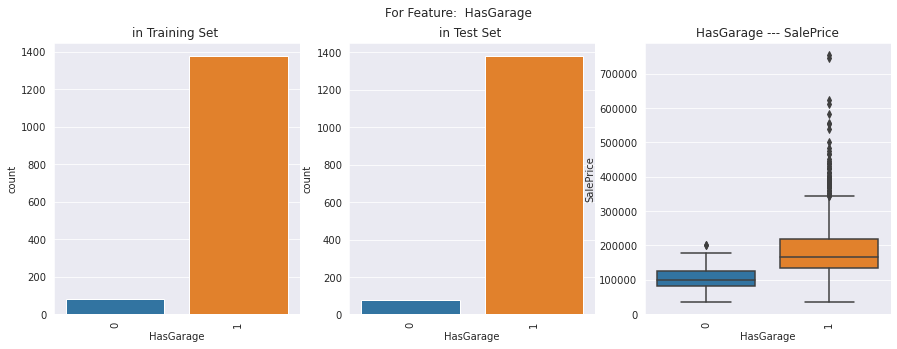

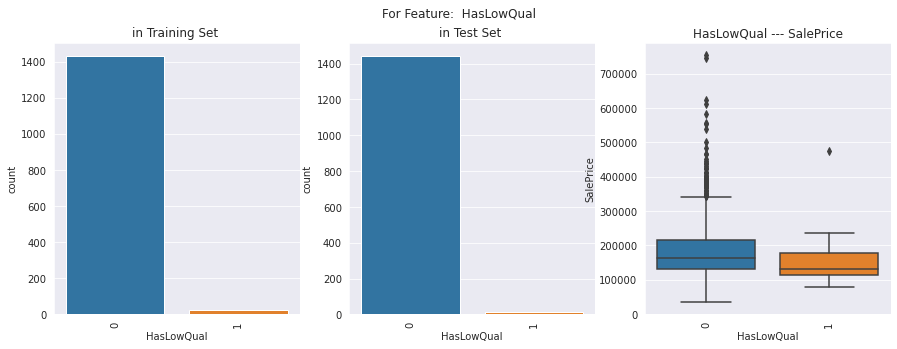

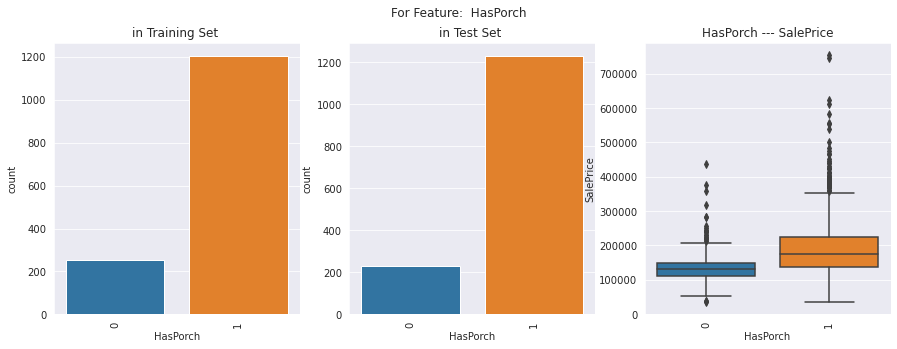

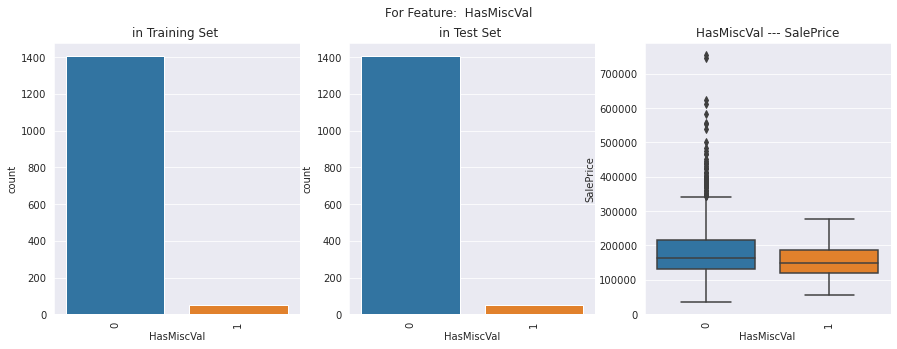

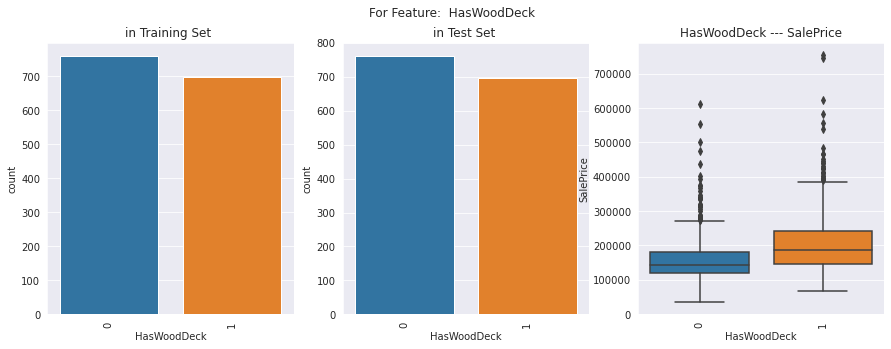

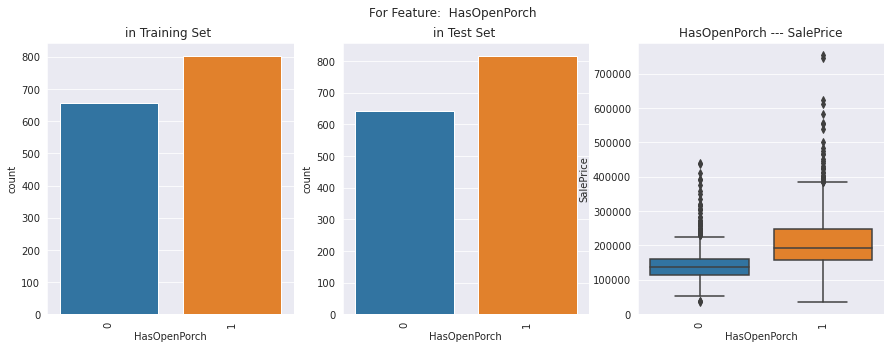

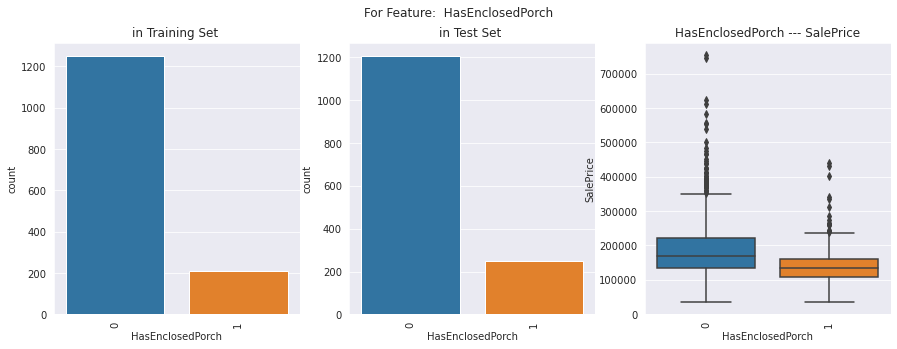

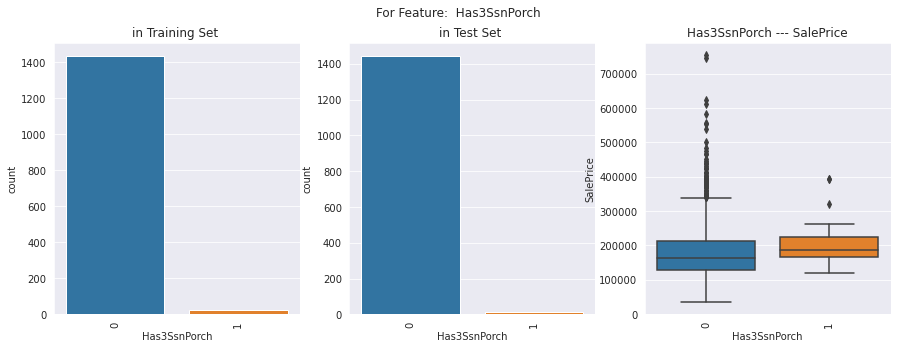

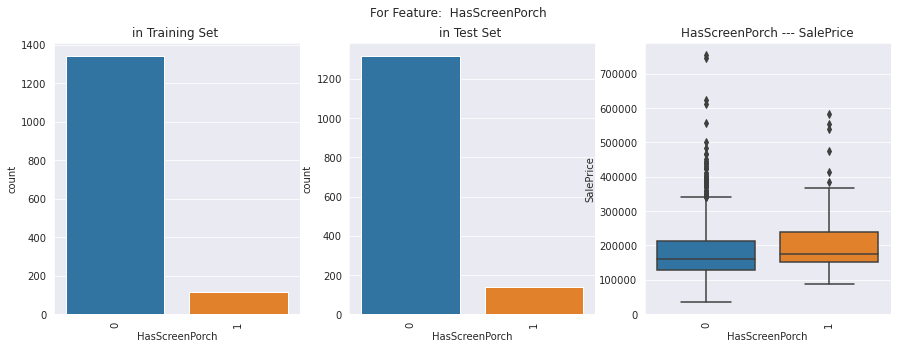

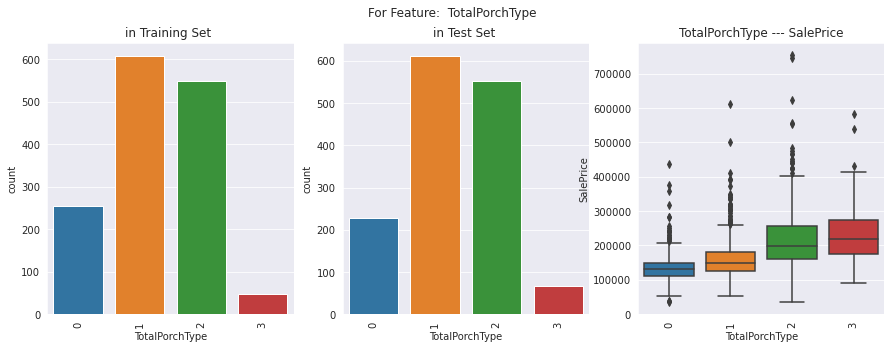

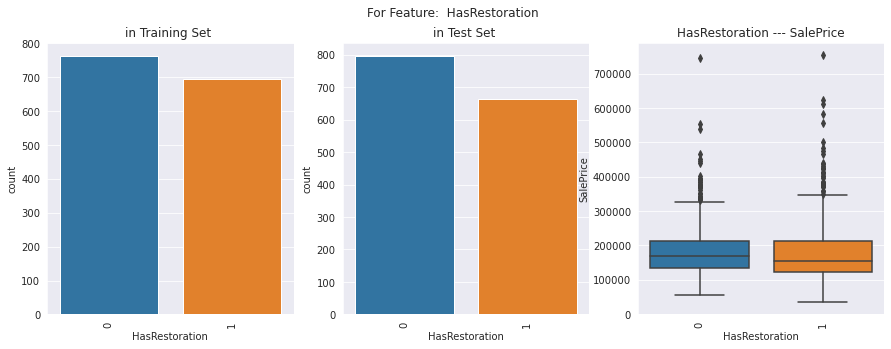

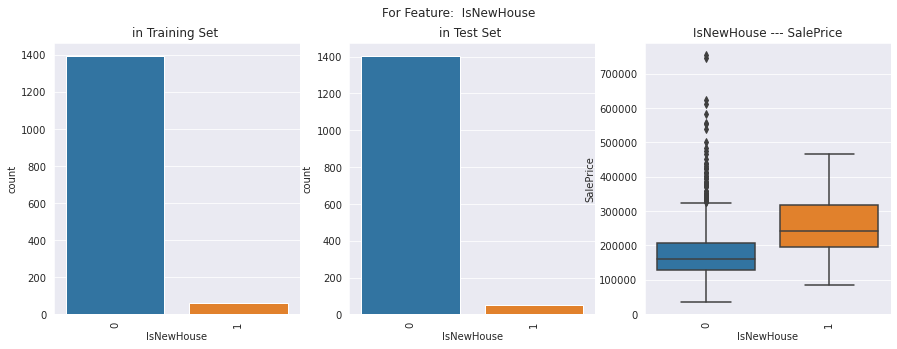

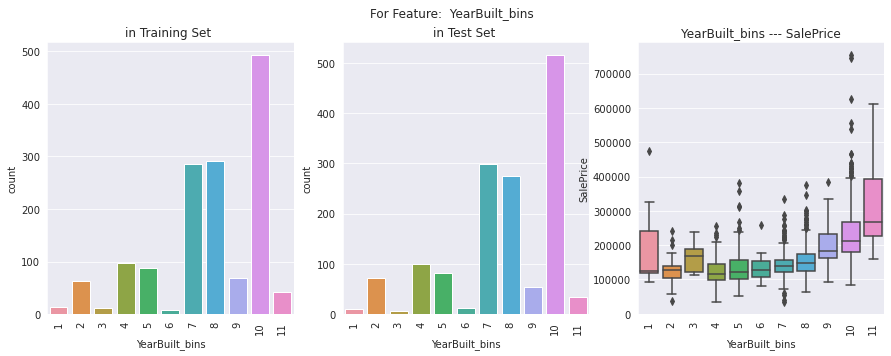

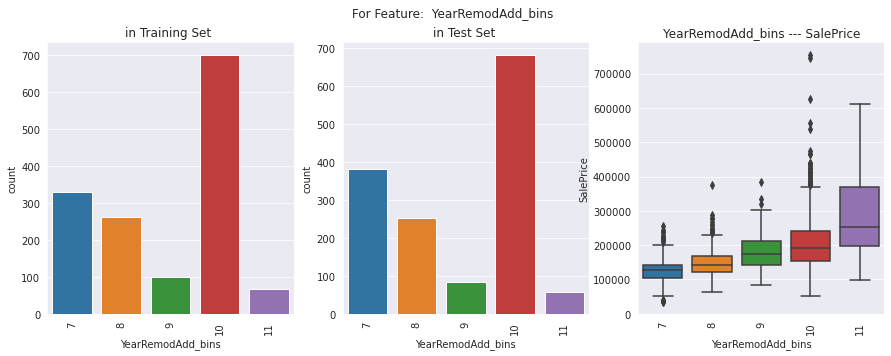

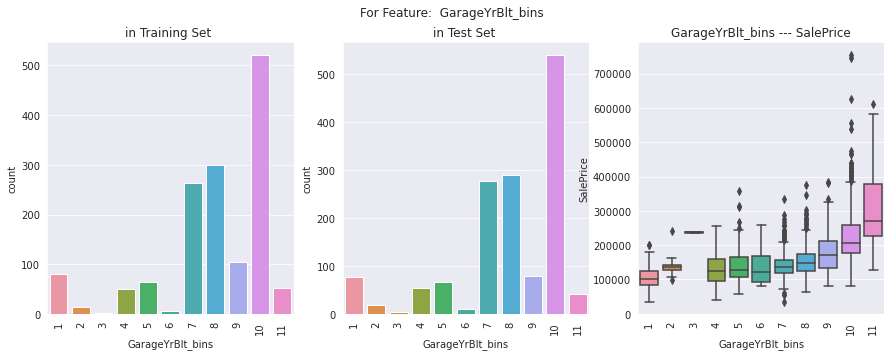

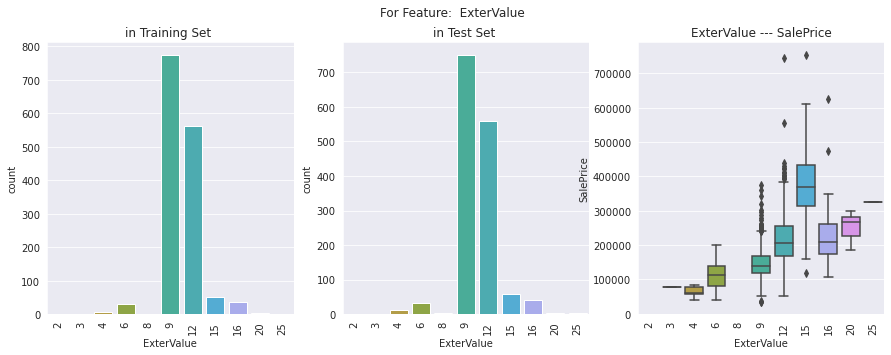

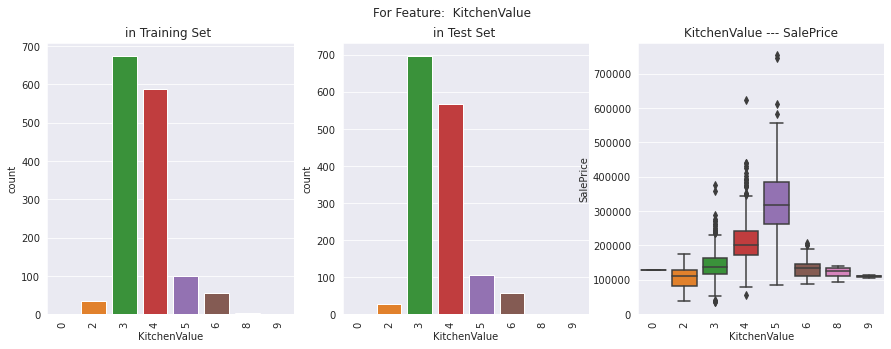

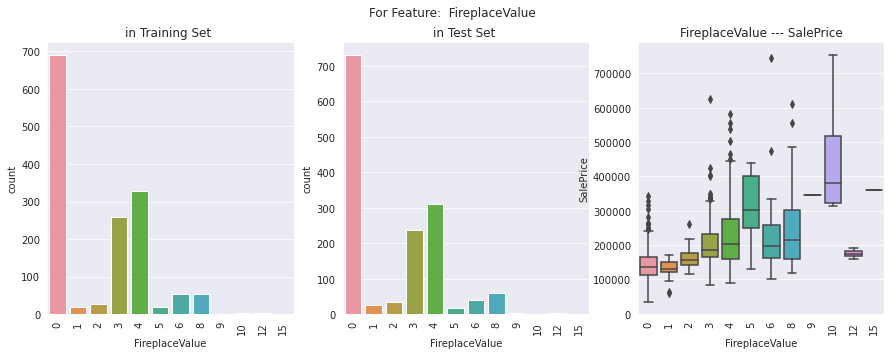

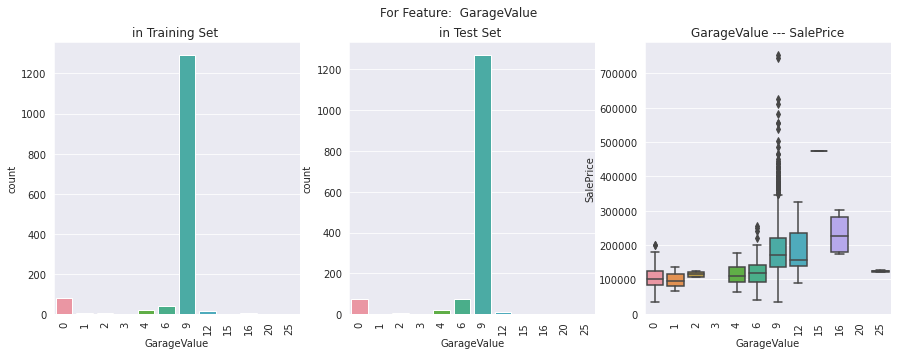

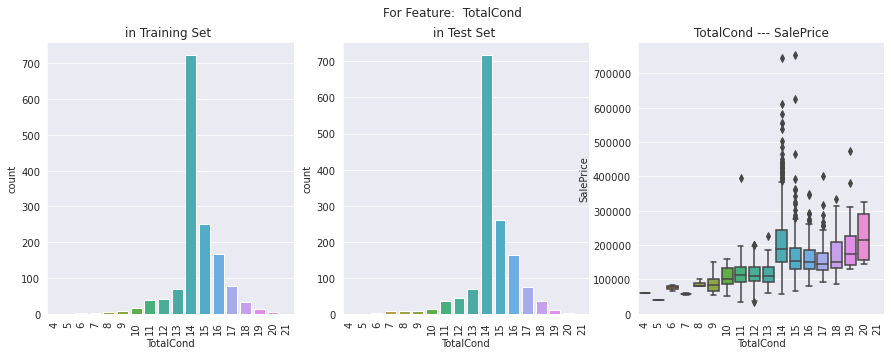

In [61]:
for col in ord_cols2:
    bar_box(dff, col)

In [62]:
dff2["LotShape"] = dff2["LotShape"].apply(lambda x: 1 if x in [1, 2] else (2 if x == 3 else 3))
dff2["LandSlope"] = dff2["LandSlope"].apply(lambda x: 1 if x in [1, 2] else (2 if x == 3 else 3))
dff2["OverallCond"] = dff2["OverallCond"].apply(lambda x: 1 if x in [1, 2, 3] else x-1)
dff2["OverallQual"] = dff2["OverallQual"].apply(lambda x: 1 if x in [1, 2] else x-1)
dff2["ExterCond"] = dff2["ExterCond"].apply(lambda x: 1 if x in [1, 2] else (2 if x == 3 else 3))
dff2["BsmtQual"] = dff2["BsmtQual"].apply(lambda x: 0 if x in [0, 1, 2] else (1 if x == 3 else (2 if x == 4 else 3)))
dff2["BsmtCond"] = dff2["BsmtCond"].apply(lambda x: 0 if x in [0, 1, 2] else (1 if x == 3 else 2))
dff2["BsmtFinType1"] = dff2["BsmtFinType1"].apply(lambda x: 1 if x in [1, 2, 3, 4, 5] else (2 if x == 6 else x))
dff2["BsmtFinType2"] = dff2["BsmtFinType2"].apply(lambda x: 1 if x in [1, 2, 3, 4, 5] else (2 if x == 6 else x))
dff2["HeatingQC"] = dff2["HeatingQC"].apply(lambda x: 1 if x in [1, 2] else (2 if x in [3, 4] else 3))
dff2["Electrical"] = dff2["Electrical"].apply(lambda x: 1 if x in [1, 2] else x-3)
dff2["BsmtFullBath"] = dff2["BsmtFullBath"].apply(lambda x: 2 if x >= 2 else x)
dff2["FullBath"] = dff2["FullBath"].apply(lambda x: 1 if x <= 1 else (3 if x >= 3 else x))
dff2["HalfBath"] = dff2["HalfBath"].apply(lambda x: 1 if x >= 1 else 0)
dff2["BedroomAbvGr"] = dff2["BedroomAbvGr"].apply(lambda x: 1 if x <=1 else (5 if x >= 5 else x))
dff2["KitchenAbvGr"] = dff2["KitchenAbvGr"].apply(lambda x: 1 if x <= 1 else (2 if x >= 2 else x))
dff2["TotRmsAbvGrd"] = dff2["TotRmsAbvGrd"].apply(lambda x: 3 if x <= 4 else (10 if x >= 11 else x-1))
dff2["Functional"] = dff2["Functional"].apply(lambda x: 1 if x == 1 else 2)
dff2["Fireplaces"] = dff2["Fireplaces"].apply(lambda x: 2 if x >= 2 else x)
dff2["GarageCars"] = dff2["GarageCars"].apply(lambda x: 3 if x >= 3 else x)
dff2["GarageQual"] = dff2["GarageQual"].apply(lambda x: 1 if x <= 2 else (2 if x == 3 else 3))
dff2["GarageCond"] = dff2["GarageCond"].apply(lambda x: 1 if x <= 2 else 2)
dff2["Fence"] = dff2["Fence"].apply(lambda x: 1 if x in [1, 3] else x)

In [63]:
dff3 = dff2.copy()
dff3

Id MSSubClass MSZoning  LotFrontage  LotArea Street Alley  LotShape  \
0        1         60        R         65.0     8450   Pave  None         3   
1        2         20        R         80.0     9600   Pave  None         3   
2        3         60        R         68.0    11250   Pave  None         2   
3        4         70        R         60.0     9550   Pave  None         2   
4        5         60        R         84.0    14260   Pave  None         2   
...    ...        ...      ...          ...      ...    ...   ...       ...   
1454  2915        160        R         21.0     1936   Pave  None         3   
1455  2916        160        R         21.0     1894   Pave  None         3   
1456  2917         20        R        160.0    20000   Pave  None         3   
1457  2918         85        R         62.0    10441   Pave  None         3   
1458  2919         60        R         74.0     9627   Pave  None         3   

      LandContour  Utilities LotConfig  LandSlope Neighborhood Condition1  \
0               4          4    Inside          2      CollgCr       Norm   
1               4          4       FR2          2      Veenker      Feedr   
2               4          4    Inside          2      CollgCr       Norm   
3               4          4    Corner          2      Crawfor       Norm   
4               4          4       FR2          2      NoRidge       Norm   
...           ...        ...       ...        ...          ...        ...   
1454            4          4    Inside          2      MeadowV       Norm   
1455            4          4    Inside          2      MeadowV       Norm   
1456            4          4    Inside          2      Mitchel       Norm   
1457            4          4    Inside          2      Mitchel       Norm   
1458            4          4    Inside          1      Mitchel       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0          Norm     1Fam     2Story            6            4       2003   
1          Norm     1Fam     1Story            5            7       1976   
2          Norm     1Fam     2Story            6            4       2001   
3          Norm     1Fam     2Story            6            4       1915   
4          Norm     1Fam     2Story            7            4       2000   
...         ...      ...        ...          ...          ...        ...   
1454       Norm    Twnhs     2Story            3            6       1970   
1455       Norm   TwnhsE     2Story            3            4       1970   
1456       Norm     1Fam     1Story            4            6       1960   
1457       Norm     1Fam     SFoyer            4            4       1992   
1458       Norm     1Fam     2Story            6            4       1993   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd   MasVnrType  \
0             2003     Gable  CompShg     VinylSd     VinylSd      BrkFace   
1             1976     Gable  CompShg     MetalSd     MetalSd  None_BrkCmn   
2             2002     Gable  CompShg     VinylSd     VinylSd      BrkFace   
3             1970     Gable  CompShg     Wd Sdng     WdShing  None_BrkCmn   
4             2000     Gable  CompShg     VinylSd     VinylSd      BrkFace   
...            ...       ...      ...         ...         ...          ...   
1454          1970     Gable  CompShg     CemntBd     CemntBd  None_BrkCmn   
1455          1970     Gable  CompShg     CemntBd     CemntBd  None_BrkCmn   
1456          1996     Gable  CompShg     VinylSd     VinylSd  None_BrkCmn   
1457          1992     Gable  CompShg     HdBoard     WdShing  None_BrkCmn   
1458          1994     Gable  CompShg     HdBoard     HdBoard      BrkFace   

      MasVnrArea  ExterQual  ExterCond         Foundation  BsmtQual  BsmtCond  \
0          196.0          4          2         PConc_Wood         2         1   
1            0.0          3          2             CBlock         2         1   
2          162.0          4          2   

# Target Encoding For High Cardinality Categorical Features

If your categorical variable has lots of group, using target encoding is one of the best way to handle. 
For example, you have a categorical variable that has 20 value to get. If you perform one-hot encoding to this feature, one-hot encoding generates 19 new column, dummy variable, to handle only one categorical feature. It causes to huge increasing on data and maybe losing some information.

In below, I just take high cardinality categorical features and I create new features with ranking median SalePrice per group.

In [64]:
for col in cat_cols2:
    print(col, dff3[col].value_counts().size)

MSSubClass 15
MSZoning 3
Street 2
Alley 3
LotConfig 4
Neighborhood 25
Condition1 9
Condition2 8
BldgType 4
HouseStyle 8
RoofStyle 2
RoofMatl 2
Exterior1st 15
Exterior2nd 16
MasVnrType 3
Foundation 3
Heating 2
CentralAir 2
GarageType 5
PavedDrive 3
MiscFeature 5
MoSold 12
YrSold 5
SaleType 4
SaleCondition 3
Season 4


In [65]:
target_encoding = ["MSSubClass", "Neighborhood", "Exterior1st", "Exterior2nd", "Condition1", "Condition2", "HouseStyle"]

for col in target_encoding:
    feature_name = col + "Rank"
    dff3.loc[:, feature_name] = dff3[col].map(dff3.groupby(col).SalePrice.median())
    dff3.loc[:, feature_name] = dff3.loc[:, feature_name].rank(method = "dense")

In [66]:
dff3["Exterior"] = np.where((dff3["Exterior1st"] != dff3["Exterior2nd"]), "Mixed", dff3["Exterior1st"])
dff3["No2ndExt"] = dff3["Exterior"].apply(lambda x: 0 if x == "Mixed" else 1)

In [67]:
drop_cols = ["MSSubClass", "Neighborhood", "Condition1", "Condition2", "Exterior1st", "Exterior2nd", "PoolArea", "PoolQC",
             "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", "LowQualFinSF", "MiscVal", "2ndFlrSF", 
             "HouseStyle","YrSold", "MoSold", "YearBuilt", "YearRemodAdd", "GarageYrBlt", "Exterior", "Utilities", "Street"]


dff3.drop(drop_cols, axis = 1, inplace = True)

In [68]:
num_, cat_, ord_ = col_types(dff3)

def prep_data(df, cat_cols, target):
    
    dummies = pd.get_dummies(df[cat_cols], drop_first = True)
    data = pd.concat([df, dummies], axis = 1).drop(cat_cols, axis = 1)
    
    train = data[data[target].notnull()]
    test = data[data[target].isnull()]
    
    return train, test


train, test = prep_data(dff3, cat_, "SalePrice")

target = "SalePrice"
predictors = [x for x in train.columns if x not in ["Id", "SalePrice"]]

# 4. Preprocessing

# 4.1 Handling Skewness

For most of machine learning algorithms, especially linear models, normally distributed features gives us better results. (Tree based algorithms don't need it)

Detecting skewed features and normalizing with transformation.

Our features have 0 values, that's why yeo johnson transformation method used.
For box-cox transformation, we need data that have positive values. If you want to perform box-cox transformation, you need add a smaller positive value like 0.0001.

https://www.kaggle.com/rtatman/boxcox-transform-on-train-test-data

In [69]:
train_skew = []
test_skew = []
check_cols = [x for x in num_ if not x.endswith("Rank")]

for col in check_cols:
    train_skew.append(train[col].skew())
    test_skew.append(test[col].skew())
    
skew_df = pd.DataFrame({"Feature": check_cols, "TrainSkewness": train_skew, "TestSkewness": test_skew})
skewed = skew_df[skew_df.TrainSkewness.abs() >= 0.5]
skewed

Feature  TrainSkewness  TestSkewness
0              LotFrontage       2.023838      0.609385
1                  LotArea      12.207688      3.115217
2               MasVnrArea       2.677616      2.549569
3               BsmtFinSF1       1.685503      1.166330
4               BsmtFinSF2       4.255261      4.042954
5                BsmtUnfSF       0.920268      0.919923
6              TotalBsmtSF       1.524255      0.805066
7                 1stFlrSF       1.376757      1.558195
8                GrLivArea       1.366560      1.130402
10           FrontageRatio       2.977661      3.040597
11                 HQFloor       1.330470      1.142634
12          FloorAreaRatio       2.847162      2.801147
13               TotalArea       1.778029      1.202778
14              TotalPorch       1.102313      1.617713
15      WeightedBsmtFinSF1       2.195138      1.567849
16      WeightedBsmtFinSF2       5.698383      5.320769
17   WeightedTotalBasement       2.429240      1.635091
18          RestorationAge       1.957396      2.183159
19    YearAfterRestoration       0.502575      0.399681
20                BuildAge       0.609030      0.589742
25           TotalQualCond      -0.532423     -0.520288
26            BsmtSFxValue       1.967151      1.453906
27             BsmtSFxQual       2.322639      1.630038
28  TotalAreaXOverallValue       2.366625      1.555351
29   TotalAreaXOverallQual       2.439608      1.808607
30  GarageAreaXGarageValue       0.708909      0.495501

In [70]:
train_skew_yeoj = []
test_skew_yeoj = []

for col in skewed.Feature.tolist():
    train[col], fitted_lambda = stats.yeojohnson(train[col])
    test[col] = stats.yeojohnson(test[col], fitted_lambda)
    
    train_skew_yeoj.append(train[col].skew())
    test_skew_yeoj.append(test[col].skew())    
    
skewed["TrainSkewness_AfterYeoJohnson"] = train_skew_yeoj
skewed["TestSkewness_AfterYeoJohnson"] = test_skew_yeoj

skewed

Feature  TrainSkewness  TestSkewness  \
0              LotFrontage       2.023838      0.609385   
1                  LotArea      12.207688      3.115217   
2               MasVnrArea       2.677616      2.549569   
3               BsmtFinSF1       1.685503      1.166330   
4               BsmtFinSF2       4.255261      4.042954   
5                BsmtUnfSF       0.920268      0.919923   
6              TotalBsmtSF       1.524255      0.805066   
7                 1stFlrSF       1.376757      1.558195   
8                GrLivArea       1.366560      1.130402   
10           FrontageRatio       2.977661      3.040597   
11                 HQFloor       1.330470      1.142634   
12          FloorAreaRatio       2.847162      2.801147   
13               TotalArea       1.778029      1.202778   
14              TotalPorch       1.102313      1.617713   
15      WeightedBsmtFinSF1       2.195138      1.567849   
16      WeightedBsmtFinSF2       5.698383      5.320769   
17   WeightedTotalBasement       2.429240      1.635091   
18          RestorationAge       1.957396      2.183159   
19    YearAfterRestoration       0.502575      0.399681   
20                BuildAge       0.609030      0.589742   
25           TotalQualCond      -0.532423     -0.520288   
26            BsmtSFxValue       1.967151      1.453906   
27             BsmtSFxQual       2.322639      1.630038   
28  TotalAreaXOverallValue       2.366625      1.555351   
29   TotalAreaXOverallQual       2.439608      1.808607   
30  GarageAreaXGarageValue       0.708909      0.495501   

    TrainSkewness_AfterYeoJohnson  TestSkewness_AfterYeoJohnson  
0                        0.128635                     -0.342290  
1                        0.026569                     -0.827988  
2                        0.426258                      0.495704  
3                       -0.411401                     -0.382575  
4                        2.425650                      2.292923  
5                       -0.274971                     -0.257906  
6                        0.232534                     -0.110991  
7                       -0.001106                     -0.030473  
8                        0.000171                      0.033914  
10                      -0.213868                      0.010366  
11                       0.000859                      0.066461  
12                       0.003746                      0.178639  
13                       0.037892                     -0.067785  
14                      -0.382788                     -0.327621  
15                      -0.404841                     -0.373905  
16                       2.436322                      2.293034  
17                       0.024313                      0.002014  
18                       0.570496                      0.678331  
19                      -0.160303                     -0.218635  
20                      -0.226952                     -0.205908  
25                       0.008880                      0.042314  
26                       0.010451                     -0.066183  
27                       0.189760                      0.012588  
28                       0.106700                     -0.236787  
29                       0.045391                     -0.085362  
30                      -0.446798                     -0.429630

In [71]:
high_skew = skewed[skewed.TrainSkewness_AfterYeoJohnson.abs() > 1].Feature.tolist()
print(high_skew)

train.drop(high_skew, axis = 1, inplace = True)
test.drop(high_skew, axis = 1, inplace = True)

['BsmtFinSF2', 'WeightedBsmtFinSF2']


# 4.2 Target Distribution

Target distribution;

Normal distributed target is also gives better results, especially linear algorithms.

Also, in this task, our evaluation metric is rmsle. Converting SalePrice to logarithmic form and applying rmse gives us the competition's metric.

1.8828757597682129

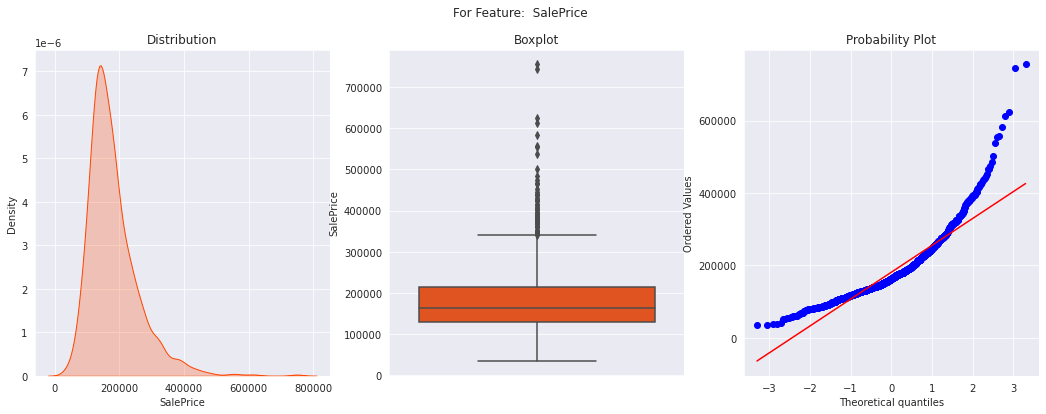

In [72]:
feature_distribution(train, target, test = False)
train[target].skew()

0.12134661989685333

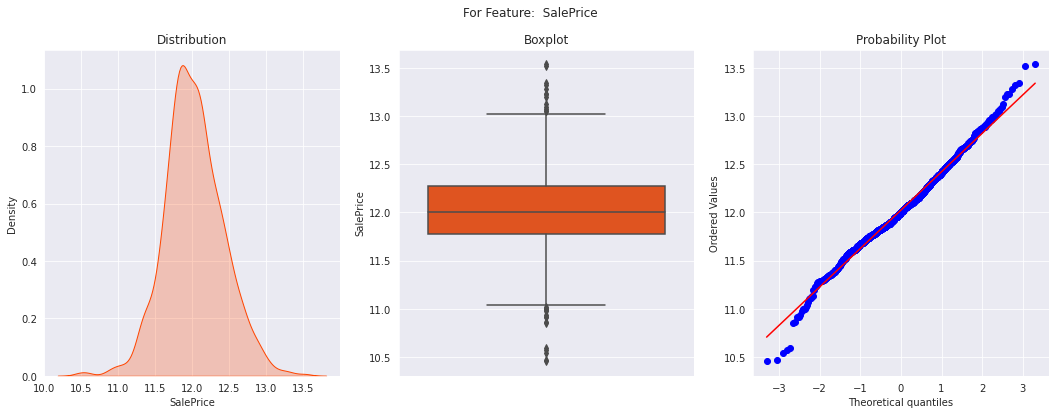

In [73]:
train[target] = np.log1p(train[target])

feature_distribution(train, target, test = False)

train[target].skew()

In [74]:
target = "SalePrice"
predictors = [x for x in train.columns if x not in ["Id", "SalePrice"]]

In [75]:
scaler = RobustScaler()

train[predictors] = scaler.fit_transform(train[predictors])
test[predictors] = scaler.transform(test[predictors])

In [76]:
X_train = train[predictors]
y_train = train[target]
X_test = test[predictors]

print(X_train.shape)
print(X_test.shape)

(1460, 147)
(1459, 147)


In [77]:
selector = VarianceThreshold(0.01)

selector.fit(X_train)
X_train = X_train[X_train.columns[selector.get_support()]]

selector.transform(X_test)
X_test = X_test[X_test.columns[selector.get_support()]]

print(X_train.shape)
print(X_test.shape)

X_test

(1460, 144)
(1459, 144)


LotFrontage   LotArea  LotShape  LandContour  LandSlope  OverallQual  \
0        0.479855  0.476774       0.0          0.0        0.0         -0.5   
1        0.525938  0.959336      -1.0          0.0        0.0          0.0   
2        0.196294  0.885927      -1.0          0.0        0.0         -0.5   
3        0.386708  0.119818      -1.0          0.0        0.0          0.0   
4       -1.530705 -1.474072      -1.0         -2.0        0.0          1.0   
...           ...       ...       ...          ...        ...          ...   
1454    -3.257648 -3.613199       0.0          0.0        0.0         -1.0   
1455    -3.257648 -3.661851       0.0          0.0        0.0         -1.0   
1456     3.473473  1.760967       0.0          0.0        0.0         -0.5   
1457    -0.412430  0.225799       0.0          0.0        0.0         -0.5   
1458     0.196294  0.036249       0.0          0.0       -1.0          0.5   

      OverallCond  MasVnrArea  ExterQual  ExterCond  BsmtQual  BsmtCond  \
0             1.0   -0.000000        0.0        0.0      -1.0       0.0   
1             1.0    0.956898        0.0        0.0      -1.0       0.0   
2             0.0   -0.000000        0.0        0.0       0.0       0.0   
3             1.0    0.736038        0.0        0.0      -1.0       0.0   
4             0.0   -0.000000        1.0        0.0       0.0       0.0   
...           ...         ...        ...        ...       ...       ...   
1454          2.0   -0.000000        0.0        0.0      -1.0       0.0   
1455          0.0   -0.000000        0.0        0.0      -1.0       0.0   
1456          2.0   -0.000000        0.0        0.0      -1.0       0.0   
1457          0.0   -0.000000        0.0        0.0       0.0       0.0   
1458          0.0    0.941668        0.0        0.0       0.0       0.0   

      BsmtExposure  BsmtFinType1  BsmtFinSF1  BsmtFinType2  BsmtUnfSF  \
0              0.0           0.0    0.051912           0.0  -0.404187   
1              0.0           0.0    0.247978           0.0  -0.126281   
2              0.0           1.0    0.200700           0.0  -0.762555   
3              0.0           1.0    0.121055           0.0  -0.286577   
4              0.0           0.0   -0.092023           0.0   0.734797   
...            ...           ...         ...           ...        ...   
1454           0.0           0.0   -0.830482           0.0   0.111921   
1455           0.0           0.0   -0.101949           0.0  -0.350515   
1456           0.0           0.0    0.338897           0.0  -1.625775   
1457           2.0           1.0   -0.032442           0.0   0.157058   
1458           2.0           0.0    0.187938           0.0  -0.479823   

      TotalBsmtSF  HeatingQC  Electrical  1stFlrSF  GrLivArea  BsmtFullBath  \
0       -0.223633       -1.0         0.0 -0.427844  -1.082373           0.0   
1        0.652598       -1.0         0.0  0.438180  -0.213542           0.0   
2       -0.128855       -1.0         0.0 -0.349664   0.235870           0.0   
3       -0.132950        0.0         0.0 -0.354464   0.201702           0.0   
4        0.560801        0.0         0.0  0.356815  -0.296426           0.0   
...           ...        ...         ...       ...        ...           ...   
1454    -0.962196       -1.0         0.0 -1.554651  -0.646680           0.0   
1455    -0.962196       -1.0         0.0 -1.554651  -0.646680           0.0   
1456     0.454761        0.0         0.0  0.259606  -0.395102           1.0   
1457    -0.161680       -1.0         0.0 -0.251354  -0.907667           0.0   
1458     0.009049        0.0         0.0 -0.192770   0.689476           0.0   

      BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
0              0.0      -1.0       0.0          -1.0           0.0   
1              0.0      -1.0       1.0           0.0           0.0   
2              0.0       0.0       1.0           0.0           0.0   
3              0.0       0.0       1.0           0.0          

In [78]:
test_id = test[["Id"]]

In [79]:
# from numpy import savetxt

# savetxt('xtrain.csv', X_train, delimiter=',')
# savetxt('xtest.csv', X_test, delimiter=',')
# savetxt('ytrain.csv', y_train, delimiter=',')
# savetxt('testid.csv', test_id, delimiter=',')

In [80]:
kf = KFold(n_splits = 10, shuffle = True, random_state = 42)

def rmse_cv(model, X = X_train, y = y_train):    
    return np.sqrt(-cross_val_score(model, X, y, scoring = 'neg_mean_squared_error', cv = kf)).mean()

# Parameter Tuning

For parameter tuning process, you can take a look at this notebook: https://www.kaggle.com/mustafacicek/lightgbm-xgboost-parameter-tuning-bayessearchcv

# Final: OOF Predictions & Stacking

Instead of using sklearn's StackingRegressor or mlxtend's StackingCVRegressor, I just use the codes in below. Because, while you use LGBMRegressor and XGBRegressor, you need to set early stopping rounds in fit params to prevent overfitting. Sklearn's StackingRegressor doesn't give the opportunity to setting an estimator's fit parameters (or it gives, I don't know), and that's why I will use the scratch in below.

https://machinelearningmastery.com/out-of-fold-predictions-in-machine-learning/

In [81]:
lgb_model = lgb.LGBMRegressor(colsample_bytree=0.25, learning_rate=0.01,
                              max_depth=13, min_child_samples=7, n_estimators=10000,
                              num_leaves=20, objective='regression', random_state=42,
                              subsample=0.9330025956033094, subsample_freq=1)

xgb_model = xgb.XGBRegressor(colsample_bytree=0.25, gamma=0.0, learning_rate=0.01, max_depth=3,
                             n_estimators=15000, n_jobs=-1, random_state=42, 
                             reg_alpha=0.24206673672530965, reg_lambda=0.40464485640717085, subsample=1.0)

gbr_model = GradientBoostingRegressor(alpha=0.8979588317644014,
                                      learning_rate=0.01, loss='huber',
                                      max_depth=13, max_features=0.1, min_samples_split=109,
                                      n_estimators=10000, n_iter_no_change=100, random_state=42)

svr_model = SVR(C=0.7682824405204463, coef0=0.0001, degree=2, epsilon=0.0001, gamma=0.0042151786393578635, max_iter=10000)

lasso_model = Lasso(alpha=0.00012609086150256233, max_iter=5000, random_state=42)

ridge_model = Ridge(alpha=2.651347536470113, max_iter=5000, random_state=42)

enet_model = ElasticNet(alpha=0.0002286518512853544, l1_ratio=0.6510386358323069, max_iter=5000, random_state=42)

I don't use Elasticnet model for stacking. 

I just add conditions for boosting models and a little verbosity for classical out of folds predictions template.

In [82]:
%%time
models = {
    "LGBMRegressor": lgb_model,
    "XGBRegressor": xgb_model,
    "GradientBoostingRegressor": gbr_model,
    "SVR": svr_model,
    "Lasso": lasso_model,
    "Ridge": ridge_model,
#     "ElasticNet": enet_model,
         }

oof_df = pd.DataFrame()
predictions_df = pd.DataFrame()


for name, model in models.items():
    
    print("For model ", name, "\n")
    i = 1
    oof = np.zeros(len(X_train))
    predictions = np.zeros(len(X_test))
    
    for train_ix, test_ix in kf.split(X_train.values):
        
        print("Out of fold predictions generating for fold ", i)
        
        train_X, train_y = X_train.values[train_ix], y_train[train_ix]
        test_X, test_y = X_train.values[test_ix], y_train[test_ix]
        
        if name == "LGBMRegressor":
            model.fit(train_X, train_y,
                      eval_set = [(test_X, test_y)],
                      eval_metric = "rmse",
                      early_stopping_rounds=200,
                      verbose=0)
            
        elif name == "XGBRegressor":
            model.fit(train_X, train_y,
                      eval_set = [(test_X, test_y)],
                      eval_metric = "rmse",
                      early_stopping_rounds=250,
                      verbose=0)
        else:
            model.fit(train_X, train_y)
            
        oof[test_ix] = oof[test_ix] + model.predict(X_train.values[test_ix])
        predictions = predictions + model.predict(X_test.values)
        
        i = i + 1
        
        oof_df[name] = oof
        predictions_df[name] = predictions / 10
        
        
    print("\nDone \n")

For model  LGBMRegressor 

Out of fold predictions generating for fold  1
Out of fold predictions generating for fold  2
Out of fold predictions generating for fold  3
Out of fold predictions generating for fold  4
Out of fold predictions generating for fold  5
Out of fold predictions generating for fold  6
Out of fold predictions generating for fold  7
Out of fold predictions generating for fold  8
Out of fold predictions generating for fold  9
Out of fold predictions generating for fold  10

Done 

For model  XGBRegressor 

Out of fold predictions generating for fold  1
Out of fold predictions generating for fold  2
Out of fold predictions generating for fold  3
Out of fold predictions generating for fold  4
Out of fold predictions generating for fold  5
Out of fold predictions generating for fold  6
Out of fold predictions generating for fold  7
Out of fold predictions generating for fold  8
Out of fold predictions generating for fold  9
Out of fold predictions generating for fold  

In [83]:
predictions_df

LGBMRegressor  XGBRegressor  GradientBoostingRegressor        SVR  \
0         11.748541     11.762736                  11.751305  11.717839   
1         11.988315     11.996193                  11.998019  12.011693   
2         12.107837     12.109984                  12.128069  12.154825   
3         12.180335     12.198591                  12.167821  12.233828   
4         12.146219     12.128007                  12.159422  12.161629   
...             ...           ...                        ...        ...   
1454      11.316778     11.336552                  11.323174  11.441505   
1455      11.315574     11.331060                  11.331213  11.360464   
1456      11.986408     12.006536                  12.023309  12.034027   
1457      11.673435     11.679955                  11.662022  11.641669   
1458      12.272109     12.246669                  12.245233  12.289648   

          Lasso      Ridge  
0     11.657140  11.650488  
1     12.008598  11.992237  
2     12.137422  12.133347  
3     12.218998  12.221573  
4     12.185252  12.187210  
...         ...        ...  
1454  11.375150  11.370010  
1455  11.303356  11.285439  
1456  11.976249  11.959039  
1457  11.747630  11.744732  
1458  12.288592  12.276697  

[1459 rows x 6 columns]

It is for meta model. Generally, linear models (linear regression, lasso, ridge etc.) used as meta motel (StackingRegressor uses Ridge for example).
I try Ridge as meta model, it gave me better results on "stack_preds" but non-linear model + blending outperforms it as a final prediction. 

In [84]:
oof = np.zeros(len(X_train))
predictions = np.zeros(len(X_test))
i = 1

for train_ix, test_ix in kf.split(oof_df):

    print("Out of fold predictions generating for fold ", i)

    train_X, train_y = oof_df.values[train_ix], y_train[train_ix]
    test_X, test_y = oof_df.values[test_ix], y_train[test_ix]
    
    model = gbr_model
    model.fit(train_X, train_y)

#     model.fit(train_X, train_y,
#                   eval_set = [(test_X, test_y)],
#                   eval_metric = "rmse",
#                   early_stopping_rounds=250,
#                   verbose=0)        

    oof[test_ix] = oof[test_ix] + model.predict(oof_df.values[test_ix])
    predictions = predictions + model.predict(predictions_df)
    
    i = i + 1

    oof_stacked = oof
    stack_preds = predictions / 10      

Out of fold predictions generating for fold  1
Out of fold predictions generating for fold  2
Out of fold predictions generating for fold  3
Out of fold predictions generating for fold  4
Out of fold predictions generating for fold  5
Out of fold predictions generating for fold  6
Out of fold predictions generating for fold  7
Out of fold predictions generating for fold  8
Out of fold predictions generating for fold  9
Out of fold predictions generating for fold  10


In [85]:
stack_preds

array([11.75379487, 12.03860042, 12.14019469, ..., 11.9962306 ,
       11.71093268, 12.27347511])

In [86]:
preds = (4 * stack_preds +
         predictions_df["LGBMRegressor"] +
         predictions_df["XGBRegressor"] +
         2 * predictions_df["GradientBoostingRegressor"] +
         predictions_df["SVR"] +
         predictions_df["Lasso"]) / 10

sub = pd.DataFrame({"Id": test_id.Id, "SalePrice": np.expm1(preds)})
sub.to_csv("BlendedModel120121.csv", index = False)

sub

Id      SalePrice
0     1461  125542.102906
1     1462  165300.092575
2     1463  185849.594145
3     1464  199328.447900
4     1465  189672.448139
...    ...            ...
1454  2915   88424.836791
1455  2916   83663.269066
1456  2917  163320.492257
1457  2918  119495.959590
1458  2919  212805.509092

[1459 rows x 2 columns]